# *Inception_V3 from Scratch*

### *This project focuses on the concepts of "Going deeper with convolutions" which gave birth to the concept of Inception module. Inception network was once considered the "state-of-the-art" deep learning architecture for image recognition and detection tasks. And the implemented of Inception v3 from Rethinking the Inception Architecture for Computer Vision*

## *Architecture of GoogleNet*

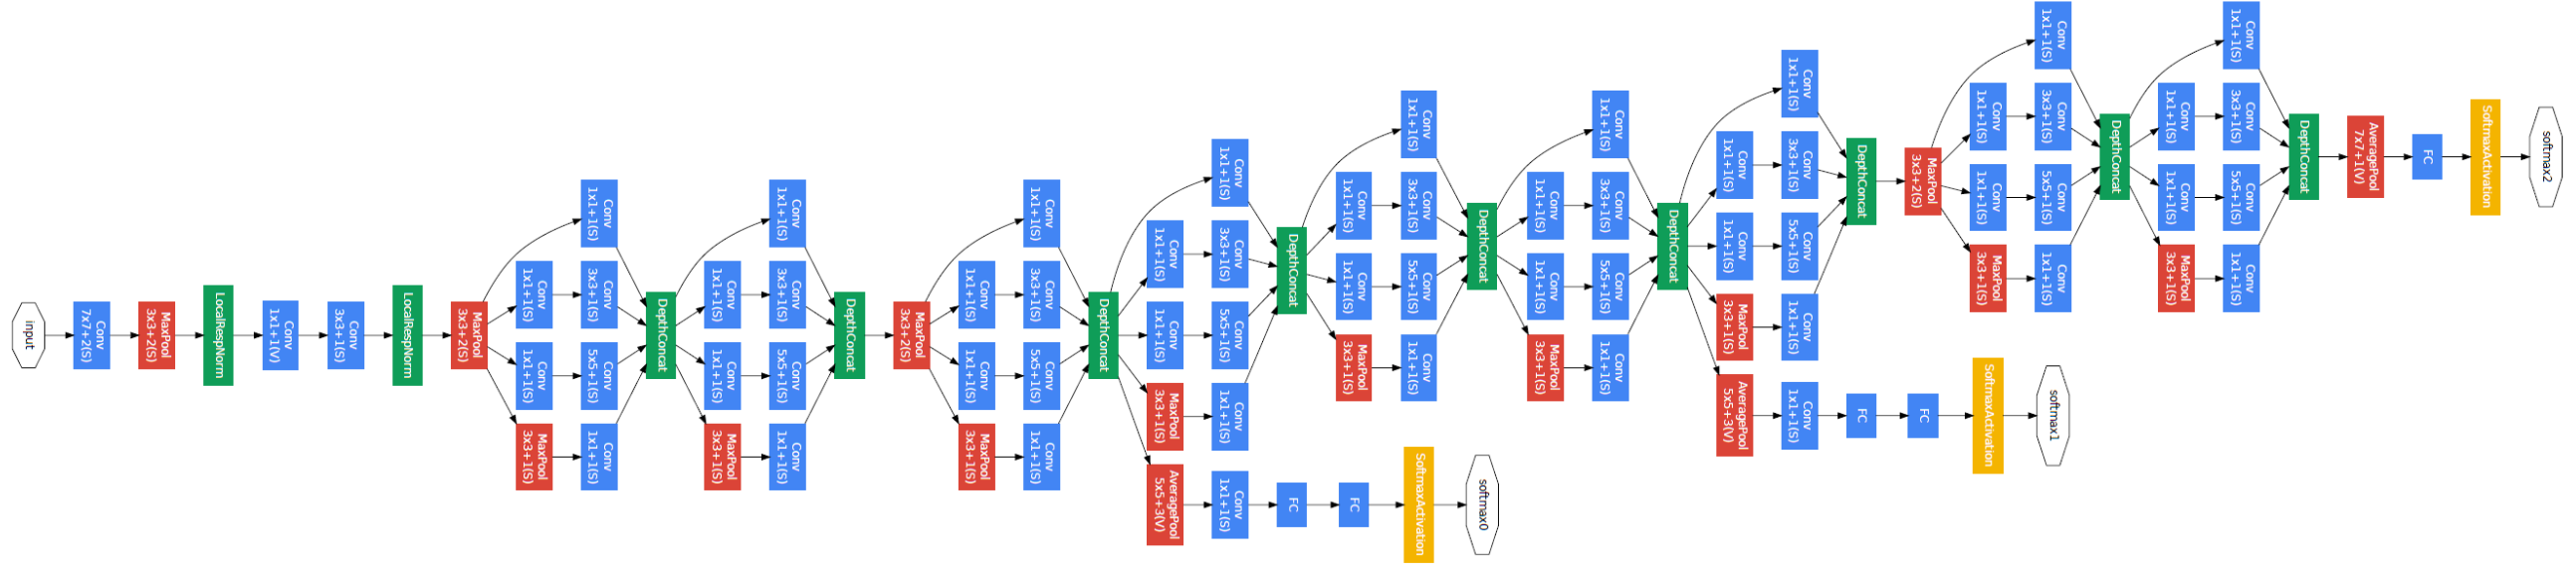

## *Architecture of InceptionV3*

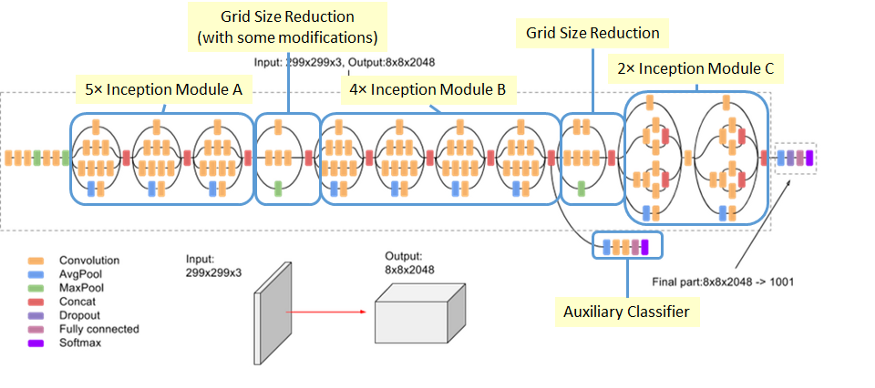

In [74]:
!pip3 install keras_applications

In [75]:
import tensorflow as tf
import tensorflow.keras as ks
from tensorflow.keras.layers import Input, Activation, Conv2D, Dense, AveragePooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization, MaxPooling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.backend import image_data_format
from tensorflow.keras import backend
from keras_applications.imagenet_utils import _obtain_input_shape

import numpy as np
import matplotlib.pyplot as plt
import cv2
import urllib
 

In [76]:
WEIGHTS_PATH = (
    'https://github.com/fchollet/deep-learning-models/'
    'releases/download/v0.5/'
    'inception_v3_weights_tf_dim_ordering_tf_kernels.h5')
WEIGHTS_PATH_NO_TOP = (
    'https://github.com/fchollet/deep-learning-models/'
    'releases/download/v0.5/'
    'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

In [77]:
def conv_bn(x, filters, kernel_size, strides=(1, 1), padding="same", name=None):
  
  if image_data_format() == "channels_first":
    bn_axis = 1
  else:
    bn_axis = 3

  x = Conv2D(filters, kernel_size=kernel_size, use_bias=False, strides=strides, padding=padding, name=f"{name}_conv_2d")(x)
  x = BatchNormalization(axis=bn_axis, scale=False)(x)
  x = Activation("relu")(x)

  return x


## *Inception Module A*

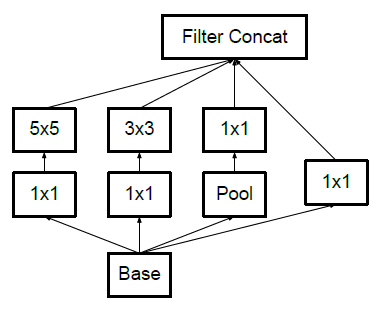

In [78]:
def inception_module_a(x, filters, concat_axis, name):

  block1x1 = conv_bn(x, 64, (1, 1), name=f"{name}_block1x1")

  block_pool = AveragePooling2D((3, 3), strides=(1, 1), padding="same")(x)
  block_pool = conv_bn(block_pool, filters, (1, 1), name=f"{name}_block_pool")

  block3x3 = conv_bn(x, 64, (1, 1), name=f"{name}_block3x3_1")
  block3x3 = conv_bn(block3x3, 96, (3, 3), name=f"{name}_block3x3_2")
  block3x3 = conv_bn(block3x3, 96, (3,3), name=f"{name}_block3x3_3")

  block5x5 = conv_bn(x, 48, (1, 1), name=f"{name}_block5x5_1")
  block5x5 = conv_bn(block5x5, 64, (5, 5), name=f"{name}_block5x5_2")


  x = concatenate([block1x1, block5x5, block3x3, block_pool], axis=concat_axis, name=f"{name}_mixed")

  return x


## *Inception Module B*

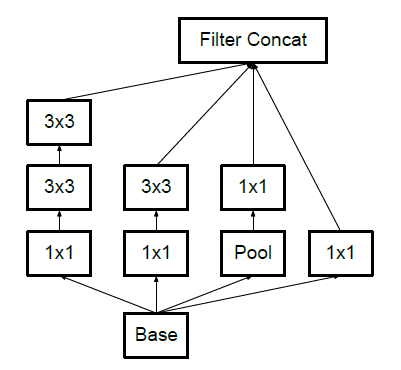

In [79]:
def inception_module_b(x, filters, concat_axis, name):
  block1x1 = conv_bn(x, 192, (1, 1), name=f"{name}_block1x1")

  block_pool = AveragePooling2D((3, 3), strides=(1, 1), padding="same")(x)
  block_pool = conv_bn(block_pool, 192, (1, 1), name=f"{name}_block_pool")

  block7x7 = conv_bn(x, filters, (1, 1), name=f"{name}_block7x7_1")
  block7x7 = conv_bn(block7x7, filters, (1, 7), name=f"{name}_block7x7_2")
  block7x7 = conv_bn(block7x7, 192, (7, 1), name=f"{name}_block7x7_3")

  block7x7d = conv_bn(x, filters, (1, 1), name=f"{name}_block7x7d_1")
  block7x7d = conv_bn(block7x7d, filters, (7, 1), name=f"{name}_block7x7d_2")
  block7x7d = conv_bn(block7x7d, filters, (1, 7), name=f"{name}_block7x7d_3")
  block7x7d = conv_bn(block7x7d, filters, (7, 1), name=f"{name}_block7x7d_4")
  block7x7d = conv_bn(block7x7d, 192, (1, 7), name=f"{name}_block7x7d_5")

  x = concatenate([block1x1, block7x7, block7x7d, block_pool], axis=concat_axis, name=f"{name}_mixed")

  return x



## *Inception Module C*

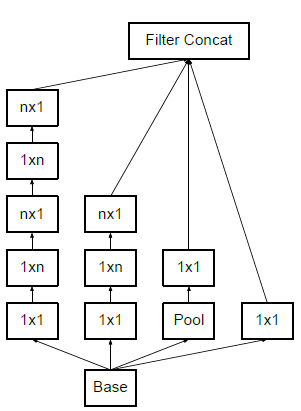

In [80]:
def inception_module_c(x, concat_axis, name):
  block1x1 = conv_bn(x, 320, (1, 1), name=f"{name}_block1x1")

  block_pool = AveragePooling2D((3, 3), strides=(1, 1), padding="same")(x)
  block_pool = conv_bn(block_pool, 192, (1, 1), name=f"{name}_block_pool")

  block3x3 = conv_bn(x, 384, (1, 1), name=f"{name}_block3x3")
  block3x3_1 = conv_bn(block3x3, 384, (1, 3), name=f"{name}_block3x3_1")
  block3x3_2 = conv_bn(block3x3, 384, (3, 1), name=f"{name}_block3x3_2")

  block3x3 = concatenate([block3x3_1, block3x3_2], axis=concat_axis, name=f"{name}_mixed_block3x3")

  block3x3d = conv_bn(x, 448, (1, 1), name=f"{name}_block3x3d")
  block3x3d = conv_bn(block3x3d, 384, (3, 3), name=f"{name}_block3x3d_1")
  block3x3d_1 = conv_bn(block3x3d, 384, (1, 3), name=f"{name}_block3x3d_2")
  block3x3d_2 = conv_bn(block3x3d, 384, (3, 1), name=f"{name}_block3x3d_3")

  block3x3d = concatenate([block3x3d_1, block3x3d_2], axis=concat_axis, name=f"{name}_mixed_block3x3d")

  x = concatenate([block1x1, block3x3, block3x3d, block_pool], axis=concat_axis, name=f"{name}_mixed_block")

  return x

## Loading the weights of the pretrained Inception V3 model

In [81]:
def load_weights(model,weights,include_top):
    if weights == 'imagenet':
        if include_top:
            weights_path = ks.utils.get_file(
                'inception_v3_weights_tf_dim_ordering_tf_kernels.h5',
                WEIGHTS_PATH,
                cache_subdir='models',
                file_hash='9a0d58056eeedaa3f26cb7ebd46da564')
        else:
            weights_path = ks.keras_utils.get_file(
                'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
                WEIGHTS_PATH_NO_TOP,
                cache_subdir='models',
                file_hash='bcbd6486424b2319ff4ef7d526e38f63')
        model.load_weights(weights_path)
    elif weights is not None:
        model.load_weights(weights)
    
    return model

## *The last layer of the model is a Dense with softmax activation having 1000 units to predict 1000 classes*

In [82]:
def classifier(x, num_clasees):
  x = AveragePooling2D((5, 5), strides=(3, 3))(x)
  x = conv_bn(x, 128, 1, 1, name="classifier")
  x = Dense(num_clasees, activation="softmax", name="classifier")(x)
  return x

## *Bind all pieces together* Inception_v3

In [83]:
def inception_v3(include_top=True, num_classes=1000, weights="imagenet", input_tensor=None, input_shape=None, pooling=None, **kwargs):

  input_shape = _obtain_input_shape(input_shape, default_size=299, min_size=75, data_format=image_data_format(), require_flatten=include_top, weights=weights)

  if input_tensor is None:
    img_input = Input(shape=input_shape)
  else:
    if not backend.is_keras_tensor(input_tensor):
      img_input = Input(tensor=input_tensor, shape=input_shape)
    
    else:
      img_input = input_tensor
  
  if image_data_format() == "channels_first":
    channel_axis = 1  
  else:
    channel_axis = 3

  x = conv_bn(img_input, 32, kernel_size=(3, 3), strides=(2,2), padding="valid", name="conv_bn_1")
  x = conv_bn(x, 32, kernel_size=(3, 3), name="conv_bn_2")
  x = conv_bn(x, 64, kernel_size=(3, 3), name="conv_bn_3")

  x = MaxPooling2D((3,3), strides=(2, 2))(x)

  x = conv_bn(x, 80, kernel_size=(1, 1), padding="valid", name="conv_bn_4")
  x = conv_bn(x, 192, kernel_size=(3, 3), padding="valid", name="conv_bn_5")

  x = MaxPooling2D((3,3), strides=(2, 2))(x)
  print(x.shape)
  ## Inception Module A
  x = inception_module_a(x, 32, channel_axis, "A0") # mixed 0: 35 x 35 x 256
  x = inception_module_a(x, 64, channel_axis, "A1") # mixed 1: 35 x 35 x 288
  x = inception_module_a(x, 64, channel_axis, "A2") # mixed 2: 35 x 35 x 288

  # mixed 3: 17 x 17 x 768
  #Grid Size Reduction with some modifications
  branch3x3 = conv_bn(x, 384, (3, 3), strides=(2, 2), padding='valid', name="conv_bn_6")

  branch3x3dbl = conv_bn(x, 64, (1, 1), name="conv_bn_7")
  branch3x3dbl = conv_bn(branch3x3dbl, 96, (3, 3), name="conv_bn_8")
  branch3x3dbl = conv_bn(
      branch3x3dbl, 96, (3, 3), strides=(2, 2), padding='valid', name="conv_bn_9")

  branch_pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
  x = concatenate(
      [branch3x3, branch3x3dbl, branch_pool],
      axis=channel_axis,
      name='mixed3')
  
  ## Inception Module B
  x = inception_module_b(x,128,channel_axis,"B4") # mixed 4: 17 x 17 x 768
  # mixed 5, 6: 17 x 17 x 768
  x = inception_module_b(x,160,channel_axis,"B5")
  x = inception_module_b(x,160,channel_axis,"B6")
  # mixed 7: 17 x 17 x 768
  x = inception_module_b(x,192,channel_axis,"B7")


  x1 = classifier(x,num_classes)

  # mixed 8: 8 x 8 x 1280
  #Grid Size reduction
  branch3x3 = conv_bn(x, 192, (1, 1), name="conv_bn_10")
  branch3x3 = conv_bn(branch3x3, 320, (3, 3),
                        strides=(2, 2), padding='valid', name="conv_bn_11")

  branch7x7x3 = conv_bn(x, 192, (1, 1), name="conv_bn_12")
  branch7x7x3 = conv_bn(branch7x7x3, 192, (1, 7), name="conv_bn_13")
  branch7x7x3 = conv_bn(branch7x7x3, 192, (7, 1), name="conv_bn_14")
  branch7x7x3 = conv_bn(
      branch7x7x3, 192, (3, 3), strides=(2, 2), padding='valid', name="conv_bn_15")

  branch_pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
  x = concatenate(
      [branch3x3, branch7x7x3, branch_pool],
      axis=channel_axis,
      name='mixed8')
  

  # mixed 9: 8 x 8 x 2048
  x = inception_module_c(x,channel_axis,"C1")
  x = inception_module_c(x,channel_axis,"C2")

  
  if include_top:
      # Classification block
      x = GlobalAveragePooling2D(name='avg_pool')(x)
      x = Dense(num_classes, activation='softmax', name='predictions')(x)
  else:
      if pooling == 'avg':
          x = GlobalAveragePooling2D()(x)
      elif pooling == 'max':
          x = GlobalMaxPooling2D()(x)
  
  
  # Ensure that the model takes into account
  # any potential predecessors of `input_tensor`.
  if input_tensor is not None:
      inputs = ks.keras_utils.get_source_inputs(input_tensor)
  else:
      inputs = img_input

  
  # Create model.
  model = Model(inputs, x, name='inception_v3')
  
  # Load weights.
  model = load_weights(model,weights,include_top)
  print("Inception v3 model created")
  model._name = "Inception_V3"
  return model





In [84]:
model = inception_v3()

(None, 35, 35, 192)
Inception v3 model created


In [85]:
def show_predictions(img, ax):
    
    ax.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


    img = cv2.resize(img, (299, 299))
    img = img.reshape(1, 299, 299, 3)
    img = preprocess_input(img)
    
    result = model.predict(img)
    pred = decode_predictions(result,top=5)
    prediction = pred[0][0][1]
    ax.set_title(prediction)
   

In [86]:
def urler(url, ax):
  resource = urllib.request.urlopen(url)
  output = open('file.jpg', 'wb')
  output.write(resource.read())
  output.close()

  img = plt.imread("file.jpg")
  img = cv2.resize(img, (200, 200))
  
  show_predictions(img, ax)
  

## lets predict how our inception_v3 scratch model works

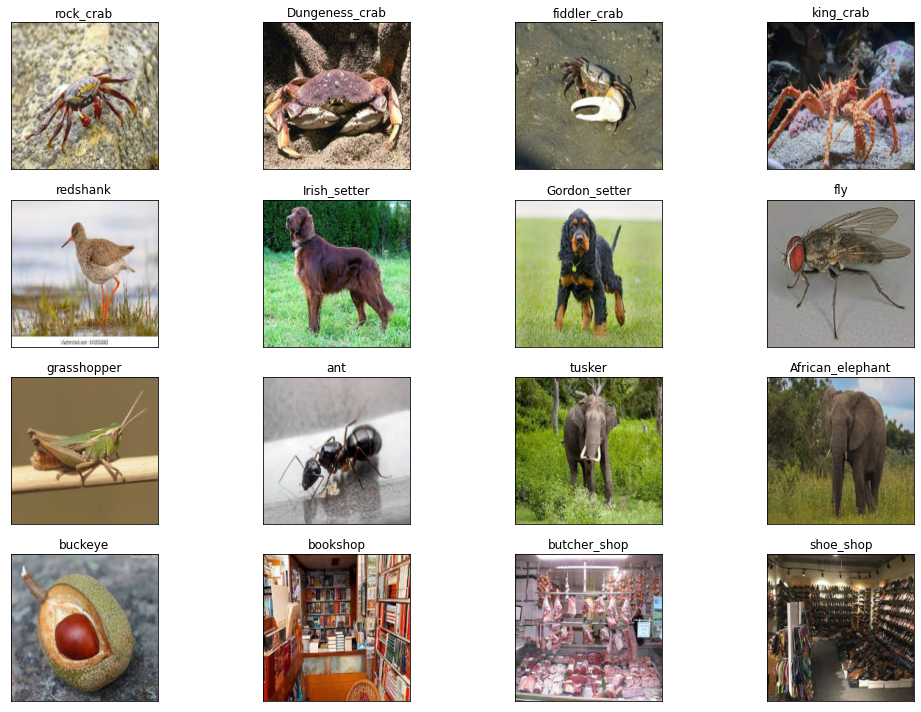

<Figure size 432x288 with 0 Axes>

In [87]:
n = 0
fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(4, 4)

for i in range(4):
    urler(url_list[n+0], axs[i, 0])
    urler(url_list[n+1], axs[i, 1])
    urler(url_list[n+2], axs[i, 2])
    urler(url_list[n+3], axs[i, 3])
    n += 4
plt.tight_layout()

plt.show()
plt.savefig("prediction.png")

In [91]:
model.save('inceptionv3.h5')

In [92]:
model = tf.keras.models.load_model('inceptionv3.h5',compile=False)

In [93]:
model.summary()

Model: "Inception_V3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_bn_1_conv_2d (Conv2D)     (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_95 (BatchN  (None, 149, 149, 32  96         ['conv_bn_1_conv_2d[0][0]']      
 ormalization)                  )                                                      

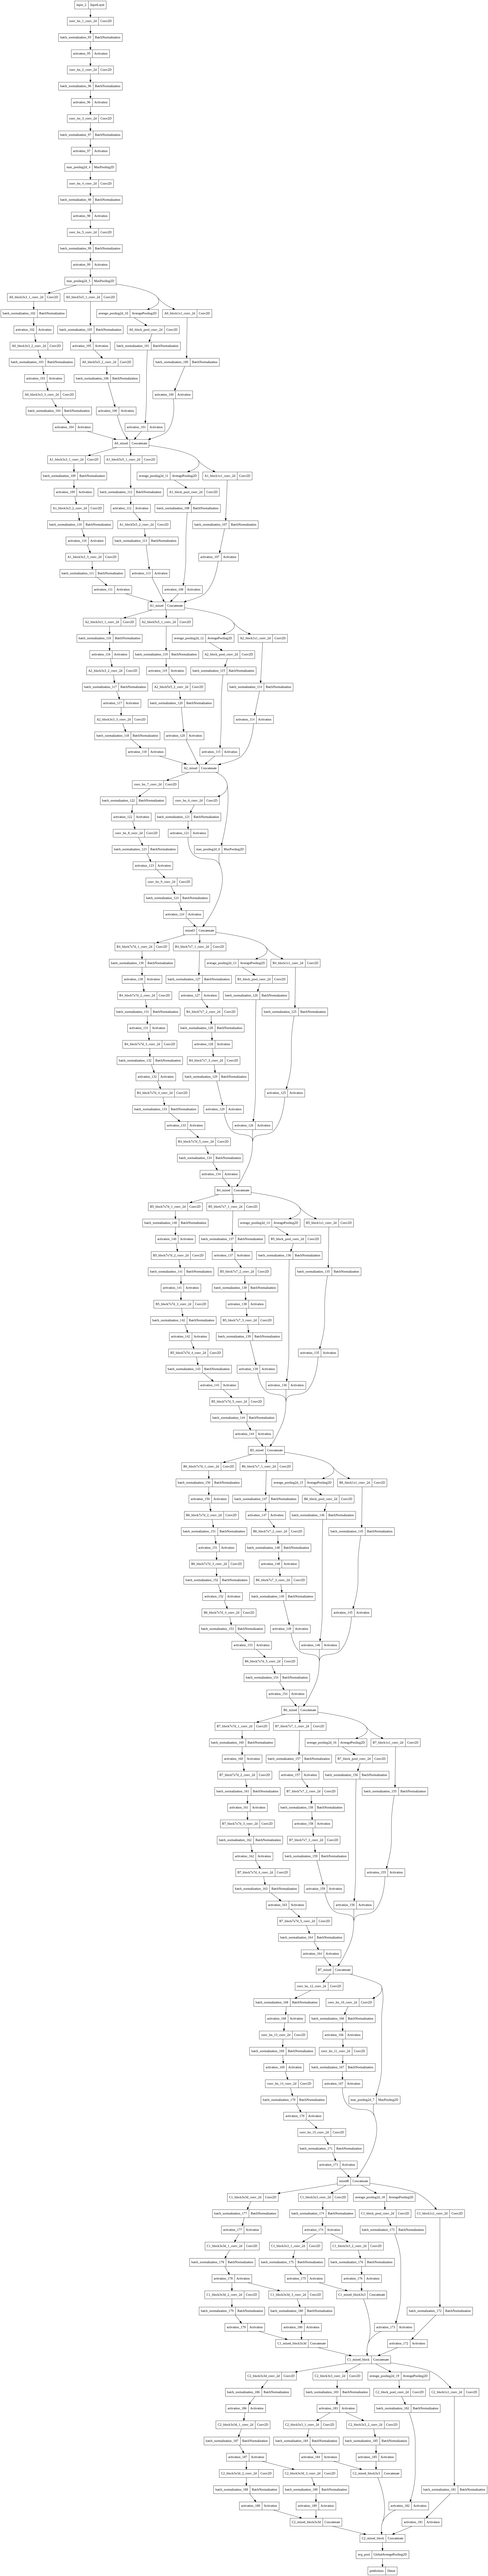

In [94]:
ks.utils.plot_model(model)

In [ ]:
url_list = [
            "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR7r6IWrtMoh7gOyavO9esAZW0CnNQpkIcZSw&usqp=CAU", 
            "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQQiAFKQ20juE0xr-JtsA0p7xLB0xhzZvU7qg&usqp=CAU",
            "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQrbOBMPm-8OURVU3uPbHBZppD5iar3bW0tCg&usqp=CAU",
            "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBUVFBgVFRQZGBgaGhobHBsaGxscGxobGh8aGxoaISEbIS0kGyEqHxgaJTclKi4xNDQ0GiM6PzozPi0zNDEBCwsLEA8QHRISHTMqIyo1MzM1MzM1MzMzNjM1MzMzMzMzMzMzMzMzMzMzMzMzMzMzMzMzMzMzMzMzMzMzMzMzM//AABEIALcBEwMBIgACEQEDEQH/xAAbAAACAwEBAQAAAAAAAAAAAAAEBQIDBgABB//EADwQAAIBAwMCAwYEBQQBBAMAAAECEQADIQQSMQVBIlFhBhMycYGRQqGx0RQjUsHwFWLh8TNygqLCFiSS/8QAGQEAAwEBAQAAAAAAAAAAAAAAAQIDAAQF/8QAKBEAAgICAQQCAgMAAwAAAAAAAAECEQMhEgQxQVETYSKBMnGxFEJi/9oADAMBAAIRAxEAPwD5GjQaLtvNS1OhuDYDbYGNvB7Yn7RXmp0Ny2oLDbmInOc5jj61tAJPgTVI1OaoZj3qNag2M1uKe4r0rSwGjLF2eaJiq9aziqqPmBVT2wc1jA6iamlgzmuNuKItkULNVkwgiKofSkVeKM019UlnG7sKCbC0JSK9UUXrUG7tnIiheM04pKvGeq2M1GskayReozXqLJgUTcthRHLd/SmBZQpqRrlWppb9KWwkEUk1e6ZFX6XSkmeKv1NtUG3kmkctjJaKEsgc1XdcfKrkQ1TqLYmTgUyAcl7IE4qwv50AYnHFWNcocdh5Fty4KEcHmvZk1chpuwvcGrool7QNUshFGwMhXsV7Fe0aNZCKgRVsV4VoNGKorqnFdShNJrvaNiY2bfLP+TSXW6x7plrhPocD7DFSbT+GdwKkTnkUAaWCoMme7TXV01wFOA9qy08Gqq9FAwySCJrnQ/SgEYjg0QmrYc5oBLXTBqvTCasGpBEEV5pyJNZmRaABkifSa9v6pnAEAKOwFeGoGgMVXhiRULTYIq9lnBqjZBimiIzxrfhmqop1Y0SsuTmhbmgjvTCsGsHaJ79qiASasIHFSSBStjJEggHJphYuWlGOaVbpNEWbRJgCpSQ6LF3E4mudSWjk01S0La4ifWodNsKbjkyY/wANaLMxbavshyMVXffcfT07V9B1dux7kD3YXjxGM+dZZLQtMbgTeN0CeIq1rtYjTM49vyquKb9VdGhgoQmZAEUriigWRUVaBVul0r3DtRSx9K0vTvZC44/mMEHrk01AW9GbTNetantW1seydtI3lnPnwKd6XptpB4UUetUjhb2Ns+Xr0+4eLbH5Kalc6dcXm24+an9q+yafScMApH51Y94lyPdmPMxBrOKT7MlLXZnxFNMTV/8ADCIr6f1D2ds3CW2bGPJXH5cVndT7JsVLWriuO04pXFXQIybV0ZD+EHnXU6udD1AJHupjyiupbj7HqXozaN4SO4yP/sPt+lU3EjI4NXOgqpEJ4E1NDkVFSip7CORHzqWyaxirbXgSikt1HaB2rGKdteUQ1UxmgE4URZGKjbQGrPdEcGgEuRa993VAcg1ejg96ATwWzViWdxFeNcHnUbdyWAnFZAY50/RXOT4R50p6nZNtis1s9JfItjdg8fOs97RoQZIBnvVmtE09mdtDmpkVdpl5wD86sUBeVH17VNjoq02lLmmW0owt2xuY81Xo7wkIIBbG4nj6URc0b2bhYBmwPEpmgkZjLQN7qRcQsx43eVEgq8lECnvHJrulIbyy0xwC3pUXulG2oFkd6AdUE6bWx/LZCfQ5o1b1lQbZGfKKUprVQjfn1HJrxOqIH44+Gf0opCWV9W9nTcDXFYLtWdvc0p9nuje+Zi4O1ee0nyrQt1AvPg8wIoc2b6IERCN2SRxmqp6EoOtItsELCKP6Rn71J+qEMiqpIJGXolNPas21Fzx3I7SST5CpdP6S9xxduQfJP6B2n1p0r7hujQOFa2h3ZMn5eQqFvTSOOal7xdwCgCP7VFurIX927QxxA4q/yUqQ3J+Eeal9vA2keXFFWNQHWSIIEyatWwoOBPzr2/aUqQeDQckyEpWxQ2scsIA/cVUdUNu0ASDxEc1Y9v8ACk479vnQ7piGyecVvxfkekV+8H9aj0M4rqq2W/KurfFEfk/ZktN0a2k3HYPHwgiF/uT8qt/1VE+K0I9P2Fedb6naKQrTMEBeSfMn8I/esy2sZp3HHlxHyrmdLsDje2apuvWGHisiP92atsazQmItqD6iKx28EwBFEW3fCqqknzCmfvWs3BG1t6PSXCAEie4PH2pb1n2Z2EtaO5YyO4/eka9RuDBlQJEeVN9N190tSfiGAfXyrWmamuwju6YjkRH3oR7ffNaG51W3eWLi7T/UPWhdTpbYX+Xc3nyiPzpaGsU26JnHpVG2rUbFIMQavVMVxFcozWCS/hyxkYFXfwu0TNW2rZBgiDMEcQR2o7eqJ4uadCNuyC9SbaBExXmq1ZuCCvagvfLJzVqEHvWUjUDN4TiqbqliKZe4FSS0FPEmswoEsaMzL48qNHULlseHIn51ai924pjo9OgYl2BCwSI5kTgnE0jdDLYdddmtJsOzgtA8/PyrN9W1c3G2mOPvWpxcaLaHifDyQOTik97plu6x92wGeTMk95mkj32UltJIS/xm+A2I79zXt9wYIwP1q/rfR1sID7zcT29KTC8YgnFVREfp1IooS3y3J8vSmL6lgEh2LvgoDj5+lZa3yIM1s/ZOwu83Lgmfh9AKdRsFhunv7Li+/twYgN2rQaZ7NvcwnxASCTB8oofqmlFy2wcwD8Kjme0etU9A6XqIHvDtUYAaCcfpVOLRO0F29Su4nYYn5VRZ09sXCxtuzEyDyPnNT6g2wnYd3AAr2/q7tu2CFUcccn0ipZbj/bOjHvvpLyNUvDnGBn0pJqepAnDYniq9X1hltMWTxH4RGM8zWK1Gvb8XPpTt6JKm6Nh/qUwFaT3+1UvePicuNqxug8Zjj7VltN1OZwJ7nyXzqpuoszbVLbSePUcGl5GcT6HY6fbdQ3vFyJ+IV1ZC0wUAF1BHIniupeUvZqMfqEQyQxPGY+4qhLOfij6TRemZz8KwB3A/ya9TTtIVCDJkk8D0rBsja0ZMncAoGWifyoq5ZWAFG6O7YOeT4T+U0bqdTbtqLckHkwOfU+c+VA6jUr2P2/OsEnb1tvwq9sYgAqTgfXnNB3yDgcTUbjL7xdpIXuWj+1PE6d7y0zqrFkM4yGXEx/uH6fmkpUthjBydISC16UTsCoPPv+1eLdUcZqq88nitZqOtrzNUtg0RbPaq79o881kZkRXK1H63o921bW74XtNEXEO5AT+Fu6NOIYD60tcUaBZodYd9tdQmThLg8nGA/wAmwPmB50tL7hRHs9q9jlGAZHBDKeCIgj6j9BWsuey63HuiyoVHRblppwjD47Tehn9PI0nyJOpFnjcoqUTH9P6Ub28Awwa2onjxlpJ8gAJoFFMwK3Xs1017F1beoXaXdjEg4gKpx6zUtf7HXkuMbSK6TIO5QY8oJ5pFkTk0PPC4xT9md02lYlViSYHzJ7UTqbBtllJBgxIzWy6D7M+MXLlxGAHwpPhbggk+Q8qN1vR9KCyXNwG5XieBG3mJiBn5UHmSf0aOByX2fO71vaqHxHeD9wYEfSKfPonO8213MoVNzeFQzKN6knHhyD8zWw/j7CFEJQpiAFDBY4Mzg0F1g+8eR4VjEtEhhzt45g58ueZjLO2jqxdJUtmL9oOqMo/h9Op3nNxkBJjsiwMLH/OTSTobtbukNIIBPMQRWr6s7C067mEqwUJJkYJLdgPpxP8AVIxK2ijMpBU8EEQR6Hyq2GVxIdVBQmM/aLTsdrEkkjcJ8u4+lIlsmJrUW9Wl62LNwwy/Ax8/Kl9vSw+xztBME+XrVro5O5LoPSxd3FmgL2862/R+jXBGw7ARyav6No7Fm34FnzY8mnC65WEKu0eddMItieT3S2P4dJuHew5af0FR/wBSS620EqIJJmJ9K5dSZ8Q3Aj/J8hSe3cLv7zwpB8MQQY7mnlp0D49ha2FKn+YsySO5gdqA094C4wuXAwJhdxwPlTV7doWyxI3GSRwZOa+a9S1RuO3ZZwPKKSe9tBt042b3q2lS9ae2txVdBK55McGvmbo0MWPBiO9H6TqsYJP7fKoXgGO4iZqU52gQi4sWLciYHaKlpwxO1SAT6x+dWPpjHhz6d6t0Gl3MobaNxESdv2pCrZd7lBzJPfNdRt3UqpK7BjHI/aup6FFPUtK9s+IMFHEqQPvEGr9FetMpUuUk5YGMwOY54FHamyUuBbpJAGG3bpBwDt4biOxpRq7LXWCW1nuIxHnM8d6F6tAaa0wXW6fax8asDwwPNOvZj2fXUrca61y3bQA71C7Sf6Zbk/LiM8irOlezAIm7JjJAJ2qO5YjimWt2AJbtrtthfCAZndncfU81HLk4r7Ojp8XyPfYrtXrOmJFiyjEEbbjje7HiROF+SgCnPUPad8W2t7Cu2eQZgTPn86QNpx4S1zbHfn7ZEVH3ZZiwdHbJ8JyfMw3P3rneKco2/J2/PhjJRS7DF+laTU+JXNi4cmBNsn/04g/I0FqvY65btu3vEdse7CEy0SWBBAgxEZ5x3qjTalDgMJ8jg1p/ZvSuzFmUFB/VPP8Atg80kZzi6fb7DPHimuSMP0zp128xS3bZ3GSB+HtmeM+darpHsrqF3m4i5XZtJU7gxBbviI+/yrZa/V2dMpdVQO/JWJJH9R5NZFeoXXuKPeQ8g+IwNvqfrVJZn2olh6Zfyb0Ijdv9OvuonYcMrCUuKfMHBx+lNdP0fTasrd0qqrggvp3MW3B+JUP4DBkA44IIou/rNxe1qAt1dxnJIJGZBwRE81R1fR/zEvaIeG2iqUBM7U4IByYz68Gsstv0zSwV32v8Bb3se1u4XW4q2w0lbhPvEIElCAIY+RnIINaPpNy5aRFtkEllNycxI+DPPPbyq5D75C7iAVTLHLMgPHAzJ/8A5Fe6Xqdu2m1F2OqpuYiZxOPufvSyuW5MeCUU1FX/AIE67o73W96QVYcSYx5elOoLW8tGIkDIxEfPmkCdRvtcJZwlogRvEbvKO8maP0C7t8KRJ8TEzu+WMUtRXhhlza21r0X6fTLYA2zu2wx+pP8AelT63+IvD3dsFQCtwvG0fLzJyAKN6hft27bAvtfb4VPLH0rK/wAUV8KGFBBMgTu7mfQzQjfdrQyjrvsfPbXTy4dMREoQRxiVJ3THesZruq+8dwSeSQCT3OPrmrOp692OwtuYmYGAPWoDS23VRy4MnJggZImcVRRT0Vi2ld7COi9UZGYbxO0wHPhMGQJg/P6UP1LqNu4xS/pUDKSSbb7TJ5kqCGmq06O0AysHgzS3WoXuuSCTJBC/7RE4+VNGNEeqlaTRzLZJxZP1uN/YCrtMyFl/lgZ5LOx/Nq9HTmW2LpWELbRPJME4HcY5p57P9FusxIt/hBDOPDDcfX5VVNeWcO/QydAqJlm3FRtGJnAwOaddP0hDupT+XjLDuJlR5jGTUrzWbKLuYO6Tn8QJicdvTyikev63cuNIZlAERP3pcvV/9YL9l8XSN/lLsNr9yzp9xZt+4mROBPaO00LdW17tX93sBWcNvJbJZYnsIP1pLqenXyhdlcJgme47GPKk+u0zjaVZ8eRiJ7jy/wCKgp5FK26bOl4sfGkro2+t6U1xPAyNjwtGYIwT6VktZ7NXbOXXeO+2e9OujIzqhRnGxTIZt26IODjz/SpanXaorvtTtmMjk+QmvThNTimedPFxbswWt0rWXDbSARMEdjXlm4DwYHlWwfU3Lyot1Vclo92yEkdpxV2p9i7LW9wJR4mPXygVvj5dibTT1sxzoCAwaM1Q4jJaTxTTTeymrZoW2ds8kgAgd6ZD2Lvz4yiDvyaXg1oW0ZbdXVrP/wALbzFdR+OQbRndBYbUkk3Nu2O0iPvMzFaXpfTUtSEYM55d2VR9CTxM8T+VJT1ZlDLbtpsHIkAn5L2H7UTbDe7Fx3XcywltZbbMgliwEcmAJ85qc5RhEOOEskqD+sa5CFtIQSMuyk7WIngE0m1GoFtN5zwAJiT/AJNViVBLEQOSw4pL1HVG40T4R8IHr3PrXJGHOXJnoZJrFHiiWr1/vCS2MY29j2+lDWSwIg5mr+maa3cuBLlw2wYAYJvycARIr6DoPYSxai5evFwMhdmxTHnkmrzmoq2cMMbn2BfZj2dS7tu3UYiAYnwsw5JESR9vrTrqXWQB7m0AO2MAeg8qD6h19w22wwQfDPpSf+AvOrOqsxz4okfP1rmfLNLR6EIxwxuRT7xS+138R4E80SNGvIEeveo9I9jb11t93wLMknLGtLd9ntlvFzc/rABHl6fOqz6eUVaFh1Sk6ktGZ/hoJg7gPxDijNBqWtsCuYzB4qtyyMRwYII/4rlGJj6VyNM601+jQtd99byB4RkfigkZABicUvuXnBMQBgTtElRJyY9aH0mo2EMOR+lG6nT3GQ3bVrenMA5TvtPn84qsPyVEppRdrsAWXZrg3kt4gRuMxHIz2gVvuk31e2DbUwROYn54rBdOuObqBV+KQQc+EiT2pr1W49m2FttcQidpxGZMc4H3pZPjJIDXJP2C9f1Qa45P4QQvkGmsu+pKkhZPoKYdUDPp/eA5VgGjMnJOflFMvZ7T6O77s3DDk/8AjjEjzJ5Bifyq0IVoSWRL9Aei9mdVdVHAKJcyX3KWAIlRAMgHH3p10v2XezINpXfblnKuDMjvgR8u4pne6/tZ0UBQuZ7QIEAff7UbpuqG9bYoVQ/7iCR65+UxU5txbQY8tOtCTSaSybgQ2x71AZ2klAe3h+EnzPGKZdN6NpdMUdQbl2W8QnO6ZhQYwJGKs0mm2QDbk3GO9xGBkAH5nHpRdnTm3cPh8KqoTvEzukn5ADtmk5Sehsii3ZPU6O043XUUpBhCOJ5+RjypPrethBttCFAgAiI+QBxXvVbmoecDYBMqRCj/AHHz/el1vQCN9wktEhBn1z+1GMJSfFGXCK5Seymz027e8WFBzLGCfkOT8+KNe3YtMtvYrsxg7gS8898fQURp7huBm3BSwGzGQP2NepoEtXFuu0wDnzJjNd+PpoxVkMmec9RHbeJIaApEENzBHFfO9ZbKuy8wSJ8/L8q19/qjXBttpORLEiAZ4zSP2h0V3cbxVCpidkwIwMH0FbqMfKNrwbFNxdewDomqa3eSD4d0EHiGwYHnH6VvbTg4gCO1fM31IUyUY8xkDPY/en9r2nuAJaRQ7kDaYgmR3jk9vWKn00nFtDdQk6k/6NhuHaJrxkXnGe/nWd1lq89vfkXTB2jzjMjtzxQo6xdS2wZgt0ZFtonbPfzMV2qzjteUazeEmZAz8qFvdStjBbk/8c0l0Oq1FyBdZArDIU59e2DVOo6NaWAEO/mSzE+kSY55o2c8o7Hf8V5HHbP/ABXVnTpicjUFf9u3j0r2h8hqMn0vQ22X3lzcEBxbRXh282dsHjIWfpV+qvAku5AH2AHA+XkBUrzKFW3bkIk5PcnLufnzSDqOqDtsBlR+Z8/1Fea7yy+kejGsEP8A0zuqXHuDA8IPA/v/AJ3pUGq95HBPp+3rW06B0GxaC3tRue5AIRlhVJyJ/qPzqzcYROaKlkl7A/ZfoYtgaq/K7PHbUqYPk79wBiKL6l7SXL5CswUDgKIFXdX6gb7RO1APyoPoXTf4l3VN0Ks748JMxtB++ajBSys7Kjhj9h/ROjNdYEjwAjcf7D6V9A01sIoUKYAxHlS3RdNCWhbXwCBjyMcz51F7upRNiW1ePx78kcnEV2KCjqJyym5u5DK3qlcsoMFeR3B9RS+zqlNx0IYESYMyf+P3oG/dt2LRYh0bExO4sfU4NUajrD2rabl3O+Q08A9zFPyavQiXbYZqtJay9yQoEDtHfkds0ivNYXcVukxyIHHoe55or3ty64tXHGxxkfCT6Y55plc6TbWw1uNoY8mJk8ZpXjjLb7jPJKNpdjLXAJlTKN8J9PpTKz1MogS2SACCf9xwSTHyimHStM+xrQCwiwrfiHpHzzU7PS1fw3bYEES1s7dw8oqPwuNuI/8AyLSUin2csD3jGQzAAiCCoBmRj8UiiOu6knaHQAAxg8+R+dNbXTrdnFqVXk5knyBPkKlqNDbvnww6wO/4s+Vc/ByyNeinyqMeVGHN5DaNpp5LKFA7iCW/L7UutWGUCc9wRgg8j862Dex16ZFxEU9gCfpJzTi10NURUKhjBBbaJzz8qv8AG6OZ5k3ZgXvzkq09/wDqojWAz4YH1yB8uK1Wp6HaB2lndz8IEAr6kxxSHX9Ne2xUjA7Yn71J02XU5JKzUdH1dwqlu2Qyi2pgCSpxhj3PFRtXb9xnS4wIOFBgDGf8mlnT9PeFgtbZkx4hwSowT+VNF0FprZHvSzxldwnPMD61zTX5aOuLXGw7TNcAG5gCREQGgeXlx+tX6qxauK9tlKCPiGAQe3qPSst1HSm2Pe2iSsZKkwD2kD4fqK9t9X1FwNdhbkiNpiFAwfD3qnCaXKJHlGUqlonqba2Af/2Qw24KJuKqCBmGHcgUo0/X/fM9s79ijwtG2R3JEnP1pnpVQ2kRrbMlw7j4vhMEntBxQPUuk22XdaUISOGgf3rp6fNKSdi548GlHsX6bVAFBtJQncSuDOY+dX9U66ltfdsjOhUw0xnsTHOT+VZG896wTukqVgQcEehqVm//ACtzQ39I7jz5rou1RNZCyxfFxZHIMHy+fypiNSqW/eBYdTtDDleSnP8A7hWe6UxQkHhj/mftT2xpmub7aOFLDkkgHaQSDj0/KuT+GRNdmWUueJ33QJa9pLlm4wYkkxyePl5UCOoPcuM5bkQZ7z/1Vtz2fv3XJVD/AE4jaSMGD86gPZnVI+33ZnjtH/Fdbk+xwuVmm6HfN22q28upzxJA4Ge2KKuao3HIdWUrgxBAI5JjJ+9LOl9Ae2CHDoxHxK3EZMxTzTaJlP8A5Dt7CIA7mDWuzNhaadWAJfn0H7V5QL9Kuyf5n5mvKbQKXs+edU1oClAczBg5HeKp6X0i9fn3VpnHG7AA+pip6XpofG0u5kwDJ/8Ajx9a2/Q+jjTobjCHAnaDhB6+ZNcraxqi35ZZW+xV0H2ctaWLuquIbgyqDIU+n9R9aG6lrjdckTBPHJ/7qou+qvBRyT9h3PpWt6L0tUAuW0BCrkFh7wsY5HbGY5+VTjjllpstKccCpbZ841ml1Lz/ACbioBJ8DSR5nH5V9Q6eqaewiLxsEdjxJn70yd9qkwMZ8gRIJMj1rMdbdzcnI3L4SD4Se4ntE111xjSOaM1OXKTGF/rVk4ZkUeZPJ78d6A0muvqjXHHgDHbA/D5nMxxQA0GnYlQvvCwjcskhs8QOK0HRNLcC/wAxlZSBAEuYOBMYHHlWjFUUlNKV/Qk1nUrt1ktrbZ0kNETPfmMQaJfRfxbAvuQKDCjBJxODxyK1duwsjZEqex8MmJBjmPKp61QRtiT54GfpxTqznc7ezK63o5AQrvBTBaJ3L548vOvb4uBlfcWthhMjkef/AFWpsWDwGiIw0cdxPlzU7lm3tyuDODn5xWUjOSEOrtm8o91c2kEE7fTsaZWtOwEuxYT2GRVyaC3bWVXYDnB/z1qCI4LFRgE8EEER3k4obqgWm7YI2uZy9sIAAeZyxP6Ux6NYFu2REHcxPzmleptg22ZWnE7h5/SmHT2PulYvkgS2CCYEmuHp5cskpejr6hJY4xQe+ogRzn60O98sdifH5nhZ7k/2pdrNU6mLcb25I4H7n0pjYUIgEGTkseZOTXQ25Ok9HMo8Fb7lmn0ipMncx5YjJPb6VB9DbchioOeCDk+VetcUHnH6nvxkVdvgAyBPn2+WaooJKqJyk27MV7T2biMwt3CqHaGSAoCz4YI7AjNZ9NMwuhTeVSjYuAiJBnB7/WtJ7X60h2VVkMgDEjAhsMD2OSM+YrJh1UI5IYh//GRErzMjtJIriyqpNI9fp23BDXT9La5bLJuAG7cd/wARB5IAxjtxXaNgjKoJAJmBBnzJ+gqrQbTcKXN6B4IAORMFP1phe6VcsjfbkkTBwTEysg+vzrpwSuNejj6iPGdvycNVeshAADbYSVI/Md1NEMyX1V1RlIgmQCsHvM/kRSy7fve8Qh952gLgGIklSO5BJmmlh3VElJSDheAT25nio9PqbRbqKcE6Fevu21nepIzAwQBxPFZ3XC1cZdhKY+E5HzrWdQ09ombhZQ3c/ciB9qD0mksl9wlAQY3eEgiI57QCa7Hs4rPdB0NADuuK8bT4ViBPJ3ZzI7dqo1f8u9uAwGkT3BzH2NGP01gC4Xendg/5Z5j70HrbhcKx5Hh4gQvHz559Kh1EFwv0dXSy/Kn5NrYe3cTcqCCN3YZJiIB84q19gIOMg49cYBnNIul3dy7UgtG6BEiMEQ3rkEefzqwvcZo8XMZBiPL0PORV8MlKFs5s+PjNpDlmAmR5cDPFDO6hhIPyjE/OhrmmuMAyvyVAkxtMRAIzzn616l7ahLmSDEjt5Z+Wc1Rw0SSoJwfL866gPet2BI7EIc/aurcENSK+o6tNPb/CHJ+FY+xI5ArN6W3e1TsASE/GZ8IH96C0uguai4Qp8IPiYnAFa/TKLCFFts2zMqQN04Jxhs4HPBrgjj5y5Psds5xww4xdsO6XpLdpQoQblMSM84k7ex8z+1WNc2t7oM25yTuAJ2jnkcRPfynvVJLGCjkKTLeIb1BGE+HzPfIjnvUk0Ds3vJKESD4QWInOYHMftXWlWkcDbe2GW7stAuKecYJbGO/14ry/pLbN4lEhgB4Rzy0Ge85OK8RAphQJAGQskgz3xPPHrUNPfLqGG2AxUEEMSwxmRjkSO0c0aFsLXwg7UVQRIEBeCPCYPl3FQBYAqpUvEx8OZJyOAIJzUUYRmTBgrBMHtHl6zUrrLCmCI7ZJz5gTNCgo8FphkgSCYCzuODJB4Y94OKttXGUmU8JRZdmAz6gYBEZzVaXiCAx2qvh7w24Ajb3OcVMpbhnMTOZJVWIwCd3p94o+KNRdbYMAfEJEzwYGRJ8q9uJCiDuHJ3HnyOJjkfOgXdPGqEqSsErtG08Y57fSuW6wfaRC7YgZmOMkeE4bA5AmgYNsXUdWIJIVjyO4gRn1/SrNQ2GXjwmcgf8ANAJefIJ8DDmYIPljERHeg9I9tSPeXXbfJQHxCBiA0cycgk8Us3+Lf0PCNyR62sRbZswdzEAYwAeTNG3LItLstLk+Z4J75/zNLlB98scQSY7AfpTi3cDDD4kyWA+0+YMfauXpY8sezp6mSjPX9gGnsXEBCqjuSZLPAE5xye1W3NXdEEWwVAEENuk95mMc/aj9KsAgsrOBBgiImf8A24qgWixKnj+lsYHcHvXZx4qkcjfLbKP9UaNz2wvigbjx5ztnOKvHV1uSURvIMMfke3lVdy3a27m8ZXsPOR5/rXam4lpQ7KRLDgwM4E9v+/pWtg0Zv2nR2QXArrI2vPJAMjd9QftWQuCcSBPc+naa3PtJfFyxsAYgsGE4jB9M4n71intCcCfQ9/TFcOeuZ6fSz/DYT0x0O1rpYKpEuM8xtWDx8LVuLLs4VlfwxOSwnJjESP3r5sVJMEECZ2zj0kdzX0O3qLaqXZ9234ogsAQDEcmNwGa2OfG35BnjzaQq6hp7lq4l1CAWJbZyRzJIPxCOcitFoenAWoClDyVJwD3IntxmkfQ9MdTdN12aEiAQSGmRAPkMyB6VodRatuphnDE+F0knjjPIiOcVbAu8n5IdTPtFeDrWiABd2OCSBCxE47enHrQnXNFO3wGSZMDn0n7eXFN/dgJ4m3wQfFjgzOI8qpuatA/wNxMhhC5AjJiT6etdKZy7syaOq+EKRuEQ0kADn61V1u+r29wUDadoIgnvggfXNP8AUdHWd67nKz4WONxkn+wmsnr7nj92gKZhgezDB86TLJcWvZ04EnLkvAX0LbcDAwrKrEPz4TGDHEH9aeaHdHjcHyYT2+XH186QaC6ltrgI8EBT6CecR+VaDpqghwH8JMiCSB5etDp3UKZupdyYXq3YpG9SQdwmB+QwZB+eKCuKpXaAxkjiVmfQ9v3NHf6cseIqT6n7rzkCr7mnAIcYAjA/WB9PtVuZydgb/Tn7X1HoV4rqtuOoJ8R+5/auo/Iw7AdH05bae7SVAEGBtZ3ImS3pjzj70FqenMhn3jtt8SKSAPCBC7pgDAzWptGy8SonkV7qOj23IYcgQKzxvwblfcTKyeElwrKCQyloEQGAPBHOD9qMdlksGZtsEwT4fPAxJ+p5qOu0MWyhQQTJ2gDvM47+tCK48TNuQgzlhkKMmMjb6957UrTRi+5eaVA/9RByWAKnkGAJMGcHNdbAchxsKwPEDIf4hgCFEYk95oT+NXwlHTaQHmeR+Jhn4ZMQO5oduqoo32rZuIzR/LWOAWklsefH50GFdhwqD+oIN0Rg7y4AE87fESI74869e8iBlVsjxHxidueciB4YH/dZ+/1nZbBcFFP4gviBmQIIIPYTjJomxqLjp8fvPeAlHYBTtwAmBBbJyOO3FHwChjeubh4SwkSu05+e7M/LvBqm4zb45UiCTtHEYA7gznn6UOilLf8AMaABtJbvgjHmJ8hwPSluu61atECN5MthjO7seJI7emOYoWGhtrdYtoqJVRABMAQJwqmPlj0qm/rUUB3UIu6BujIkAMCCRj18+1Zs9UvalyiW8MBxBMeW7B57SKGPR9W6e7jCQQhOBHEA4xIpW/IyQ5t9d0/jUOwaeW3MDPMk8jHGOZploNYbjbmgqBKEZH+4+hk1kbHs5ck+8coRJgANu9RBrWezXS1RHubShIAK+ZEgH0JHNQzcnBpItipSViv206mFKGyxXsTkH5VnrXtLfTJfOcyTk4yMT9RTX210pVlBmOcLIB7Se1ZJlIbnJkfL5fahjtRWqDkUXL2afR+1t1MlpBPiwskD8MmT2o7U+1V24nhUSTIhhI9MjiYrGFRPpGIP+ZqegsbyQTGTEQd3eBPJqnNk3GJqG9rLwIlUB5JBJPrniuvdWu3gwVdqt+No2KPQEbiZHaR8qTr7xGm24O4wNwQcYJK5jEd6PNrUwLhuKw4gkETMYkRPnxzTpyrYrUfBZqLtxZ944MkbSsjgRwYjBoTS6spcDAx2mSMHnIGMfrVur1O9RvXadp8S+YgZ/wCK7dadPdhlVBtLFgdxaTzt+FRjMec1zvE3Lky6yJQ4ld8lroAEkxgjHmZjtFHXr63bqqrOq7dtw7viUGfsABA5xQGq1qgbLa+JgFhZjHxESSRuiecCmWk0FtNm87mO5veDdsO3aSvluzxHYmtHG3L6GeTjH7NAnVFtotu2rrsLAEAsW3eIwe4O70zQ93rLIbe64Fn8LW2he0FgZXmARM57VA3kt3FuMFZfwbjBDHgDMRzIOJAok3bTlQzEMSSrRKq5MjE5OMds/KulOtHI1exkrO0m5syBBBViR8zMnsTXjG2zbWAJwRsPxRwGAxGfMjmhLltLj7nVSqkCVJVx2zBHBmYB4rzS9K2lYBBOfj3Y5gTzPnj5UX2CX9UlLTbLblplRLE8DJHYen9qV9M6Ij22LXGF0E7iJG3zUE4nPPrinfuSqyqlWJEyZKjHi54gduK46UorCN7HxMGBhvKDjOPSk4W0xvkaTSE2k6JastvKtdJxJHhzHYdsc+lOum222wSME8DaInEAHgD71QbFxsmE8l3bp4xIP9u3lUb4dT4/hCEbYhu3LAj5ZxTVWkJd7Gb2g5DFFO35Mc+kyOKgksCQApnIjmD4vnxHagLfUrK5ZwpGAJyFOIn6TniaqTqFt9xZkJUQJckN6kNic/rzWFGdzZJm2v5V1DW9QsCbhX0G3FdTcQWYzRdfcRmn2k9pDjmurqym7KuKH1nrG4DE1V1LpSX7bD4SRmO/eD6V7XVfutknoxp6RcW4bZnaJjaVXngDy/t2osPft2wTtYGI3+LaJg474HHrXV1cybKeAxtYxZFKB0gBt0bvQeUQeIq3Vl/dxaUBRIQDau0HBIxg5/ziurqZ9mD0DabTMQq33LMxkTBKnsJz2HavNH0O1KF7SFjkgs5gD8j8QxXtdSowz0di3aYrbVZz4YIzj8XznOealrtds2hUBkwWYkAdwdq5J/bkV1dTIRi3T61LgLndIZsFmJheYP4T2gYpN1fqjKxVGZVEYnkxMnzzXV1c+bsd3Sfy/Qu1/U21KBnjcCBxxA/Oa80vSg4TBloyCO8GTJnieK6uow2ti5dSY80PQrSsQwFwhkEMPDBnMf5xU9d0z+Yyiyh+IbvCMA+Xfggf2rq6npaI+yOgZLBK7VYywBCjjusMMcTM9zWj0Vq2wW4tvbztiIGSZ28Akk5Arq6qImwS9btlGt+6CwTtVQgUnnBAkd8msrqdfaBKrbEpjcFAJJlXmCJyfrM11dS+BvI2uG0yWxA2MDGDMGcD+n4TRj2bQUAoDgGciQ3hyRBz4Z5rq6l9h9Fl7QLdUA2hvldy7sLmQQTyYHP3qjqWjXduNpngAcpHkDkicjj611dTACU8Wz3bMp3BnUYgx4lmc9jiRzVllLiukXJtiYVxLRJ/FmcARMGurq3kHgKv3YAAJBmA3JHkc/aK9OpAXxqVGMgzPP17HmurqFswH/FWjCWyzuNxXLLAI8QknymkGo6jcbwhmCwBtLE8dyTXtdU8knQ0EgIJFB6x8V7XVCI8hNc1LSfEfua6urquTpH/2Q==",
            "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ2R3JUHhAPOeUxczC1qq_LHuz4kshvsK5J-Q&usqp=CAU",
            "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBUVFBcVFRUYGBcZGiEcGxoYGxwcIBwdIiAcHRwaHBwcIiwjIB0oICMaJDUkKC0vMjIyGyM4PTgxPCwxMi8BCwsLDw4PHRERHTMpIygvMTExMzEvLzMxMS8xMTEzMzEzMTMxMTExMzExMzExMTExMTExMTExMTExMTMxMTExMf/AABEIAMIBAwMBIgACEQEDEQH/xAAbAAACAwEBAQAAAAAAAAAAAAADBAIFBgABB//EAD8QAAECBAQEAwcCBQIGAwEAAAECEQADITEEEkFRBSJhcTKBkQYTQqGxwfDR4RRSYnLxI4IVM0OSssJTY3MW/8QAGgEAAwEBAQEAAAAAAAAAAAAAAQIDAAQFBv/EAC8RAAICAQMCBQMDBAMAAAAAAAABAhEhAxIxQVEEEyIycWGx8IGRoTNCYtEF4fH/2gAMAwEAAhEDEQA/AMJNxJJqCGAA06aQriDnUMtSdBcwVKlUK10On6ftHiSnKCUjMl2NRm2JGwoNIhtV2efFZsJIlpUrMS7itQ4a1Bp1hVOJzZhmcnQPpZj0g8qYQkgBIYEUZ+733pAuG5UrLJDFxbM4F2JsddYy62PSphpBIrVKg/KeoLV6wTDkmwYAGoPmfOAhWZYQl2cjnZ70c/SCYrCmXRSnSOhDOHvG5A0RRQkh3IVdTvfbWPMNPpnIFFEdqX8qRcez3CJU1IVNmHJnKAJY51EAEpzEUuKsY0pw2BkSyFSUAkulK+c/3KKtTTp0hnBU22Xh4WUzFIUWBvV/w3jps0rWCDUJqCXqfK3a0adeIQkuMPJY/wD0y6jZwIGjh8qaXlIEuYbAHlUdi55fIgdNRnBpYDLwkorDsolJpkIsHfat6wgJIUSDnD1JHTWtIZJZSkKo7pIIYgh6Vq/SFQlSeUp0oCKeR76QqZyx5GwhSAQOYkBiAAcrVoNfx4DJRSgb+lQAYku5Nfn2j2WsAB2d9Nd9fF0iUya6gllDUPRyzsTrGbdD2zsqCcywAQ1yANK006R6hRKaPlI+IE/9usLYTxKIJIflFL0JtfVoN/EqbMoEGwBq3d9IyWaFkuh7KAJKXOWjg3HcPEjMTmsz2avlvAFgNVxn0t6aGsRQkZgkZj3YBxe8CbVipdR9LBRfy0LEUfShel4IoB2QNOYkv6F+hp1hX3hPj316Pt1+sdiEZi5JSAG5SG7XNL+sLu7grueTphWmzHQnW8IYaYS6Tr8q0+8P4ZZCDXoxrm+tIFkT2Z3b80gxaXI0cWgk2W5elGDEs4sflB8UsIBCWBAbzLfZvnCiVEktuB894NMCFKUpta9TZoCl0MyciY4BSHen6mkamRNRLkhSSyi5YXArUq60oNNozMsAKsAwpsNyOsOrnEhKczAWc96RoNK67EpDUrHKJ8VXvZxsR6M+0abBzmmIlJIJbXQ0cfn3jElDMWqDsXLaeUWGDxCkqExyDv633oSIp6o5NJUj61I4QoJDlJo5Nf0jMcVxTT5SVCiVZgxBd0sP1G8WWE4ov+GTnUoBYbMAmga6nFBGMxuKC5gRnognmuSH/moT0tHRq604pUZKD4NnL4auYc45k2opLHsHa9H7xU8SRNlIUcmVleXKWcEDXmHpAuGYspQeclqFiTlcHzcQLG4hUw+7WpWWuUPc1Ykna/48Teotu7r/ALKVihb/AIggfFl6bfOOhKZJYkZTTr+0dEvNl3/gSkYT3pUpQyOnM6QGDaNXSCyZQSTY7OdLnaCzUhQ5ZdAzklza3Xz2iAXqUhLsxLu36fpBlwWcrQFyZjAkVNaDqG0fvHiAtCgopNiAX7OzXiWFRVeZPKDRTWVSxGjadYblAAhBBypDk2+7EkPAusDNpYE0T8pYAqV/MANyatcxo+Gey0yegLmTUSZSrKUFKfYplivSpAOkUTh+RKQWOUM1We/079IuuL4Rcoygc5CZMqYDLV8akId6USB0Pk9H01Fy9Q8I7nfY2OAThsJKTLSVzShJSkqASkOokqSgEkEuXL1jNcSX75bklrjRiDTSA4XFKWsTCfEfz7wWfOCVilNYrfY9JLFMVOKCMySsr1cgBj0aC8K4kn3iSDyJPMRYdzFFxnGjMyC77QxwXC0J6/S9YG5mjzRp+PcKws4zZ6VqM3LmKGZJUAxU+523feMkFhub6poNbfnWNbwqUStMsCkwEHZvxrHeM7iZOUqQumQkMNFAl/ia8SmqOLxUIxaaRWlIGWtHfRwfqxhhaUlToSczipfzffpaCYiWky0lgCnzKbVf9jeI5iwBDk0JFCNqigBhGct4E/4bIsqBdBPi1c1t+0GWgEZrki5fy13gipZSSEsoEBstQ9Scyhp16wGXiCmhBzCjelGPlDWzO3kh78qQxAOUsWLZS7hQD+XWJFSspIpW/LU6gA1e9I9noSVlk3BzVFdLA1A9YCEKUpmBY0BoxbYOSIR0w4GAo5Q/MXJaiaakpGlrbR6tTEMlxY360ppASHPM4KXaoZ2FBTtE5y2DBJVmFXIQBT5mvSAlbFrIVaQdNNBYdgfxoXUCFi+XV6RLALKgSXOmUXPUCB41gyd6PWp1BG7/AFhkm3Rop3RNC2/p1/xBMMxLaAPfX8eFTdI1UKA3Hl8m6QZUpSSG25vt94zjVhcRk8rUL3J/WD4n4ToaH0pAnCg24HeBZ0sUuCoVIOo1A6hxE4XdonRYJxICkgJ0LDTUA99bwXDLzdK6xWYdIIWwqlNE7gqTV/WDSVEkJUHJckD6/nWOhxwGUaRppOPIlsFNo2+5IMVql/6ji2Wh33EV6FqcooGr9n87xDB4pSVgEgpahegG/Vto55yblSNFWXOYpyrOYDXKb3+Rg/8AFrdRLgfKlr+ZgeMXylCqFklKlF6b/QN0gGOKEBJSc5yEElJuADbfX0h3Gr+g3QY/j53wzC3Y+fzjoQlpUQDWveOjm8yZtpTYfFIzUGXqBck+EJ7vHk+cgE5naoZXrQaeusBByczZg9A7V8vy0BVPmCgCUsbqILdHV60jtatjqNvAzIVnQvMQFmpowYsACWvf06x4xFy+VJNDQs9/wxPCyle7WsknMQCSg5HsGXau4iaENykPUjxKqNi9PSFksglhi5nglPKrNZJTsd92+UabiGL9+pC7e7liUoAjlKAkBRTUsoP2IaM+uWSOUqSQXDs3Sw7Cl6QXDzQV50lloIc0Abq7M93tBvsU09TbxwNSeIIBYfJtndu1xBMXikuxVZL3Dh61a27QCbgET8WUy+RGZRKiqgoSABSpJA/xFfxafOJVLy5UopdyQaOVMHJ3aKRa6noPd+gtJCVTCs+EFktqd/KL7DLYjLYPQbEMR9fWKHAhkgHcxd4WYNGtQRSkCFml4SDmSm9R5Agv5vmbvFF7TS82JWolICiFZh1GzD4s27veL7DOkApv6MHo79G9TtFZ7QcPBVKSJic9czABQq6U1rer0DE7Vm43FsXXi5pJclLJUSeWY7VFC9q0NtOWI4gukBKmJHMAX8qkO8DWVy8wWhQ1Ob/TVdqAFmO8FX/MG88rpBbfWJVTPOaaYGZKQrKHIAG4Ft0s4ghUaVYNoCW9CxiM5CgkkjMRV6MG+KtqM8eS5uYnmcM5IFH7gxnkXoQmJ5H8WY1J+4a0LpWcxcJStiHJADbirZmeCGcSoJ5ak1c0HV2HpHs6WczJCXYFyc1LEEVfSN9GNHswwURlKlhRZuXfTxB7NaFsatRXRQoBUqSx2Z2rpakOAcp/06hPKQTloRobU/SAYpWYcyS+Z2ZWUE6tS/neFjyaLySkTSEurKNQASaa6teJTVmYpNS3ifUeYHziBSgtlBBsxLgUp5VtBUKCHGuVn1Yl2HYkxuMi4uxeZhSDmBBBLh3JDtV9unSOOJJzADoNzBzLUp2Zuj/Ua2gIOVhlBI6UEFu+RrtBsOpi5ufppAsVPShQVoQUmhqT1fQgQyFjWpt18nhPiwJQl9x6san81gwyJDM8jKF5paiBVQSjKL6kv0tTpEp01TuwcABjQgaDpAEoYKCmKU2NXJAa+wdXrHYdZUskVOWzdPraKS4KSRKUvmUVcrlnqWOxiKKroRlJ5g59WYR6QrKFJZSQ9BRJ0L9qwPDy+WpGZR5Up29Yi8ZBFUW7FQCUixqQdC7FvL7xDErKCytSRv0d93AL9YVw6pjkGri4t86N22iWPTzJKSFhspCSKVNW0MNGPKCo5HErV+OPvHQl7tP/AMn/AHAv50jol5cQUyuwAURmAQkarXROm9z0FYb4hJQjmQl1sCVkpUhO7III+dIcm8EWtdypICmAsAPCEgBhpSlzFRjcQsgoyqHMxJDEi4H3jrfNoaM1KVxD4FRmKUqYpS+UgKUXIIrR7A1DCJYFDKUkKY5iU5i4IbVvykLS1rlhIHhBdTNc7nSG8UtJKSWBF1JUKPTNaJtWwStv5OGJzc6kqHNlOWoo7H7eUQPvFVygDoACo71q+lOkeYNSmfMtxtQ3oNqwVMwKUGWa0c6uD4tQe0DaK8PgtcFwpS5qpyUul0Fkh2ASlw276d4u8dwMlXvVrRLzJD5yABVzS7tRgIU9mPaWVh0LRMUKAm58XKBW5AGYtc06RpMfxNGJATLQpS/duhYCfGCxor+lzVqA9Ioo2rZ6OlregwOM4chDirPRTU31tC0rFIlMEnMejHyBrDHF+FzZaiqaKGrkv3YbA08tbxXowiQb1Nv8wySTy7GuUuFX3LJfHlqGVOaW9CpN2+oHaBialIe/V9d2P2hIIbb82Lw1LD1cFusVigUyxw3EaZZgC0huVdfMPYwxO4bLWj/Ro5qkqr5EuT2imKaw+mcUD0r8oE9NMbbGcakiunIAmcwUaMOUqy+mj/5hfFJUoMlwoHw2AGoU5840krFCYkiYlK9iRX1FYHiOEyZiWTMWkmzlx2zM7RF6bicsvDNNOOTNT5SEkFTqCrZbBQvbcwxhpqAqiMzmxNr1FPr6RYK4FNSjLLVLcF2MxPN05mY9Y7D8BnJNC1GZK5aj5EKoe0TlF1km9KdcMRTi0kTHTlUnwDwts7UvXrCWIUQlKC6XLgvms7j1+kX+J9n5qw5lzFqe6U1KdlaH8tCMz2Xn3TJWDSnKAGoSK6s/nBikCMHfD/YUSpLhgSSPiDGg76jWPJi6l2BomurmxpDKfZ7FhQPuV5XqAUqLbsFOYDiMJNlqSFomhAIzKVLUkCzXDXEZxC9Jp5R7KmlRDFhsPkd3gChzC9SSdz+ggkmWyiA/KeZzeoNadTXrAErUtb5WI0qSG7wFARR5oskS3Iv+/QawviE56uSRUDdqsYPi5jSzQhTULWO/lEQrxLFTclgbipcbm8MltEjFp2NZSlLPzKKmdqgkjXcgktCfuaGjKPcs2rGgF2o0WJw5MqWtVgVAWbRQc9XI/HiBlOHN6pG3RzpoIeWOQt1yVwQ7Kcp/msxFGLAir/WHcNggleZRcVygC9C1qRy0ZWUDloQxq7m/UOIYwpolSw5NDQjyu2vziEm0zKRDDyc5ACsoBJJqQLl609OsDxUwJBIUXzZkqfKRaoA01t8qQ5h1EZiAMpcFBAFGHXd4841hHSEZgcvworpZt7V6aR0wj6bY6lXJUzcdMQSn30ymxp5R0eqny08rs3QfpHRK32Dk3QGQ2dLUOnZ4S4lw5M0JygCoNtWZvp6RoBIoytwWZ6ChH7RNCAUkAFrjfXpe0BzR5StO0fPuJcAXleWO4V8ZKv0yjzgOD9kZhKs5IS16gsxLAEb0aPpRw4+INTuz/v8AaADCqFRvrsLeXbaMpF1r6ijSMJM4HMSMjKUgMFbi7Gg5mIHaG8BwTLzKzAiwpduZhG496hI5wHv2Gpgow6SSphUuPTX6wN6fDFerNowf/wDKTJipYKuUEJJbxc2gd3I3pH0rjOGw2BkpGHl5MicoLEBuV1FZBJJYO1TFcETEALKEliCx87j0PnCntziVzUSkhslAUh01cOwOneFeottHp/8AHXOVPofPMZOVOmKBpmLn9g0FXJyU+V/rE5qUpmKZSSCSE2oNOtu8Gn4c5budYeHFHptZbK8IB0+oiZYBoMJTB2iCUvHTFEmASCe8Nhik9BEMQpKEk/n5+kLYdZUG0NPIftDipjUun55wwn9oggaxIqDdIZoydHomHU9o5c43ERSoQGcW8onSG3DCMareC/xatDFUrFMIh/Hp3rtC4BuLsYxW5g8jiK0/EfX7Rll8WEHw2OCi1o3pYdxpBgpE3MCkS1KuUUCtsybeYbzj2ZwoSgAQHNlUILBnBP3rFfhljeNBhMakpyLqDvodDCTh2IaugprGH/BmpuHBmEMSlTAtWm7fOFMBhVIWoLTflIelKsAdCQW6HrG7kYeWZksglJtU0OhANi43r6RKfwFRYgPRqtqBfcM8TXaRw1KHpngruD4NEyXKzJzSkiYohKquosLEK1NgdI84thJUtzLQUsDlJrcV10y0BHxRY4bhqpapaS5yFLN1IJL1+K3aCY3ATFEpsMxVlBPbcVsfONJq7sRtcoxqMKs7dyHb10gmHQtlpJfUWYvdh5jTaNCvhMwVIcFixqSQ3i0rUQZPDk5An3bKDVet6g11/SJ/JJTaeTO4WQu6ll2ftfS1nhybg0LBoczk5n1e31rFtP4UshLULbV1FxT8EDRw6bzApq7C5vq/rBlJrgEpSbMor2fKq79I6Nf/AMKmbAR0b1D3M00zDBQKjzFwQ1N6uKR6cMCkFmFBSr9f3jkqSRlJIFqUOlPvBMKTmbTXXWw8te8SgySeUCl8PZJdTl6AWYNeg6jyhadgvCoqqaEEkilNNIsAk52J7Voxo9d6wRMw2CQeh1e4170hpybRWTvhFWjCoBBIBOXK5eqQxN+5hkIlkZiQmj9+tez+UNIwoLpDJYggNZ/1p8ojMlqzcgDNqxNGYCjAeJ72Ec6ck7I7XyCVg1HmEx82hBoBauusV3tZJBQENzZalqjQV+0X8hCgrmBKTcCpudQxGlhCntWEIQtSizByd+gEUUPTZ6//AB0VFtnxvEKyzKaFg12tf1jR+7BlpbUQtw7hJUCtTuagFqA7evzg6l5AlI0AH1/b5R0pVVnopp3QrOlDLtpCkxNaRZTVue8JKl/vHTCSrJCfJV4xLs9hp949lraPZ6Xzdfwfb1iukzaKfRhGc82JXQd/iibUH23/ADpEhPP6/n5aKuVPsIZSoOGP5tC72wjsub6R5iMSG3hRa2UBvHk0uthVxWBuCDxQOUFMJJwUw3ZPctFsZyUJy2LUMVK8yiS9PzeA6XIrVkxw8fzgmD4LCqBzH8/KR0iSQlybV+8Hws0lIFb1+VflGpVZksjImxbYSbykk6H6RWJkvSkNysOfDp/iKRGZdcAxBLJJ8Ro+h0+bDzjbcNxQm0KWUmluUs9R3IPz2j5gjOk8psKjcb93jaeyXEQFIC1UWSC9sxUW+bDzjm1kpMl4jS8zT+qNemQTmUxpZr9wNngRklYrTqfpDk1YHNmYuWDGl/0hQzzZxX79Y5pyUUeRNRjgkvDpI1dgOw7bwCZhDVjSzn5PuIaMynp52+0DTiCaX6dHY/nSJvUaJ7kBXgiCGqGrp/mxtE8RLaoYvpra58n+UE/iC5YO1uv4D8okVJN+30r9IMdWw2hJWFepN+kdFjlT/KP+0x0P5qHz3K5WBOV2ozO/S7Up5x7JlISHLklywUfIP6ebwwqdTmDC3MdD51oI6ZKQtntV3J6hxo8LvdmVLoRCZYKa5lEsA48wDVwNYlMxGTNRRADhyCFHZ9D06RyJaXGVIBFAahqWBA1FHbWDSUlJAa3V7vvd94zaqg2eJnpdKkAEkO9z9b/KkSkzyUsoNoTR2qYlPzUyhIBBAc3LFwb9a9ojMCgSQA1erWY7V+/WA245CxiTOGYEiw9D1ir4/hhiEKOoLDy8RrDolMFOQzsxud20v9PKBKW9zUv6DppQhz1EaM3HEjo8Pr+XNJmBze7SAxzFyom5Z2D3ZtepisxJJGYdD9vtGq4/wzPUUdn7OXEUKwOZBo49ALfeLeY27Pajta9PBWZ7R7PTykjaBrSymMeldCDF92BGslbiRyj8pFPiVZVK/q+u8X+NktLSfIxRY5DgPeC30ZOS6i7/AEgzggQLIwbaColue35+doAqJOokEVbaDykqzZlbX6/jx2GSEgm7lh1a/wBTBFztT+Of0h1jkakL4mUak2gUiQabQz7hcwgnw6CHZeHYh9nb0aFDRXY5RKGFB9ekNYWWfdg6iGl4cLSelvuYFw1YBKdt40ngKWbDINjSHcOurPC+KlgAta9voYPhk8oV+ERt7oasjC5YBzU6xZ8CSpWKlBi4UG6nNQtrT7Qph5KZgY666g/cQ1hZisyQCBNQxBs+UtfSlYm22zNYPpOJCCAK1JFzbdnpeEVyDlAFWaoNNy9Gvre0CXPVMVKU39wFqsaG5dT/AIYbk4gqUcoBAb0YfW/YxCSTdHz2rH1tMinCLpUNT9deriCowuQ9e/p845WIIuDQjaxpVumrRIZ3IuGZ79dwbfghNlsEYfQItFrkkb0akR92LgUH063jps4hiQbl0s/VwG7RETQBlubMWqCO+xF+vaH2xH2U7ItLFFCo6+mmzR0SdRrzB9iqOiP5wbavxHmJwaQ6zVLEtRyXqetgBsxGsKnFpAZmFyWtXLcDf1pFlPnOm3Q9m6ecV87BomBUtQegdnFXc2vGmt2E+QyroRkY6WOapu+moDwSTiRmUj4gW6El2bZzTyguH4XLSFMAtRLua1JrZqMBDQkIAOZIBJcEC7FwCdw5D9fKGUWuWKot9QQUVAsKM40YAU0eu2xgOaYpRtRmajsCH2qR6OIbQyA4Acmtb1proO1oQOPy1yuCWZtKZez1r+8ByVhnWBhOGzcqvC1CLEvUbhqx7MJB0IFS/Q6tuXFdo8mTCWKWcHw0qkX6XMepnJSqpHMWZrttXqKdYXlpC0lwe4+SkpysW+VunU/Ixi+K8OEtauWpq8bkYgEABI5gW+Zt2f16RnuMsVPoR9BVu/3h+uD2PBavMWfO8bh1ylsrwv8ArAcpNq/vF57UKdKFNcfn6RV4OeUoqn6R0wa2pM7JLNgcxmSzuztq6b/P6xQzpoUW6/n1i/mTpayFJT/coGtNG7wxJ9mUzSqYkFKDpWqjonpc9OkGclyycnSMiEEs3eGZaWA2sOun61jZ4D2MOUqWWYHfxF8iR8jDuA9jQfEHFGawFHq+2YXrQvsFqroRepBdTAS0lSgACSaADQXPy/LxZ4Hg0yaBMSOV0J7FTs/YB+xj6Dwv2SkomBZq5YAO7G5D65Rmf+sCLfCYVMszEpSzTithRgQCG6Vyg/0tpAlqtkZeIS9p87ncHmSm5cxSqo6EDKexcRT4rEsSCGVoNaOW7/oY+zy0JzlQFSWDB6J5TSjeJSfIx8Z9s+HGVjJqGYHmRsUKqGPQuP8AbC6eo5OhtLX346k8ROTmyp6W1dvz0gIkgKCgO/1MU6VkM5t8hR4ck40g+fy/xFqadnRGXRlyRRjb8/PKIyXSMpsPwfKAIxJ8JqxpD5WG2gjhcHNKVg7+UPYgPMC03y9qio+kVKltUVhrEYtkJW3S36RknYzao3nA+Ij3LlgEqZRLBgQ+1++8W0pKVBgOUDyOouCHcikY32T4qhK1y1M0wUJ1pSo8o2S1MOUOaaPZ6sDQdOsc2rFqVnjeLhWpb4YVYS71fNygtt00Af8AeGswDJTXMSwOppW9Q323hNEwVGgLPblpXqDbsBHuUq5gC9ia0DfD6B9baQFJ9FkhGf7nuNkAsSx5hSgdj6G4H+YrcThyPCjmDjMRlrdwTUAilN66iLFKM7s7AAipvcUuT0jlZiS6yAkVAcG4N9obl0PuTV9CpVxGTL5VTAFC7hKr1vreOhszz/IR/ub5C0dDejt/Ad8OwVCcycteYhKmrlLG/a3pvBFrRkzagudyXaoo7kpgQnpCuUdWOrABm0BLEt1MRUQ0wrABZ3cVfKWJ6hgfKOWLvJG+xFE9XiAJd6lTA3O12A7esezsQA6i4AqRc5RzGiSC9RUn4raxCTOTZwA7BwaAguU7fPXeDYYKEtORtd/C9WJZ2/SDGSlloVKuAhmuAMrJIBAIcAKsbOTQ327QCeSxGXMpFWsLkJLq5WbO9dqtDkxTlwFEPoCAwajuzxy5pC2Z31fSm/l+8NJpfn8DyVMCZWQDlzAhnpyg5U3NwwBL7RCVJ5gpYcJQGNXC/wCo3tSt2r1ZM0KdKSFAh9baa9/WIzl5Gy3Y36VHYB/nCuW2VhTXJABaTlCWTlAL05idHowD0Aq8VHtbLUZKlg+Eu48wG61EXK0kOpTA6G9NWFn69TFbxVKVyZiRUEAtt59mqdozdJFdDU26kfkwU6d72VKehSojyYFj6/KFJ5qx0hrhmHAlrf4V/Zj9PpCGJUKmOqCPbkKYFGacoJfy3+jvH0/hEhKZUtLVY1aydu5cDuTHzr2VpMRMWHSpbAHUPT6R9RQgoplHKVaXays1HrWu/eJarfCODxmo0kl8jaWZy1S46DR33YU1ePFL5Sk2qS/xOzG1Ws1oiibc8pYvRmSWIHbX1haZhSuhHiqRckjQ6Fj8IpXrWcW+EcPmXwMS8aAvlSosDYFm1c2cnbtHs+YXCw3MgAhBG5sxrqPTYQnmloBV7qh1VV9QDfWvd/OrxS5pWAAUoZysi7scwT530a8ZQai0mBYvJfYiYpCMxBL2ABLGpa19yYxPtjIVPQlZS8yX4D4StKhzIbU2I6jrF5NxQyoUkpAVmAZRIOXLvcOSKba1MSkyZmZCgpCSSAHBIIZyXUTzAgs7gsOpO0093wThJwna6HySYlMyqW+nen5eFVUKiK/gYfm8av2x4IZMxUxATkmkqZIoC7lIBsLH1AoIojhSJYO6hXU/5ofXaOxSPbi1NKS6j6eHTPdCalJKRrt3j3Dzc6eoo20fRvZPDpMsBgoFJcM9GLhuzesVfG/Y9Clqm4dYSou6FWflYPo9R5iIx1UsSFn4iEJbWYtJKTUFofw01M1C5f8A1EDMnQKA/G2hZaVJUpExOVQopJuD+awLAJVLngps3pUD0YmOjdaKL6E5MxlHoqh2qW+gjbcA9pyGTMVUBgp9LV7RjMXLZfRR9NCPV49lJLuO/wCfWDKKkqYJacdSO2XB9ZVNCwLEkWNXpcqFDQg3qA0FkilVZWDAEOTqdXFIxPs1xNSSUsCVJZJIdujOHatNH6xd4jEKSTmbMTyMWBduUlXxElSv9p8uacXFvH/Z5GtoPSl37F0rEEZSbudAQWAv9jq5ieLU+UEFzQDq1CRsw+fpSomKeWVJIe9Aweg6EEh/MGsOSsSSvLkJs1HqaE+Q+8Ti31+hz7nwMqWU0rTtHRFS9woHUJJbyrHQfMXcNsSk4oJIS4So1NbDR21NQNKCJLxSFBQUrOLlwbOzu+Zq7fpC+J4MlSGZwXSSQHNSQWSzhLjlpQEvvyOFJRLAQn3S1FSAFKJDCuZO+ha9au0FadRTOiEEohGSAFJUyVOCxLU0AKmevS1hSLJC1JFFVc0ygBnvvqe9PNCTg5ksETFBRYEhqPqpjbWj+jwzMlqDqNWFql9CAka1HSsJt2vAHDLAjGkVDt0t2I3/AHhzDLzIc/CCRZwCzXBIYuaftCi8GQzchCquRc1pR83TWvaGMLhgAomYFEEEHLlS75jUHMpqVtCbZdRIwaeTsxA5VEENQBWU9SG2pqPWCJxLByQQ2lN6AnUEfQwpMlrVMK0NLGV1ZgSc9S12vlLi9tnLhwpcpCZgAUkJVy+HNUKBTYh3cW5qvCy3dTdTxWLJKHSeZWlsr/ET0Y0gc/EAgghLFJcMAog3X0HiDNp0iXu1IWklJUAFMDmtTbSpq7GBqSFzAUs+ZmcgJDEGjhKmFWNWrWGeFnqBc3eTBSFcs0fzZD65vvFbxQtLUw6faHkKyhe2ZKR5Z3+0AnocIJ0UFd6lh9I7ksHv7rRZcAWoJRLSQ6AoWLc2UeimUB1rGqU4mUuoEOSnmZ05buSGDUij9nQr3kz+UpQyq0KkS1BQOzEEs3MCdI2U3KAxNgm9X1DZhet30aOTxFWkeN4lbp2VK8bky5xU+BOW6iAAVNVRdzsHrsC4ZaZjM7qWCsM7ONQ1iNqcpBJpB50tClSzkBCabipyqBD2F67CPZM4CYAlILJNiKEEMA4BO7voGFoWO22vj8RDgMhnI5iwoSai9mqLdHEVuJ4cqYkhMzmUXBUAqtWKc9PLppaHy/8AUdXHUF7k0anmLmPc5SWSQ5F2Y7b0u97ktFVKo5Mn34KzGcLUoZM6CUFIRRmIcqJBDOslZY0HKPhqbC4aYtRUtAlpSGGUpIyuRylJcC1xfvSYnoBSJisjEkWBNCWbtVy3rDQxSxmSUKH8tScyXAPm9D56MYV2o7n3GaeW0JcX4cibh5qAkihWk2GYAMW0Jpr8Rj5rjUFi9AhTD0D/AG+UfS1Y4BkqoVG411J5mcGoo8YTi9Ji05bKJAFb0PmTDaLbk7PS8FK4NdjS+wXEkrlGUpwpIJSAa1bTdwFDuYv5s5KVJdYciomEDzsfq1I+eez2FmS8R4Vo15gxALhykh92oHo0agYdSlqAWQhzRZS6dApJo2tKv6Qmvp3K0c3i1FS3BOO8MlT5b2mgkJXYhiaFwOV3FWAIu7xh58leHmELAKm5VAuk9QftG9xCGSylh8oCcq2KSCAwVl5QU53BLc3SiHE+F+/lukcwr4qZtGAOUFqGgjQk9Okw+G19r2yePsYPE4gsl+7+pf1IjQ8Aw6Zicx0I9D/mKf3acqkTHBe2oOrRcezTIL5vA4OxexG7bR16knttHoTlti2zSYHhiUqC7EWI3GvZvpF6SolwrKwLsWBBG+4LeTjaKdGMeWFMwJAL15Tq2oH1gxxRAU5YjUVymrOe3mWjz9TXlGVPr9jyPEa+912LSacw3PhAtTVy70rase4cJRnmFIzpD3NzmsSWBqqvURXJxhy5ypi+VQADg69G2/aGJUwzPdozO6n0qA4HkxeD5q684OZSXPU896o1TMAG2YFjqL7vHQliuHSAtTJnGt0zVJHkAQ0dFfK+odv+ReTELc5GoHqTajkAa2p/mCyVzCgCYoPcFP8AjUN1rEJk/kC0vcqqKmgDMGFeaFp+IJS9akMwc6VAFWB6Uh9yivSVWptVIsxLJCllYKS2WjNa+lLvCnvQVKrTQ3veumjQJSgsmwYVNGGjjS9O4PSOWcjkizkk3JFgw079d4Sctz+76GnqOWRsKzMCfO2tE6VuI4S2JYM3lla3Sg1GxiuQVG9E1KfiJN6B+5taPRLmFICQpWuZRyvoq1X1tqXZoVuTjlcmWpKuLGJSFZ/GlLeNJqbORQXqD/teJleUmxqMzMwFKk7kV6dyIgqaageJTXPpXs9DavWIl2DVOyP5WIZh5W29MlF9TKSo8VlymmZTZmrqVEuVVqdm9DA0SUhIflUKWCW0ZgN9NzoYIwCiMujV1owJH0/HpuIoKzlU8sA5irVTtqahVG1LpsYEmuvwZtORkeIy/wDVm1BSJqmbuommlxCfvHKQGDKq9WBB/wA+UarifDSpR5QM6k858SlGqmLeESxa2YHUxlf+GrE9jRDBWb+ZDkoV0dvKpq0d0ZRUa7Hqx1Y7VfYvPZJYV7xFyGRQtypQkMBpUK7WEabPnJR4WIJoD5kDen4Yzfszg8gmzeoISEqL5i+UVoHDWLs272+KmLQjN/yws/E4UVGpJ1eor/UNo49ZbpP4PN136mMqn5CGBUXbkFHoC4epLEA9h1j3DTwtTAODQkeHdwRQ011cdDFRLxbl/eioZyanQ5bFI8y7HyLJnkauDQDqDSg12sx0gKNK39ySkryaJS0l/Nq+IFmBUTf6FtmgMyfVy5Cv1NRr96gRVokGgclhlFQgBWVsoUxC1FVDltytaByMQEqSkKOVSWS5epHJlUAl6tsamFkn17jTfRDCkq94ylCWpbmWUJyBIGWimBdOZ0vdiN6u4aVMloKFBJQRTfMQ7Eih5jcBm6tA1Y0oCHGYEssWIZJoN3WwvSm0OjxlBUBMTdQJqDYgElnpYvYttVR3P7jwleWV60BJ96fGElOVgyWo6RoWKXba9YyvFMPi1rHukiWlZPMGSyQzKKvEQXUGvymkamfgUrRLzlfKsTCkK5ioZAlJUAGCiA7btrDv/TUVZUkFISEhkg81ki36DvDKSjaRda2xbYuzMo4QJEsS5YdVHUc3jNCQHCdNQSOlHYlSFCWVzUuoVCbEJYOQQcoNFN3rFoqcAwSo7it/y+8eSQMydFgFgCzgk0Y06/4iana+pDe3ZX4dExJaWBMQ1UrNCLulTMCxBCgGoRoWs8fOCJYUFqSQS7EEFtCWoQGUANCbx77yhWtsrtmCvEFeHN2NCb3gk4+8C086VJqwoctKoV1DDM7ildYrF0sICrsYnGSx7xYKhzqbOQAHNAogUAep84uvZ3haPdFagXWASlQAyrQ6FiouWCzcVo4Z18fgUzCBMzAzFAL1KSonmLkUIzegNXY6YBMtJCUu5Cea6gA1ma3q0Nq+2jq8TrVBRT/EVs1KlBWZCwtnzXHKQBUABiAGeo1aphCQqYhK0B2UCgKYkGzFXalegNaiNCSmqHy5uVL0GYWSGO9hQ1tCi0LE4+8Wn3KEPlVY82bM5dgAA1y6b0JjkWk5S3dzzr3O+pXzMOQGUOY1LB+UOa6OBmr2EH4SJiFALFwQjd8vhu4KiFMDfMIeRKmS00UqYksZcxwpQOVlEgAB2q1XrUUgP8PMWQAEpWhaVJFCwoc6TRjU3oTawZ46NSv62GMEuRSVipSg594HejO1beE2szlrR7DowWES4yKNST/qTbkkkUpQlqbR0Gv8gY/EMpSpRDswNgXL2SWF0h3Jc26iILmBLOXU7k15RQAVFCbvoA3SCBDpKswdgVC7JcsUjw3B/wC3pAF5JiwBRYaqQOYANlKsrdMw3YNGcd0KXI7iqC4eYcqkUEx7Ei9CAP8AZzf7YYQhKkrynmSzPzBnoSL+npCIliYQXyEK5qhWU5ah0XLuKtQRYInIBHM68pFnBbK73AJJB89WiSTT4sSunQGZyUjlargAV/mJPQ3t1hlM9T+JtgxJerGpqKm/VrwjJSpCiCkLJXmO+RzdwwNW0cJGxia8Sc3uyM2RlEj+U5vDoLBLR0RxFX/BaHA0VWUBd+hD0s/roX3gSS7AgU5XOuV2LixcD5xKTMUSQFUUQ771rU6BjA5+GEzMpZon4kh7NYswLub/ACht3YL6UQnqSkHM+tdxU67elIEtJUGIBV8lEiurij2Yhz1c4dsuUFspOZlEHQuRe1oDMmBQmOp0OogAGqhc5hrQhtywqKhxV2TlB9CHuwvJ7wOXCmryqHax16+sJYnCzM7yQMol5CFAKUVJUSBXRqBvN2DHTPV/zGOWqhWwyvUHmqXDV+0GweLDkF5ZcXFaAOWLEm7vT7rGSyrzeQKTcuaPUYA+6TLSpAWA6lMwzs5UoAMwClU3G5hTHyUy8ssg+6JzOQSXJWpROUjIEi6iRQtW0WshYUHzFKVC+WqgljQl3cEDy2gfviS1z3DEMLpGwLPr0isXFxthbbeTO4nhsufMRl5kpOVQCedAUAocxqksUGtR84b4gUImTAEoCgAQQSCQ3P0cfYvF3nRyk1Uh8t0s+YFwaEEVD9Ij/DoWapJLE5jler0DF3YjTQvo52xknXI+1S68FHg5BmAAKzsAQgELZm5gEgZd/MPElNMIQuWAkgvnF8rqdKSMruCTXd9ItsPgwjlS4d3ynK5bKXpUB9aPDU/DoWAokJWKaMd9xXZQIrrCqC7hjCK5YBeFKqqqpIZ2SSb6AgZ+7D0gGGmBZCkFQUOVeccxS5IBILA1PyBs0WYQQpXhKTUszKeuYFgSRzUNqGkV0zAMgy0rUFKRQnmIIbK6yASAQH1qdXJEo7ciyg1kivDqMtwtSczoYCrPRzfXSOPDlNKQlSQkAlYUb5gz2r4aWh5MtkgOxCnAFSRQMXpqneInEkpzIYl0g5gSyXdwA9Q/2hUo2l9BYYEV4AoBAyl6sq7EpGV73FnuBoKAxGGEsgLSwDklJJFnNQASKbNSGVomNmKQoh9WIALcqbDV/wB4YxCCxKiCogPQnXTbloPOBhW0O0uf2KlSUpQSmqVWDpYm/ioB8r2huUtSQmWUnKoApJU7MxykilGIexodY9kYWWk5gkjUsaG3iDEvbbxCGcaZSESwsElSgQHUQKumrvXbygq31/8ADPKtvJ2T3iUjKipUQoqSpSmylKQ5BynmcMbdIHjFoQACczAFwxNzUh/C9HEeTUuU0ZVVUIYgpa50qnaEsFhlZcgKQMyirmADEZgpLa1atyN2jSnfpEaT9KJp94ASclWa+zJVWx0Ja7AtDC8SBMKDzJWMyFUs3Mmmn6+qc8KEnIhKsqnSH8RmFSqlqBDB20p3gTLD0CQmW2ZRchTBuSrAdRcdIm244QjTLfDBMuXkQEgABIS5oGcBg/8AS3eBzZ3hIQQsGodylJoa7EC1rGK/iuPyZVFwmZUAEMXIBVmuOxFIjhcUky5iylkEZwqqnKfGlibpDaBwxikU0UlF8di3onlCE0/No6EVcVUktWnQR0Qc1fAm1dy2wqB/q0Hw6f3RjJU5QTxJQUoKADKcuL2NxHsdHSuP3Lw/2WvAKYOYoUOR3FC7XeLL3680rmVUoepryx7HQH7H8oWXD+RzH+JX932R+p9YQSs+9VU+A/8AnHkdAf8AV/Qz9z+SwSgZUUHiOnSPV6jRxTT0jo6E1OI/K+4y4K3ArP8AqVN0/aJp8UvqS/XwX3jyOi/9yA/cvgBgbzP7j9YFODKmtR1seoyu3Z6x0dCrn9CUf6j+GTkUSlIolzy6fDpaBYVZyFTl3vrcax0dDLl/AJ+9/nQdxV1f2iKyWWBanakdHQmn0+WZcouAo+7FfhP2gPFbnoC3Sojo6LavC+A6fuCYehLUp/7Qyrx/7FfQR0dE5jT5YSf/AMs9j9oW4fY/2q/9I6OiL96+Ca5X50CL8A/uP/iYMnxL/wDzTHR0JHoOhUfdP3itx3/T/PiEdHRV8CLhBsMo+9v/ADf+cecRDFRFDlNdddY8joHR/qGPuY7iz/qSxoTUaGqdIrpX/MnjRraaaR0dCw9y+Bo+4zPHP+h+bRpfZ6Un+E8I8atB/MB9CR5x0dHR/d+dikfe/gQxvjPl9BHR0dHO+SB//9k=",
            "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBUVFRgWFhUZGBgaGhgYGBgZGBgYGhkYGBkaGhoaGBgcITAlHB4rHxgcJjgnKy8xNTU1GiQ7QDszPy40NTEBDAwMEA8QHhISHzQrJSw0NDE0NDQ0NDQ0NjQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0MTQ0MTQ0NDQ0NDY0NDE0NDQ0NP/AABEIALcBEwMBIgACEQEDEQH/xAAcAAABBQEBAQAAAAAAAAAAAAADAAECBAUGBwj/xAA8EAABAwIEAwcCBQIFBAMAAAABAAIRAyEEEjFBUWFxBQYTIoGRoTKxFELB0fBS8WJygpLhBxUjoiSy4v/EABkBAAMBAQEAAAAAAAAAAAAAAAABAgMEBf/EACoRAAICAQMEAQMEAwAAAAAAAAABAhEhAxIxBBNBUWEiMnEUI5HwgaGx/9oADAMBAAIRAxEAPwD1dKUSFEhIZCUpU4TQgCMpSnhKEANKUp4ShADSknhKEAMnShShADJwnDVWx2NZSEvN9miMx6D9UxFlJcti+9BJhgDRxcJJ+beyhg++DcwbUDYO7ZBH+k6qtrFuOsSQsNiWVBLHB3GNRPEI0KShkk8JQkBFJShNCAGSlShNCAGlNKlCaEARlKU8JQgCMpSnhNCAFKeU0JQgB5SlKEoQMUpJ8qZAFX8aOKb8YOKximlcXfkRuNr8YOKY4wLGlIlPvyCzX/GhSGLHFYkp8yFrsLNv8WOKX4sLEzJw5Pvv0Fm2MUE/4kLED0/iFH6j4HZtjFBOMUFiB5WL3g7edQbZtzo7M2OcicwPoQqhrSm6SCzd70d4fw1MZINR5ysm+UQS55G8R7lebYjtGq8+d5c5zpkkyeZA16LM7Q7Rq1ngF5c9xAGaRaeGwGvorFLGDDuzNY55gtLwATzyTp6SV1u4xb5CP1PIar2iGODXtjhmbE8wpNxrCcobLjA4m0aH3WR2r2w3E5AAS5pNyLxz9kHD400XsqRMTPKRE/KmOrJw3VT9FShFT23a9nSf9xxOFcLvYTdhIIn3seYXp/d7vBTxNNrmuGcAZ2SJa7e3Cd14/V7zeI0NeyaRIEvnzP3yOiARwmVTw2Pfh8QCx0SZa6Rwtm23SjJzim1T9BOKjJqLtH0CawUTiRxXHdhdvnENyu8rxqL356fC1S88VjPWcHTRNm2cSEvxQWHmPFLMeKz/AFD9Cs3RiApeOFhNeeKfxDxVd/4Czc8cJeMFgPxOUgF0F2nOFPxDxT73wFm14wSNYLDNV3FRNZ3FHfQWbvjBN4wWF47kvHcjvoLN3xQn8ULn/wAQ5P8AiXI76CzoPECXihYIxTk34lyO+g3HQ+IEywfxLkkd9BuAucmzJFqQXCnkkYlNnScFEhUApTyoQlKACJJpSaUwJgJQnBSIQ0UBxL8rSb+i8r7bxhfWa6Ih3CwGhn3Xp3amIyUnvJiB7k2AHqvJ+0KpJuJvciwtoPT9V29JHDZICvV/+QwNneOVirvZ7WsIfm80FrmvYH5iWkWJOlwY68bVPGb4rKgECYdyc5pkekwtnup2WK1aXA5Gy484+1wuiUkrbKjFtpIjgexi95dlyg7CbzxKN2h2MbgDUQf56BbtACsXv8QMY05WNYRAaNJduVJ1Knldkr53AEgfVMCdNT6JKacbSLcWpUziRQFIkOA8zTItlvY2jqPVZuNpuBZfVoLekkD7Lue1ezhicO2qwAPHle1txmjUcjH2XH9qUXNdTD2kFrXa2nzDLH/spjqRkvpCWnKLybfdLGFldgcYBBEm4nrsvUw6y8cpV8nhkjzFzZ3gBwjr/dei0O2S0NBg+Ufblr/ystfRlOnHkg3syQcqGD7SZUOX6Xc9DabFaDWLhlGcJVJATBQsViG02Oe7Rok/smrEhcl307SIaKQP+J3XYfr7LTSTlJIT4BdgVKmKxnjOcclMEkScoLgQ1rR7n0XcrH7tdn+Bh2NIh7vO/wDzO29BA9FrSjUncnXHgEhioOUnKBKlMYxKgSk4qOZAEgko50syVgFCcBDDlMORYqJwkoykluGMXKD3qZCE9qzJF4iRqIeRPlVJsCYemTNbKQCdgTSDkoTgJsCSmxM0Jwn8lHPd+MRkwziDDj9Np6n+fK83rtBYwlxu2Te4JAN/XN7Beid+ajRRDXOIDnRA368hrHGOC8wLnEkPILZgiIIjhv8A2Xo9P9hJF4Dbt0N3DUZm6EepXcd2MY52GqOYyHZshgSPNdwvFtPQrizQGSGmeJ48PldN3LxjWsNFx8zS50SRMxNxrwWXVr9u0dXStb8mR2sMxDJcyHudDNHPMCTfgAN7KphqDqdRr3Bwcw2IILJF4cI4H1lbXbdWmx5c3zO/KBoT1PqsRuJqNJda9yDP33U6Un20itVLuNnf93MQXi2UC4cycvMEWudFzffNpbiWkkFvhgsEaS5022M/ZT7u9sMY/NBbNjyn+BZ3ejtBtbEFzTLGNDOtySedzCy6bTcdRqsZNOompaad5AUTL2zqJPpsugrYoyJFo10t/dc/gKYfiGgmb/eb/C1MSXseWk6SCLEQvTR54aljXNcHZjrboL+66/sTvK1/lqGDpmOnKSvOaj7wJ6KWGxpaddL9VM4RmqYHseJqNY1z3aASuE7KpficYC8SAS9w6aD3hTZ226vQyG2XfcgaW5Lf7pdnBlM1CPPUvfUM2H6rl29mDb5eA8m8VHMpuUC1cdFEXPQi5Ee1DhNADeoypuUENAMSpKJUgEgJNRQEFqmwpMAkJJSkjADqLwma5QfUU0qyKximIUc6QchCJMapgIYelmTuig2SUmNQmvRWuRuTAK0JPMAnkU4cnsQm2B5P3jqVS8kyJAeMzi7fQTMcYEC2iwmCYAAb5QDJFgbk+o9l6d3i7vU6oc97nDw2ktywIyguO15Nr7c7rgxQYXHMYJEN0MmJgjn+q9LR1IzjjwSZbKIGbK7eRGguLfKG7yOlpNiLgn2Vt5ZlOY5HaQyTxmYt/dVMWyabX0/pBLHjdj5MZuTgJB4yNlpNqqGnQsfiGHzNBJ4kk+ysnEsawGZJtf8AqgW+VkYei97g1jS4jYbcS47DmUSsGgta0hxF3OH0t5NP5uunBc7006RotRpkw95vmN9RMfCmwAH9FFh1148o1Tl4GgJ0253WypcENmn2LArtJMwLcZtC2e1m5802cwiCNwVhdlyXhxENlpHG0Bbgh1V7b3afceYH4WiYGIXyZ6iU7BrIn+bKNekcxjY39UXDmARtz4z/AD3QSa3dYN8djSJa90EehPtIXqoK8n7uVhTxNJ7hbPHTMC0H5XqzivO6yTUl6oomCoucmUXlce7ADuKiSnOiESrUqQDFyhN05TABWnYDpxdRLU7QmA7SitahtajNKivYEsiZTlJOkBSBKDUdCM18qL2hZvKtADpvRCo0yITZxMKoukBGDKJdQe5SpvtzSxeSQrQptMKFN9kRjwnaRQVpsnYEEvU88LNzV2BR7w1gzDVCd2lscZGntK8bxeIc5+fKWnaLL1Pvm55oBrLFzuE/SCV5fiWPJiD1IXpdNS079gkypnmQd12Xc3sKlXw9ZznEZy6kGhwENDWOzRBg5iYJ/p535A9nvEkkdIRaDatKXMcW5rTuJ1LT+UxIzC4kpa37kXGEqfstwa5Rb710fAq/h2OApBrXZWtyzmmzzJLjYGSdxZc+5pFtOa0ca1ziS5znvdEucS5xI4k3OiD+CeTLtInQjlC1hHZFKTt+X7ZCj6BUnFoMRG+6JSrmQQZPCLeqrV2uYbGQi0MS3hdaJg0a2FJDmucfmx9FuPnMx4g5pB5EQNeYjpHNYNISBotvDYoMY1j7tJGkGLiYJFjZWBhYio51QRaXO/aCisPlNtwPURp7BV8Y3JWc2ZDSCDxBAI6ahSYQCwTq7T2hAmbPZ72mpTkxlqNLjyaQSV62CF4rTraSLiQea7nsTvPTZSYyo52YQ0HWR+U/p6Lk6rScqccjOwe8JnXCo4bHUqjsrHtLonLN44wVcI2XnU06kgA1Hwh5iUSrTUHNtZG13kVgnuITB5SIKbMqpBZIvKIx6A7VEZcJ36ETY9GY9VwAphyhS9gWcySAknvQDlgKE5uyK9kKLnKqKK5CTG3T1HcFJglTF/VQURIuptAUISKHyFBQ5EDLqFIQLokidUNYyFBGsTtpX1UARunda4UYA5Pt7tN7MfTZALAwWJAu6ZN97fCoduObmk5R6hZ3fLEPfXcWn6DlED+k2KyO0e0XZWsMOfAnkeA5rs1NCUlFr0b6Ooopph6zxMBJ+JpvhhMECAP+eK5rGY9zvKLBV8OHE6nrw5rSHTUsvJUtf4OgZhCx4L5IJOV23vx3WzWcwDM5025H3hcti+0HlmQVAWgtsCRdmaDcX+oqjUxL/wCoyqnoSk02yY6sUsI6iph6NS4vxgH9UP8A7Mw6Og9JWFhO0HMnU8CNuS3MB2m92hnqBt1WUoasPteDRShLlZKeKpCnAzHqj0a4BaBdZfa2Kc95kaH1TYarxmB7/ZdkG9q3cnNKrwava+DLH+IPMyp5pGxESD+iqUqpJDmiRxPFbeFeH0XsLQQWmLaEadFSOHYcOY8pa7NxvEQU5yUWvkIx3WEY5ryRz+Z/dSNMOB/w68QRvKzMNWySdSfhHbiAC4fldNv8y03Ik1cLWd4zKjHw9j2nKbZmzfKeYmy9abuvFKT4ymbsgtPqIBXs+GqBzGuB+oAz1Erk6qNtMkdyC50KdcSFXDD1XE8OkBbdkICq1GAGyhUnRMWc1c5WuAEHhTaUMN8ymWLOsZAQYiPMKDRsncyOZWcoVHADZklLKnWXakOybyRtyQnXRarbTqhlt9dF0uI7BAqWeFF177fdDzE/os7oLCCCbqTGyUJo91NjwEKSvIB2mRfZJjb2UduCYOLb8dESecgWHNlSc6Gu5AnrAQqbpcBrx9FN9YBridAHT0iU4NN4A8k7UrZnvLXG5JsJssZrIfmB00/dX6pOm3z6KjifKLC4XtPAkiHZeC8WuxkZpeC88GA+Y+y63vv3cbSivSaGtADagHGQGuA+CrX/AE37OYKb8Q8SXPyN/wArRc+riR/pXb4qk17HNcJa4RBXn6nUNauPAzwWrhpMt0SZTDQCRK7Lt7uq5hmkCRfy8gNlzlTsx7Wtc9pAdcA6wuqOtGStMaV8FLPMR7Kx4bx5my2L9CjNpRADbnRdJ3Y7OZWfWo1AR5LRrIcNOCJ6iirY9r5OQeMzpIvvHHii0Gwbq92p2d+HrPpk/SbHi03aesFCp5Rr7haxakk1wSaWAe9rrGNgTpfQxddnje6FN0uouytcPM0jMzq3cfK4NvlAcDIBBvbe3yvSu49dz8K1z7kufE6wXmJ9ZXN1abSadApNcHN4ruA6WBlURfOcug2i9ysftXssYap4UZpAhxsSDuvW3AEGVxfe7Ch1Sm7lHsbfdcndnuSbwaaWZUziMTgzTfF8tvQ8F6z3fB/DUp3Y09JXJNwOc5SfqA2XYdlUz4FPKfpaGHqzymfULTV1HKCVcMetDa7LVVsboDKs2Ryw7dEN9OOR+65vqbtGNAS8mUg0+qhTJ3CcyCqUk0Icu91Gg+8FDc+45opPlnh8rO3YBs107agm6rMdOqdzDqOPwhyk6oC3mSVbxJSRvQZLTiJnUKvWGpGisXECJN2n0vKHUbYDhrOhEf8AI91craACGnK09PZDe4RadTHup1DJtYRJ9iVA/UL6Cw2uIE/zZS34X4Ak9s9Y+2spmvMixiPj9lJwtpf+eyMynEbki8XI/ZTKLcv4ZRBj7hpnqdPdEaQZH9JUchAB0JvfS0beqMGzLiIEhNKWU/6gHY7L5ttDx6qh27X8OhUNrtIb/qt+q0AwXkzJPxZcj3xe5z6dAEifMRrqco9oPvyWujB9xLxyKjn+zux/EJe/6dheSsbt6jkMDSV6LVptY1rGiwAHr+qw8F2SK2LbmEspnO+dCQfK31N+jSt31D32+DslpqMPk6fu/wBneDhaNM2dlDn8nO8zvklawdoBcapZ820aj0lCpuiQRJjay5ZP6t3s5AlWm13Mrmu8mFbLBlETlFtOA5Xt6roH1RIboDeRa/8AAsfvLig1tIuAINVkEcjIn2SjJN0vJUHUkzhsThjm+mCDt1v91uYd/hYiniYhjxkedg9ogg/5gDCXajCxzi4b/H8+6DUxwOGrjWGZoPJwuOYW0ZbqT/B2yikmL/qRgQHsqD8zcvWCSD8hcjTadF1/b+Z3Z+Fc/wCrI32ItPoAuTptsu/p1UEvWDgkqFiGeQgEmLr0nuPWaKDWCbNDpOp2zchb4XnwfDXWJ8p14wus7i4tv0ZnOe5hfUc7RsFoa3lM6DZvMKOsxCxI7hzSdTquY7zkl7YNmCOu66em4DU7QBxXL97pa9jxGVwI9Rr8QvNi1d3k20K3ZKuCqeZp+eBC6LsDFSa7P6X5h/ke0OB98w9Fx9GrlbZw4x+y2+77XPrSHwWtDnt/raQQOoBPytYvlHTrxUo/g6vLF+UoDiXbf8I77IIdBNtdk1VUcJWdc8osEz7DjGqNE6/zohkRAixv+0qdoFdlOLnRGfTkxMjboU9Rpg9R7JWmNxf0UbKVIAnhAW3ITUadwHXTufe4Fv4Ez6kWFp3ifRVKMU79AO7onUc7t7pLGn7/ANAFqg3cIEyAbmbXHM/uVQqvcTk1MAyNdeWwlHNQuDQ3QyDrAtoeHGOZVXE040JkG+gnlA5rRpyk/XkAoIYDLpdH0zBganntpxQm14HmgSQ0auIA4xrqQoGlnAL9diDeHEabwSPjogPp+UkOiDIPTWfm/NOmuEJmlSfLSZAEe+uo9ihU3uPmcNo6X+5QKDSQHA6B0jcXkGOMC6mDrMxMuuNtpuNSEVlMQY1g0tkgxmEGTexA+3ujNrWDR/iJPDf91nteCDMBrRmk3h236+yMyq4Pa0A76xYyAb8iBpa+6Sdu7wAcOzOLhcRmN+QsPT5XJ4p73Y57ntOVlNjGcCQJn/cXLpMLJdrMON+LZEx6OVLtHO94NoJyje4Avz1VacnFN+zfQgpO34IuxAP80/n6K92XRa0Ofu8l8HcCB7WPusHGg5mFps4mB/rc2Pge6uUnuykz9EDe40mOEkD/AFdVE064s26iX0qjcbVaGtEESI93GE/iZrtube1/fUrIp4g/VqCbCTJHE8rE+oVphcwkAAfmjSRmI20kLOLbxRyFus5rMoc0mZyjmDF/eVV7awofThoBLXtI01DhcTzQ34w5gyRqYncxHl6R6yrmDxRyHTK1s6RfbqZHwnFJSS8f8HDLMftdjSXTESVzNfs3M3Kyf/I+nTLR/S52Z1+GVpPot3FnOREkmcon5VvsNjMxdbM2IM6EiCSOhj/UtlKluR26klsZW78N/wDE1gFmxAGgFwI9NlwZsLD0Xbd5/PLQRtGvDblqsNnYOcWeWu4gLr6bVjDTSkznelKVV6MJr3kOhs+U+ltV3n/T2m0UnFwAfaeJaJiTxJOnAIeE7MbSpERnMQdATOoWrhHhjbDLxbA1i1isuo198aSFLT2Rtms+u0gyfNsOuypdv9n/AIiiAAQ8eZpGmaCIPVDbU8xOoAbexn+6lU7VBs1vAA7mdQJXBpvbbkzJSp2jzkPc5paXQWkgTYkjUH7Lou5FcvrAEGzXNnraOiH232Marg+mAx5MOboNzmHOfeVsdg9nDDgnMHPs55iGgQfKP5ddTnFxx7OjvJqzp6z/ADHKLAkchCrV62ZxAIi08tQfsgUMUCdRxMX0/ST8qm7ED6tDwFrzMrNzXPs5rLjq4J1EaDbS0yoMxEkXiBF94vPRZ9SoS6YIEQbb6XnnCIzUgEzdp004/dStS3TQy22qTbN/D/f4U2VBMuNyIFweXoqWYSQL6GbagEG/X9FFnmJMfSQIjXl8H2VWrwBp03GCbXJj91EnQzMGVXw9QAkO/LI9CJE+8IpptvBIiT04Qm8xxySWHVCOCSh+HB3PwnRT9DySw7iATIHlIcACJOZpm44ceKH/AFDqbn6oOVx10EnnruLKoPNA+nTLpYNBj2J9k1ZzQZdYgHafqs6w1FtVqq/gRCu4GQTYEAXm1zFuMA6bqs55zNibybagkke9jHUcFJ1QWJEhpcCLzLQNR6/CCwO1cPM4yByGhHIGQbb8km7YBn1PKRaLTHGbCeFo6FFb+UbmLx/iO+//AOSqj4ZcC0ktBgi3GRrJ24exMQ8GQJmIGvAjXoU48tsAjngMIbe5m95AsADe8C/NGYRmnczHV2sdSPlVKZOk8Mw/xEkE35g+yak8w2w2JBuS7S3ESCk3x6AtUHNzFw1LQGzNiRmiff45JqkG1rEQTx3BtaTAlOGNBMg8iDo0gGQOZaoQSG2AuSWxcCNI46esaKnF8DUmuCuezw40joGucS0gyeExcCWF3JANJ2aSIDi+eX5bDnEDhl4BaTqws2eEumbGbTE8wq1aqCQ0OaDBADtzYAA7Hpx5lOUU+AlJvkfDUWxyJgDbNpLeGsR9k2NdlLngiPpDdy6CARxM+0GNVLxLE7SIO2sHXnf2UKxB8w1bMTB8wF8w4T9ypwlSJY7ZGUlkOy2OsAA5YHC9uM8kOnSIZe0xaZs3SPQT6olcufta5O1g6DB4Hy8k73RZ14M6RJiIvofKOXuocc/A06AnAi8QDGU6kBsxlaTvAub6RvelSpuDW5TYiXRq2SfDM2mdrTEWWs2qToDGgidJ0vbNoeIlDY8l9R3CA0cCbF2u0D9E5RW1Ibk2jOfSa9ok6axuNdOMKVNreLbbEgGP1VtlNuUkyJtFoDbuJj+u97qwxzS0GBfXkBuN9zPGCd0KOKOmGsoxSKTxaAbmw3+DqmZhspDcxe76cxy22MNFr6dJWiaTR9RBIuInRovHNCFINFmgEkCJtObWRy/+yNoa2opKkUWE3Fg2IdMfmEA3ufNHupZcjQ6Jnyw0XDgYIk6enurNU2gbFpPoIHS176j2TtZYtiS4h2XpY226D3SUYp0cpV8ZxEFogWaQYm5JHTKAEwqHMGtMyfMbAEAzr1Av+iJiMwAaCDxJ5bkgW/46KLBkLnB03tbytE31ubR7c4UyTKGwrbx+bzRcaEW01Bj5U6YLjc3gEA6bgTw/nFGFLK5rmi31BxtmnXQQAL26ob3w4MGoi5Mkhp0J5R8pbUlVASczKYO8Ni8G5j7/AAo0njygOg5nOva0Q63CxVl9EHV1gDbYgkkGbzf7IT6ersozzAvzJNjxJCva+aEydJ4Nxw00NjA53j46JMiTJsYNuRHztHJDhoAdaSImNuXESNURhiZkC4iBO9xwJshOqETLZOWLi5iMtrAHn+xUg4aTNnC+8Wv/ALZ9UMvvAAH0zMWbB0HGQUUtbmJg6b6AG/3Kh/A6Gykbs43fBve4i2qSG7BSSZJubxTvf/EZ90kV8MdM0RlsQTMcOF4PLkqlcEi0TPmi23lAm26SS2lwT5K8yA2wgEAjQt8t9JkTuqtV2UehIJ4EidP5EJ0lk+GAZzDl22yggT5TFyOMD2UazC2DGrnDMTJFteuvukktfAMlh/qaHWMTYT8k8fulWMHMDEtB3MguAH3cnSUy+1gGYS6RyN+mafumzRDR9UgcBxnmYhJJS26QCq0g5xDTFxaIJFhrpug5ZAA22IDhYgDX1KZJCbx+WAaoQQP9wtr+Z0jiRZV6Tc21hMniBLjY9Qkkqn4EgrwAbcN+BiQFXrOmDEC35Q4fksZcJJ4wYkpJKXwx+RU6kAMMkgEuPAkCADxIHQItOq0tzMEbHXdxBgaaz7pJITdMAbGTpABLmxtIJExER+3qpU3WAiMs39xIvwJ9kkkl4AnTxBgu3u2/9QeBJ5eYqFB5fINyeP8ASNR1iEklSDyFoUmudOw1jUjLqZGpy/KBRxInNE/WdL21uTpqkkk21FV7YFp7o4i8WPEi8cf5yAcRSzG8jN9JnNBudDsf06Jkk5O0ygzWkNBOlzFiInJohH/yOgAXbLzefpExOpk9EySLbX+EBcoPGUCPKMvtBjrGb5Kj4ckzuMvRwNyORDf/AGKSStNuKJBBkl20QRGoGkTsIkWRK1Em+aABJEa2j012TJJNKmAN+HuHjUHTYyARbjIKtUHTB0sLa72udUklFZKI+GeBO0zrFuKSSSmgP//Z",
            "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBYWFRgWFhYZGBgaGhgaGhwcGhohHhoaGhwZHBwaHh4eIS4lHB4rIRoaJjgmKy8xNTU1HCQ7QDszPy40NTEBDAwMEA8QGhISGjQhISE0NDQ0NDQ0NDQ0MTQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQxNDQ0NDQ0NDQ0NDQ0NP/AABEIAMcA/QMBIgACEQEDEQH/xAAaAAACAwEBAAAAAAAAAAAAAAAAAQIDBAUG/8QAPhAAAQMBBQQHBwIGAgIDAAAAAQACESEDBBIxQVFhcfAFIoGRobHBEzJCUtHh8QaCFGJykrLSI6JTwhUkNP/EABkBAQEBAQEBAAAAAAAAAAAAAAABAgMFBP/EACARAQEBAAIBBQEBAAAAAAAAAAABEQISIQMEMUFRYSL/2gAMAwEAAhEDEQA/ANqAhELCmgJIC0GhIpIJShIBBRDSRKAgaAhCAQEFCBhEoQgEIQgEFNRe8CpIA3kBA0LM6/M+af6QXeQhQN/2Md+4tA8yfBTYuVrRCwuvr9jGni53+qrfeX6va39oA/7Eqdoda6SFyf4t3/kJ4MafJqBf36EOH8zAPEOp3J2i5XWRKws6RPxMI3tOLwofArXZvDhLTI57ikupiaEIWkJNBRKBQglNJApTlCSKEITQBKEk5RAE4QkgaEghA0KL3holxAG0mFld0jIOBpdpiNG9mpUtkXNbYVT70wULhOwVPhksFpayJe4HaDRo7Ne1RsrR76WbHv2kCGjiSs9lxrffDFGU2vIaOOpWO8X9waTjDd4aA09ryfKFU+wl3/LaACfdYRA2VMyd60YbBsObZY3CuJ/H5nye4KaYxsvlo+MGN+8dRnePeHAFWf8AxBPXtsLRORhjAd81ccs4G5aTfHkUOEfyMJPa90juhZrQwQcBcSQMT3TGyakgfVRVrnMFG4n/ANLYHeYkd6rcXfK1u9xk+iu9g85k8GtjxP0Uf4QDNjidpM+GXggpe8ZF54Ax/jCYYJnA4naRHiVoDS2gbh4U8ggTyPugpDD8oHFw9JTwu0Yz+5/0U3wMyR2tCiXN/mP7vshqGF/yN7HH1CbXPacTWweIh2480U5ZsdO+qGjEcLAd5jIbUHTsrTE0OGoB71JDGAAAZAQmtsEmhC0IymkgoBEpFIFFSRKEAIgBTRhSc8AEk0CBqr2kkx7oME7/AJR693DHfryWsmQ1z6Az7jdTxjz3Lk3/AKXghll7jQBiy7pGW+Nqzasj0L7YDYNpOQ17+eOC8dJsjqEOcTAkgN7zQxuXlr1bl5lzsR49UDdOYrnrOpKpZamPdmeqCT5cwp2q9XqHXpuMF2N5FW4GgiR8QxadhOyVnN8e8vl5YCcRNXOJIAMEwKxsXFs+kS0zhHCP8jqNydpfMZBM1+FtACJ0majVYu1qO5YX9lm73BaPNR7TrmOEwOJV1rf32hi0tm2LaDAxgrsENy8VxrjeCDAAAmsxPlVbrSB12taMi0FrZd/LhjtkhJfov66Vhd7ECj3v/aPIEDwV7cDRRj/+g9F5198spxYHE/EXdbswiGt5opO6Rs6AMjeQPSi0jv2d8a4wLJxO8k+ACtd7VwIFmWtIIIaAKGhrJK85Z2zJxADOtHCe0FdFl4sTXrDd7R/+yDe6wtTpaf3O+qqdZPGYf/c/6qppsj8bxwfPmCpBo+G2Pafv6IB7nSOs+ak9dx9dp8ComToTxcSjrh0nrCIJFTQyNAdTorGPnWVBBrSMmtHAFWS7b4AKbZyBPYrmWHzdysibillkXamNpW2zYGiAnGxOVqTEt0BCELSApJyolAQnCiXIJhAOCUKQUSgHPDQXOMACSToF5u9dM2lq8tsjgYJJdrhGbidBuFagZlaP1HevdsxlGJ3oPXtC5vR9zdaB7Wt2l0nCxrWS4F79GnDtGTajEufK74d+HHjJtZzbvB6ttbF8/ORnl1ZMndK1O6WfgJeesHNEUktDXETAADi4NNBsVt9vbPcsmWbwC7E7BDDmG4RRxhpIknUmq4nSTy5o6rGkGZY0jMidTWlEl84vLhys7Zkbbxei4gvl73ZN+EF2nEQBwos+BzhiecLRzAGvhvVd1eCAQJMACtNc9h3b10rG6Y2lpPW0iBJ2V0oo5MDmsDZmhoGyJI2uOg2ba0AqoMMkbQN/dzsWm0upaIivZSNqsuMZ0I3hBBjGke5iOcDIJ3m7BjMbpbVrg08QJPZPeuy27CjgAA6ocRXDSYaaCuR1kcVj6au8nAHYjAPwwGuoAIqawpPlRdLo7HjDJYCA0H4wcy0axtyWjpJgBx2jgGioY0CmgBznIUMqdzebKzawOEtEYpLoGwUAaBsrkuP0i19o4NDjMgiYO6oERJIru3p/DJmslkSa5A/CDPdOSue8D4HNO+qyhzh70tB4wrmWYiansKtRNonULRZ20CMxvCjY3d74hjyP6THfkrn3YsbLg1uXxA0/aT4qKtsng/CAryxi5ItdcTc9ZrvoCUNt4zINcqwd+Y8lcR2GYQaOI81qsXurE78WXCtVzbn0m1tIEnYugLxPWEDaJFR26/VTBus7y4aN7JCvbfBqD2VXOa8GocOfJMEbT/aVrTI6rbZp1HbTzVi4brRo+Lw9JUmW8e7i7leyY7JSJXOZf3DME9kLSy+MOcjx8le0TK0hJDSCJBkbQhaRFMIKSKjlvGzZw+idmQ6oIINQQUSsfSt2ZgLqB4OImkZVNaTAAB5GbcJNZLK4ut7c4OqS5wdaFwhrWDrNYMmuADpeeAgkTl6bvTGt/hrCW2TT/wAhmto8fNHwtig21Mmq6X6ea8XW83gubJJa2KHCx73PlopD3NZ3Ht80WGnf6rnyuR9XtuHbl5+l93shCy3+zoRtBXRYIaOCzXts9x8Vx43/AE9D1eE6VyehQYiSSCYHdPkKnYvRigBcQ2oaBNTIJimZhY/0ndWPtLUEGQXkATUh0cBzsK9DZ9FtnE3MUkxQUI9KLryuV5MjhWlsYxOY5wM4Jk5HWCOFQs9rfAG4WsIdSBma6ARSvkvSWjbNjeu4Nbirsg501zniuLbXyyaIaC4uPWc0AgDWHOME8FZd+IWKmX5zMJfEAzB021ypJ71ts5tXYhE1BiIGup+XLtXEtL1AoOpwkjeScz3rvM6RYJGFzGUiWQZw1jMkk1nVZ5a1xkbXXCzwQHHEDnLaxAiBNN9AsBsWx17VjGmsdZznyAWmGBxOeZgbIMlaP4/32sZ1Xva8F1IIBAAAqRU8hYLdjQA3FiwUDQPdJzBOhG/csTl5W8fGiLsAYD3vNA4tDWtE5gBxJMUqdSo2TxZudMNr1cbGkgaRjy7FTjqcIIGzzyVt1oJaXNJ1Y9zTThQrVTiovj3PMY3vJyGYMZANqFKwu78AHsnzUSWP28IC3OtHAgi2t2x8z5jgRkoW2Mtlto92ZPWx8XEgym7CzHHvHRzyScD4znDEIF0cGiWxG9sq23tX5B7o4uHE6o9q8R7x34q17ZW5uMXNZnMIqQTXPFNewLTY27m5a9vnKrc+0Pxvg6Eujz2q5uOB1zPEhUxssbQkmMc6xPotAJ1Y88Wn1C5bLV4ri/7Ley/imJz5/qb/ALINTXnRjx+2P/VWAn5Xd5WMX9hyLz+4f7KYtcQoy0PY4+UojQWnVg7SPql7Uj5B2kqtti8+7YvPGG/5QtNl0a8+9hYNxxHyAHeUymxG7Wzg9uHNxAIAMEa04V7F2SqbC7NZ7tTq41P2G4K5bkxm1WHIlRSJWkSJ2rB0lZBzHOfJiA1snCNSSBRzqDPLTUnbKjM55LNixHoyxIuN4sjmLHG2B8g6zanPCZ7DxPncPUadwXpLva4HjFL7M4muBBLsD2lrgHDMQSK13rz1pZmzLrNxnD7jtHs0cPpoRGi5epH2e155aLF0hZre064GgGI8G18aDtUHW2GqldmYYxmH2jhTYwQWtOwuJmP5WrHDj5d/cetnHJ9ndOjn2RBa/qvOIPkipAMGNJB3HvC6Fq+3LS4vxAYXOawYHNoTUHaO/SVtvdozBgxsGWbmhcu+Wr7Nrocw2ZbhmaiCR1TnrvXblxebKvffWPsofBfTBiDcQjOduQznNVNutg8utLV+BvswThmHWgcPh0JEiBHguLZ9OsLw1+LDI6zW+6K1gGuei65sw9ssbjDhFPdzDsUGPl+yzlnhqUmRZYwAIcBgII6zAZBaQDNTUR9R0uimte3rYGHFH/I2CKe82aEEEV+iqu1ixgDntlzZABDm4ASTDQ7jQb1x7/0u32p9pUEgScUxpkYAiuZzTrOVXtY9F0sbGwbJeHuj4C0ZZcSeK5Nwe62xdQscxzXjI4mEQcxRwMcVhf0cxzsbTLTVu7gR5FT6MvvsLyx73YbMkhxiYkEUitDEp16y4nbXTfYgTMznXPbsVLLAgik1E79Tl2tR+o/1Q1xYyyabRrQ7E8gtmY6rZEkCOFVy2dPx71m4fiFeM2bYzbZfFdNzBnBrpO3btgnwUbSxmIbs1O8kqiy6dsTmS3iD5hbLLpawPxtHGivWF5VQy6Ox1JgYu2MQ17MtqT7m4g4RBrGX8uU6rq2F9siAQ9hpPvBamAEZRr2q9U15ey6PeHS87IGhOgVv8K5wFDtoYp5RXkL0psQrAysq4a8/0Z0MQ7FaGjT7s57z26ekr0jGYcgI4AFRFnz6KxlMvwiLQ9AcVEJrQZKUolEIBOEAJoM7lAlTIUXBBAlRTcFElZCDlTfWtLCHCQDQbzSmwlWTBVgT5WVw/wCDaxslsvLsLdxPqNvBZ+krjVhIkYg4gT1pqa7ZXVeMdqI92ziTtds4/RbmPaJDmlzSIIBgkSJg9iz1/Gu368izoBj5tGkYTmIAg5EcdctQmP042RMHeI4ahdPCLO3cAIY4mAa4ZgtqKZEArptsQtRK8639OMp73Zh84K690u3swMBIpE6gbKAQt+FRLFcRnt3PeMLnE5bKfdcX9TXEvax+ZlzSdSYaR6rvOYowPdcJGycjtHZRTDXhui73aWThHXaaltdsa5H6hepa9tp1hZkja6B4Gqla9HWYcXhsAggtkxUEHsrkttiyGtAygJoyG4NOgitI2qt/RrToPounhQWoOHadDBwyg03qp/QTR7oB4z5r0OEqIZog4DOhvma0TkZMDuHMLXYdGFjmlhiNjjEVpBzr57YXVwJhiCF2vU0NHbNu8bVvYVyL9diOu3SpA/yG/atHR18xjCfeHjvSDpAq1pVIKkFpF0qNVEFSCBhSCiEwgk1MtKQCaClzVBy0OYouYgzEKt7VoLVFzUHG6Q6R9k8tcx5AMFzROVMtaz3KQvznjDZtc0avc0iBrhBzK6z7KVUWAaLOVVF2ssDcI7ScydpVuFaGsCWFBxOlbEFzWtPXfQACcpqdgzXSs2YRBqdskzvqsnRzC+0fakHRrJ+XUjy7108KsKqhPCphqkGqooLFE2a1BieBByb/AEaBtI8x6StYZos3Som0Y0bvGfqF1H2ayrMGp4VdgRhQZy3YmGK6EYUFIYnhV2FEIitrVxekLubNzXsMDFQ7wJIpoYXehK3sA9pYdcjsOhVxVN2tmvaHSQYGIEiRIma6HatA3VXDu4dYHE9mIOmXN04UpnOi7t3tmvbiY4EeW47CkEmpuTUSqgYrmqDWqxrUDRCEwEFmSjhBKkUDNBW6zVfspWkoAQZcCHWcrVCi5uxBzyC3gs3SNocIYyr3+DayfBPpvpRl3aMUlx91rRJP0+6Og7B7wba0AD3ZNr1W7K6wAsjTZWWABgyaAApQtLGATxTc3YtDOGKQs1JwUxUIK8KkApgJsIFTlnO5BwnWeK8imuIA/wAsd1BquzC5FwaXXgujIPJrUB2RI0kmeC7kKRaq9mk6zV8KJEKozmzS9mrnZp4UGRzClhK2tG5EIMVRojHtWzACj2bSgzBwIjMbFy7z0c5h9pYEg6tGo9RuXadd2niq/YuGRWRkuN+FoMoeBVvqNoWxoWK9XIOqWlr5xB7KOBjxG5ZrLpJ9nS1biaMntFf3N9Qiu0xqmqbterN4lj2ntg9xqrxxC0hQhMBOUEzTngiNVHnnVTOiBSed5QAjkeCAM+xAEoJTJ2b/ACQTRBlvHR7HuDy3rTn5TvotNNiZG5AB57FJMXQUoKcfZE9yqK32aoMg1/C1Ezznz6JPZNOdfogqa+VOJpzoqQ0g5q1qDDdgRerbexngAuiFz7J3/wBp862bT3FtPFb5RSfTVVgpmqsAG9EVhu1TA2qQokgEgmQmYQIpdilCQCBFCmoiUAovY1whwB4jmFKEyO9ByLz+nrB5kgtO0HPcdql0d0WbIkB5LYgDQVk+niurCApYuowEKQCM1UPD9e/7wgZ8948URz3pu52VRSQRXanA08s8+e1L685oCeYT8Mu/kpShEEc88UzluzjTzTds04oJy52UQDTGnNI9Ui2fFScNyjRA3c7glh57E9vmg5Rzzv4oIWlnInJUWb4od/2WnXNZ7zZ6oMjf/wBnGy8MTQYGtV0bVwEc7VxrR4F8u5+aztGHuxDtoupMuUipMZ2qznxHPYlkEzSefwqEnHP3TdzztS3HmuXOxEIjihoClmgtjuy/CCJCAOd6lE8OfCEj4IAbuaIPkmUwOad47vJBANlDhzzzRPCOKYbThya6fZAkfdHP3QAihp2KDuPNFMBAKIXPO3JMlBPdu2cEEc68/VFAd2pgjw7Mkc+FUNz+3kgMP4z58UD6ek+fOaYSd+PBAePOdOxEgz9QgOymuqfMV9OGX4RDA7vTmClPPPNUgdvPHnVNh9CipTn6dv5UWgR+PRM+f3+6R9OR4oGBpx7OfRICRu5+qI58e/sTIpzxQeW6febK2u7x7otC08HgDykydy9BZilDmsHTfRPt2gTGHrU+IikUI3nNb7pZuaMLpMUrrvopvlfppaI36pRRB0O3nTJOfpszypz5qoREZkZD1SnPfz3fdSxIz48+NECgHt+n1Q0c7oQDGnPMKRmg+qCE893PZvSjngpNIz5CCKHmiBE6j17dMqIbl3JtHPPYjnmiIWHk6bk3DLfE/hMeOqHMP53lBEA8hBHP25yQXa89/OabWjXbTf8AZFIP570IaJ4cRvn0TJ5/KCNPP6JgTlTnnvQhCg13/dFDvnuB5PgkhEOdv4lMinOccUIRRwzSJ02888EkIiQ25+GeSDt107M0IQDmRzx+6fPZzomhANprt53KP47vLRCEVIbkgJohCBgzwQW/Yfg8UIQJpz2c18UWhzEZGNtaIQgMs0u2mfpsQhEOac7u7MIIr2/dCEBmJyjPu/CMo5pRNCKTm/X1RP23ymhEL7phvf8AT7whCKC3u+/1lNtOeKEIP//Z",
            "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQa_Ml13ozn2GT63AXV6d-rRpNWcshhuXh5gg&usqp=CAU",
            "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRbEqkU4uHz79YAZ-D3_O09_Ti2_X4il0m8_w&usqp=CAU",
            "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBUVFBgVFRUZGBgaHB4bGhsbGx4gHh4eHh0dGx0gHB4gIC0kHR4pIxwbJjcmKS8wNDQ0GyM5PzkxPi0yNDABCwsLEA8QHhISHjIrJCs1MjIyMjIyMjIyMjI1MjsyMjIyMjIyMjIyMjIyMjIyMjIyMjI1MjIyMjIyMjIyMjIyMv/AABEIALcBEwMBIgACEQEDEQH/xAAbAAACAwEBAQAAAAAAAAAAAAAEBQIDBgABB//EADwQAAECBAQEBAQFBAEDBQAAAAECEQADITEEEkFRBSJhcROBkaEyscHwBkJS0eEUI2LxchWCkgdDU8LS/8QAGgEAAwEBAQEAAAAAAAAAAAAAAAECAwQFBv/EACYRAAICAgICAgEFAQAAAAAAAAABAhEDIRIxQVEEYRMiMnGB0SP/2gAMAwEAAhEDEQA/AEcuQwTq1zQua/vEZs8JqCAbHf8A1FcpOVVSQLWemhgHisjIoJSrNmSFKbTNzAHy+e9I8iMJN9jDhxN2SGaxDfOLVT1hJIAKhS2h231hFJSSXNGoH1huhagQATUAUBbzMWo06QrLpwMyWWIB6jcH2tCHET5iFN4YSU1UTUkAtc6dofJllJ5bH/62J8iR5xdPwyZgKZiV3flZ6GgDC1YUZ8X7sVJmbkT0rLkMsXToe23YxycItbrPKgG+2tn+2iS+HKQpS0vlchOahN6vrHikqULi+UBtKx0OntE9EEjmYVFhZ20cbxolcO/qcKlmK5a82V6lH5wfV/KEM1ASjMpnFQU77d7xpfwtNaZ/yB9CGjaHVFwYmnYUBRQaMTuHcPbUCJrlJQywztZ7+1YlxiapOKWGGV0hz0ABY2g7Dy0lBDPU9CQamOafdCb2RwcuWtOZSlIWkE6ZXajat9WgsolpQfESkrUkF2GZtAehaAuH4VClhZcgAnK9VEWAML5q1zJpCuVSzzPpUX6C3pGnBpBVDPETZRSSlIsyKP67U+ULUIKAUk5gakmwerBzYR2IWArwZahlspd8xevQAMB5mBsbgl3CwfzU9x3hS0qscQhGMVKmAy1lJ1IsaOxGrw6xC0laDMlpSpYzImpoFkXFKOCGI7RmlEKIBAqNKVgrB8QmSnQGWgqGaWv4e4/SobisVGXTZQfxjCsqWtP/AMYKgXIPlr2i3g85czDzklLZQojfcAiwZjD5GRaJKwCUgKB1y5eZjv8AtFv4M4cpctS5gASvMWb8pf6RpwTdia2Z/hIUJaHQakqBoWYlIIJpdieghbxXHZVpBIK0ip2LvTaHfHMWmUnwpYGuRI/KHd2+kZCcSFZlh6V3D/WMXGMX9hVbHODxBXKJWxIW3/kCx9TDDEJSiWEqUEqIBOYVqBQHRoWcOyJQQCSCQwZyGNSdIOx6UrSSElXKzuT2F/eMcsnqgbKcRMllGVACyTqT2prSHOHwfhy0qCcz1URoCGeEa8OlUoFACFpo4Px2cKruR6QVwuYJkv8AuKKFj4DmIDu+WhZj7RlKNK2Kxph8FKdwylgXUHNL+YEGoJA5ZiHJcUuOqbiM9g8LNnqUQ6Ui6ncE2oYcqwPhplmYeYCYxuSSQ3sTFtKti7PJs9C0FVbVvcPaMfiFKUp1nWlYd4vFBiAptL+7QlnScwu4H3WNIIpKiUsAlgzC/XpAqsW66hhp26xXOnM6RSKEByfu0aLoGwoMlTjVJBGu9fvSCFraUgt+Y160asDIRY70h9h+HeJLy+IkELUoFRLEMAxIHaKW0UuhSnCk6j0/mOjacO/DMoykGYHWQ5ZtageQYeUdE/jkSZY4NRObMoIDZnBZvhZL1FWHqYW8TSM5UHoKgabU2vFGNnTEM4VkJDEO1AKF6vXeKJ+NS4SXykClCRXcwKN9A3ZdLnvlZj3JaD0IW6XDvYjToelfaAETBLVnDKFuavygxeLUoioKTYav9m8Jx+tCQ5lIVTMDTY0OxO8HImuzKTqANj3+7Qmk8RUlg7DbSCk4zMxQlL6t7xyzg2AQJoXyryqB0KaDev8AMVY2QpIzIlpWQPyFqgUcVJsLRTNxQzBm0YNd7uIYyJmY1UQKFtP3tCuUXaB+jOYYkS2mhgVMApJdL1DnS+sNuCKHiJZrkBrUpT70hjNQDLKcoUFE8p183pr6Qq4ZJKZjCuU6R24MnKxJUxd+I5p/qZiCqhWcptdlMdNY7h+IUAUuFWIdgSOnWLfxlw8f1C1gqOfmI25U/wC4z2GWpKwFEhI3DgaRUoxlYmjWFfJm5ibhFAdyamKMTiDN5QQhaRTMlioWIcjzEF8MUF5QpQKQOvn8oNxGCRNK2SFFnSR0Jt1sIyjlUVQcqC8PxLDqlpRMw4ASGBKbaNmSLNrHq5PDpiCBM8NRcAk28laRl5uFKZgl86SdATc9C4hthvw6QM0+aMn6WHuo09BGicZeDSKvwecX/COWWVyJhnFIdaSGLM7o33aFPD+DTpoIQg9SafONdmEqWMjZWZHM46V6RPA4mY1EqJ1IDvFuKorgD4bDz8KoBQHhTAyzolTM7iz1h1xHiP8AT4fJLSSo0S1fXpDJEweFlJDkB3ItS79IpmTgByAEbARXLVDcD5xIwkxS1TFG7glQqegTsIAxGIT8CkvYGnM4NI+hTJUtSisIAUAQWF9x0PWMpj8NKzUIciiga2eux6RxzjKLtu0Q1QNgCAQEAJNw+tdtbQwWkFJzBqsWLdiAPlAUzCrCUqTViwPruY9kqXLmc3NmD/43b6RnKwZWJOSiVp8NZIIYljp2L3AjsJgFJS7hSSSAUkhn1D6NDOYQAopFEjNRiQo0Kn6QpncQWkIyEmhcnYXHrDbk9Ig0U/iaQgIljIQAlv308zAGM4qsgBfMoaPTz3hRKxuZJHMFGtjQjrFMhBKnKrdLm9IcMSS34KJzErCrMSHtrsDF4QCOZWU9RU/xEMXiDQn4atp8oqllMwM5Srf5PGqAuVhJRq9W3p5iPZOFSBlUAeoFtorlSCHBYn3ial8pZLGwr7npDA6dIlvlD1Y9oY/hpJKSlVRmytbQH0eEyCpWbO24PbbeHPDSEpzoLLCyogizAAt6P5xpH0OJuZWPBAZwLAF9Kfp6R5Czxn2G7b6+8dGvIviZGWEKSp3KMwLmz2ANGrTzhVjeEmZMdJQEkB2GVt7O9fWHGMwK1IAkmj1dRIZq01/iExnrSaWyh1B2rWux/aPPxSu3FmHQKjhcxyFFgCx1axoLmhguXgVAiYxACSwvUbhnbrF+BxeYhRFjuwL96EXhjJmSyM6XAss1a33aNZZZLsfJiyfhVg5lDlNRUsCTYnzEF4KSVJNGCXu49Kb9IYLUCMqgnKbdPRr/AEic5bBSAlwA9x5jmq9/SOSWVtfYuQsWozEliSE3fparBvrF2TIkZm0Ja5e3vDHD4iXdIJdipte/rAXEJYzsAalwzgAWDPSBTt0O7CpE3Kkkjmah+X1i7gsp5hD82U1FidYWrlrHLMcDrfSNFwTDkTNuQl/L+I7vjRqLfspFPGsIPEzUzFIypA5iwdQHWgjNzcEkgJSlQKiG5SzlqB+pZ42SMa4Juofd/KJFaVKHKCPi5mpHnv5VSb9kNIyMjhRSyAoZ3ao9j++zxoMBw1QCgRlGZt7edovm5M4Jq1xoTb2EESsTmoCaDS0duHG5LlL+i4wvbF83BIyqygAqJBWTUgULG4HbaM/O4TLScyufYKUSPJ6Q4/qWNWYEj3tA/FUpWntoLefWOpJJUjTQpTPyqyoDB3CdBTbyjQcHXMzZlKOVqh7wp/DGEM2apUyiUgDqSbAekb6XgJcsAmuw2PeBjSKwMwqOtd/SKFT5hCky6KFfvvD6ShOWzPaKf+nDxPEGoYkajr1G8StFPZnji1FJziu4+sLCjMtSQsoSrmBSA+bW4P20aPifDwyimoZ6RjpWJKVlLMRY7E9IZLR7/QTX5lpWg6lACvVLAHyiyZKEogTGVLV8BKauQzGjpMHI3Kjm3qxHaLONKeQlYIdKsqjuFanZiBGWTGpR12TKPoz6UE+IEE/CSz/lTp3gLFSwGUiv9sN3NbbwThuIMQbF6jTYxZj8JlBCT+ZQ6XjKCqLdbMk9AmHQQgOAFG7mo8uoiUmQUguQR8h02hJmUk63yu/tDjMrIAASTfZofGvPYr2QyFb5jT8o2H0jpKZaCS9GYRRPdtgPn9YBXiQAz1tbUxaiXYwxOIzKCpYYfm8oLM5QllSkj4CxZrub62jPpx5QaCzg9dKwfgJq5z4dSiUqByFVwWdI8yGbrFuFIFst4WsKBR8WYPtXvGh4cgBDlgGJe5qQ1bscnvGP4TOKJlVEAfOsaVax4d2JyNbUg1buaQ4xphHs2uCmIEtLmrAmg1rHkY3iHFiiYUZ2yhIsf0iOg5FciWCnFPxFtm2PTe8Tm4CXNIBWzEuBYjZW9W+UZtK1LGZKnNykh9d7a+xhhh5qkk5To9LAX++0eZLFKLuLpmQ1VhEDLLykgJIDF2s5tSsUrwKEy1FsrVIrd6kjf5QCePJvUirkVPkSIYS56VJBmEELoHNSWqXH8wNTirkDKRNliWqZLV8OVwRVW5Gwc+0VYhZWxUhYSeYkihzXc9/9wThMPLSgy3cEuS7K3elrDpQR5j8PlQXdbhghw9tetbDtFJwbJBp+JlIQlQBABAYUoQT9IOwmPlzA5VRv5q2riM+vgiihSipRWLJNyHJL0ux94M4fLsgJOXLrcEjWjxc4Q46Yw5C86jUF1FwDYpdqeRjQ8HWVZixsdejV8oRYfD5cyUpIU2Y0bM3leGn4cxKVUDggB76u3uPeOv48ouNI0Qjk8UIWAXDpctch3FxTQw5l44BKlJJduVz72qIUYnAJWoMF5gyQoBq6Eg9I9mPLSEkuSGfoKRxRxwlNIzjssTijv3g7CcRSEMkKKia09KvQXvCDPtAsycpJcEg9I9SjdM0GIUm2w83+kDpxCk0NrvCxHFQTlWAOu+z7QViVgINatSAC/hWIAmEB82bNQ0IPLbdxGlxWOUsoZ2EYfgq801O6Sa9wS0bDCu4po1YTHEcoxa3SAGFoazsU0tj/AKMI5aiIIzlrP+2sIo8wvEwJmVerixYHqbWf0hBMyiasKNCyk0rlICh84l4iUzMxUVqCs56U+H3NIVTsSVzSGslCS2hSgD5w9Ni6GX9ZzMKg2iniCnSsAMFI5k/5IIXt0ilCT/bO5P0H1hjh+ETZilKVLZBoOYAkEtTUUMTKcY9sTddgXB8MmdLqRmRyqHuFP1HuDB2I4OVBwQ6XvqL/AEhlg+Bpk5hLzFwzqNSATlHk97xOYgoUbmrH7948bLnak+PTMHLejOzOHBaWVLSCdQOly0Vy+EzRy5eVvsRrkYcNRy9B6e0WnBeTh9/SM/zTYrMRjvw7MUl0sSfyjTv50gDD/g9cwEKVkWHuHHTy0MfQESSykuKRBcujp+L7HzaN8XycjaV9gjBS/wAGzszLZQFyKWgiXwAy1glTKfMOjVFY2mAX4iVlAJMt3e33eOEsLAzJFKVHtFZs+aEkpeR7RmjwaWVFbEBTqIDVP7XgRcpClpSm5mhNtOvp6RqsSgjSw0GkY5IUJq2Nc6m7gFo1+FklKTTZcDQK45hwSmZKQpSSUktcJOUabAR0ES+GyyAcpqHvvWOjZ/JivDHy+jJYHAspfKopVy0JBSDe+31gyXw9SUEAgtfrvryn1g9GK5TlRuKCnlEUYhRJLa/DQBtant1vrHnSyTkzMTYbBrEteZLXrZRBFz2HygvD4LMlKSpXK4cNXStN6+sOF5SKCjOxiIA0/hol55SAX8P4WpKhMKiogsBRgK0Y3hhNw4OU5UsC4739IklbNevv2i1Kh8Ot+nWMZZJuVgDDCHOkuwDP12+cEowqMywOUqocrado5Kvf79IqmuDYxLlNhRcvKGSAKNf6wNwdCkTE8qW5kkhzRwR5mlOkWqQwqGBb94tyZSFIWz6Ct7u9tI6Pj5XjbbfYJk1SkpmEkalu5+WkZz8TqyTEt+n1cw/QhS/hIB/Ve0Zz8VJ5wDU5R8yd+sa/CUnm5eNhHsVJmP3gecovHS1NFc1bvHtmoKs1hmcWAnm0FNYUqWxg2YiggAv/AAulSp2bR1E9Blp84+gYZqafbRkPwthikTF6FkjuHJ+kaiRX+A/0iX2XHodyki8WTEABStgT7F4Gkmj28ukEJVmSUmygQexDQhmPwJd3s8CmWfFKgDzKNtf5iS1IklICn6QzwiHqNR7n+RE5JcYuXpMlvQdgZCEEFYClAkpcHldtNTS8Hqx2ckE7nrXaAcSTQE5i3bpFctLLzEaZfvrHz08kpttsxbsaLxZ0o33994qGKym9y7xWlIynmzFzS7F9dooVKzBgBdhS+v1jNw6dgMf6o6OKv9trF68W4BD2qf3+9ITSklqqd6AP9YJlpyi7PfRhXfrBye1YUGSpqQcxbWn7epiMzFJKVBqmopY6fSBEoNXsBTegvA04kFnqPceX1i+UklQaD+FYjIuZmDeILA3LMdLR54+UFi+off6QukYtif1JNNH7+kcjECYR+pRrWhq1BeOjLmlkab8A3YSjFTMhJPPo7N9tCjF4VQXmLZip3B/UCz7Vh5hpEshiWy/dekCzUgvLJJIrTYF9OsPBncJW/I46CpC+VLk2HyjoF8TY00tHRv8AngO0KVsEOFAKtvcaNf8AmK1pBRc5jQbg2ftAEqaXqbW/gdIOQSauBW6RTS/XpSxjHg4uzMIw8tQQHU5patX20eILmKOYJVVNg3kxGj0iuWs3CjV32odD126xf4mXSrX84hppjssSghAJLUJs/bz72jxC1JYZWe1Ltc1vFqpqJj8o0ej272/mPDIBAPMQk2sL2LMCBEVumBZLQFAaNbodfKkTUMpZVUtalyABodd4rtYOO2h/aJ5wcqs2rFI0foae8RxdhZNU0JcqSHTqHLJsT8vWJqQVCiCzVa3f5UEdLbmcKUCWDUDOAKg1VR4tTNLJagApq9ztaLpJUxA83ChUtQUpYUf0Kyl60GsZLiGAEsBgqprmJNW6ktYxqZqlIWxDebht3v8A7ijjSM8pYIAKecUrSp9Q8bfHzShNR8WVHswizlLaRQtd4KxUvNX0hcstpHuo0Zy2JhqiqE9oTvG4/wDTb8PHGzSFv4MohUw7vUIB3JBfYPuIGJBmC4dMk4RE1YZE4qUgagADKT/yuOkE4OYXDa7A/QH5Qd/6k8ZSZqMOhsssuptKEBPoflAWDTQUo2wI9zWJNEOZM1RoctrOX9wPlEhiViXOmJRmEmWpatKICjpqWt0MDrm5ZZOgBLMBo9GP8w//AAGpGIwmIQwLqXLUdwUsPJlfOBdg9I+N4bEmasLNA9BoA/36xtcEWBKdtvvrHzzhuIyAJIrmHkQQ/wBY+i4ZBYszsffqLRGZXBr6Yu0yCluVEDm06+ncxYF8vNQg/SLUybuSXcs50HTtA+MUo5eYMS1SL6CsfO6bRiXyJzAkAn9ybjU/xFUskli+mlO/e8RyFIABHUb+Q7RepeUEMQRdxY/tCb9ATStjUDfTeLVrdNdza9Dr018oHl84zakUYt1pSrVFD0ivErA0Oju3319Ild0AScUyG0JI+9zFJQ35r96d2EVSwVEKNRqR/Ot/SCZJIcHmt61ALetYu1ewPDhnIysxuQ7FupDHXasQThihTZk6mtwXNt9IPlOpXKkUNLMTfM3WsL8dnILs72DOOopuH941pdiTKDiVuRzEs19gw8r1gyVMStKrhANGZyddKCu5qIWSVFJS+rjWtddAbihhqjDjKADV9q7+9YU5KIytQQKZgG3H8R0cmaRQqtSw/eOiPyDM3LkBRcuAWB5UkppqGo/0MD4mZkUAQw1LuSxo1Gb94cSGHxhKgHdixuSKeRgOciWpQzIOqXLlgABVyxB3DtHenvZlZVhp2dQqSLEP8za+7QeleataUPfps/0gVEsHlYAF6gBzVxTybzMGIcFmCUmoFK0rcfWMsiXgZdKWFCzZTUB3Oxi84pnSUhxVi4796tAU6cU0UMhIpVyCCKFqCml4tUsMHyk9nrrUenlEL2BOWojlIYFgP5r1NY8xExRIZVLu1watU6b9I8QrMAAanqSWFaNpEJcwZTQ121c2Owo79IF9gEom1QNXZyfelh0i01Y2SxI67t5/KBcKaNlIq5S9mdq+T+cXIuGBNyW/Lqx+9YmS8AjxeLKtmq3cFqxQtZU5Jd6EeerxDFBgCWDktlLmrXT90iSS6gSGDlIDGhZ7X8zD460FmVxknw1qlqflLfUHzDQsnJFaRpfxLhQQJgZnyqGv+JrfYntGYmJIobdo9zDPnBM2TtEPCBqDH0v8A/jHDYPB+AvMFlS1KKU1JUaFzQnKEjyj57+H8JLmzVJXmbKSGJBzZgAzd9Yh+IeGKwywA5QqqVG9KEHqD8xA5pz4XTDkkbLiRwMzMZK54mqzKCp6pfhlV+YpDhzbRzB3AsQhWZExcozHARMQoczpdlJBZ3cUa0YbDrzyvIj5iPMDg/DmIJOr9mrtFVRaZ9VncBmYmURImS1E0UnOUqSdXSU3jRfgrg54dhppnFKcyzMVUFgEJBJP/aTHz3CrzTisuNXBILnYuDDDjGIWvCzkGYs5kLASVEvylrkm8cs/kxhk4+f9JlJXs+VKnZ1KUA2ZZUBtmU7e8fSsBM5UEVzJ9OhHn8rR81TK5RH0XhAHho5rD7Da39o6pqxxDfEFAQGcFwB79IsnoZQUS7OkbF7bNaIoQyymihcAbGpep3ceUTUsJCh/4h7D5u0fPZIcX/BgBiZkAzVoWc1u20F+JyknWjjfqbA+ljECkKSSpIVoxYsTard+seHM1E5qsxJFNOkQ6a6oCxRKbuogOCzuDUW3B1fvC9QKlZQdi/Tz16RbLJBLsgk0S7tSgDCtj5xZOmEZnQFULkam1NjYt0MXGG2DLFKypaqlk5Uu4Ktmroxc0FdIpkqB+BQCq5q9ydalvnEziUkpKlKGUszKorVxVqi7vZ4IlTkmWSCGSMwoCaVLG5LerCwg4KtWNhOGwqsygeUlLCxBd7Me1oFm4JWcA1cgEkgve1a0c1hhhsUmYtJIY5XBDhqJ7h3f1j1a6c5cvcauKPbUn1MUopCFsrDpGYX5hQsx/wBOaxbnY9QaML1Z+0QnFwgqSrNUJr57fdKxYxADsokFrE1s/Qt1iXG3soEm4hTn+36NHQTnIsgAaciT7x5E/jfoBfkSEqOU36PTUnd6RVOxMsAE8r2rfY0FfPTeKMMtWUM5dwHoPJtWBuaxdOnZBlUFJXUsAKGzqpdwXpHUk1ogkMimZyAC7PfQjoekVykFICdHYas/3aLEIURmq6mcWAN7vZmVE/DUoAjIr4gosHr+np96wgR6EkVYEj4tug1rf0iE5gtsws4B0e1qP/EeSgc5FADcNWzggdxfR6RXMSnK+r2FQx63EJaaCj2UpXxIPKm7XBNC3XtFtTq7GlXOpo/fzETwiEmiVEdSkAuz13HWF+JKs4AAzEgLAoXoRlJZ2BGm0UlYUHJchhc0NTQH6gjbWOUsigPMmgYGp3B6ddonhZXKSpyxY/E9iS57OzHQxSoeGpRCnFsocnK4YKDbXtpEKr2FFi5mcVSHckFmNtPqIpXMDliHVckEAkg3O9CGfSCcegJ5zLUhKyWALgFvhtSnXeF+JmJVlrUE0BB2FQ1DWKjGwCMehJllKquGBAsq413b7rGJnSyaRtUKKkgBiaACjO5NXF263beM8ZIMeh8O+LTLgCcEJlzHFCQQ+zsXoL094ffiOQF4VaaOhljuz73bM8R4bh2SVUvr21GorB+IQlaVpSkB0tRyCSkfqr1brGOeX/VSXigl+4wOCW0tY/yDef8AqD+Hr8SYlNBUClKamjaPC+Uj4gfsw14NJSmYFB9hXXePRZqmbBCWUovlerfWt2HXXzi7xAzFms4t5QNNYiqVEsCkp0PUvqAfSB0rSHD5iaLrrpqSx6R5OfHeRsxm/wBTMrPk5FKRRklgRZtG8mjXcEDIAe7fft7wh4tJYBdLZFDsHDNp+4hz+HV5paTtT+PaPRxz5RTNoO0OsYnLzBVxsbizmsLcfiEoAbNmPxI/NLDAuR+YF9h3hjxBR8IKAJumge7HZnpCfiUtC3UVq/UGcVDPeocXD+kedlxr8rvyYz/cX4WcVBgfiIZNQRlrZ70p3iacVnUSlSmcVLAGxert5jSAcOtCVJKnUjQFT2H7sXi2Sl15U0SqoXy3FQDl7XPaM3jXgkeBYmFkEAjU3bu3av8AjA0+cVKLUGZwpyzOczhnd/qI94YhyplGju6daVBNiBvt6rsZKVmSoqAZ6htGse4t3hKC8gthy1FKc35WSVMGYk6lqkuKNA3CpaPFKlLWol0pQwy5TfMGqzH3gnCLUpLLAfldjQkbMa11ivEo8OYVIKnWDmJD5eoob7bPExaTa8sYyRNZRKjzAXFBbtTyitQDkJJJYWp9fOsUHEBVRSm16ijeQiBZwzBzrru37xjuwDiXY1cMLUIcmjd61iqcsVy7voCXrR7fKsUlbLNDlrrfsLPSA8NiA5JJudCfbTdo0V9sOxq+5AOvI/vrHkApnKH/ALvuP3j2Dkh0xa6qISGbUMkDQAnQ79e8dmmJmBCsyiA4SlJDJchKuoP2KwFImLz8gIQQFKUlRIZlABOimZVNBvFOMnGYUZVOzOpLgqFCARmahq930jvjit0SkMlhQNA681iKXtdLbHvBOFxiEcgJPNynmJLgBmaiQDc6aXYUcRYlS2DhQDpuTRRrrpXrA03GICU5FICio0JU4AqCsuwB2F26RnLG2uID+cXIZRIDhmBAFSC+9el48J5XLAjVmp31/mF/9TylaeVg6eYNlqK9w7bvHmJzqSQDmdKTlToGBFBofsaRgoexv6GSVozsQt3NywOoIJtUCjxyZWZeZSA4ABoWHQNR2fWoEATZ3h5CpQJmJBTl3rmcb19TBiZZUlnJytmSSHZzVrEh2erQ+NOxWErkFbmWgv8ACoKNDo5BNGAHs5ieHkpDEodYYlgokPdybhx87xCRKOUrQVKchybKADZVPVJIFD6xPDTZgLKQHqrMk9WygUdLF+jdYK0CZFElLF1rSCScuQAjKA7OKFtdataFhllUwBKUlyQGLn15QXY+V7VfrmZyCxQwGVYLcwqxym3bsYrGHlqOUpTlFaEA5811ABjtXRrRKkk/sYixcgpLJcuqqCDy5SHJV8Io5ubQuXgVpmFCkqBFaJJLGxahjTYnCAqU+YHKcuUJGXrR3T0NQ5hdihMmKCMmcCjgpCg/XYCrEG4jqwZmtFx0VTcOJeVKmJWHSOZyRplbyreLhIKZecn8oyqIy1YHIQS4LE22hzgMBKB8NJCyjKoFaUgpIKlFLqNmS/8AEFY3BJAziYtDAhRCHPMkJCrVFhbQVAJglHk7ZMts+TyMKVqWAUgJBUol2YFtAT7RZgVcwVoI+hz+C4da5qgkqSuWlUxaQkBGUqLtQlRZzfQn/LD4zhsyUprpUHBH6XHxAgZVWoRrHfCaZomPlzwpI30pejN97wKjCISCrVzncFnoQEpHwgO1bvpSB5ktQlpKgobUt5Hy9Ys8QlBUFkqCuUO3UpBFACD1qYwyx3ryRPs8QhCpa0FeRwSAovUN/i+xrt1rVwKcoJA3LtFapbHnPMpQBCUsal7B3FB6iBcBPKWa1usVhVWisbNmmdyLSVHRQa92gPFTSUlKVkqTUAuTR2ysaEufu8sJMd1BLkJsaBVqPEASlbAMdW7uaP8AbxnnX6kxZOxKpaaZUnNm/N0d3oWq2tXi3DLImIdmJBU1agt5X94cKlhaiSkg0o4y30GlfnEJjOSlIe2bqOgjFyTRAXhpgBzh9S5qSK6vFc7EPMJLs1moprfSIYTMiiwVbsGpsA/35R5i8RUAVswY06MaP2jPi7B/QxTMoVJHORZtKVvcdOsUywCQ6kA2zNzAjuCGqXNO8CYrNLTVLWoT8m326QGiaVLAcEONuUEA60ers5vGcse7B9Bk2ZlYAOAbD9RPYAPf2iKsWsliA4pa9dCLG9ekTUtYNtAHDl2DsdnGn7GBViYoZ1gkkitNHINDb1+cOMEu0Ky+WtZClFRINHYljofPW0QkqZgCCLsBoA1Kn816ExWtaQ1CA9RRwQ21iX94qkqJWFJzbl2ZyK1Ip03gcFWhoYeHKVUoTX/Af/mOhcJs4UztU0CSNe0eRnxfsdIXS+IImKyhBKmcEgEAs2U7ipfelYAwuPCGFRXKdWVe2x+hhlgsPlJK0IUotzVCtmu2WkeYjhYPNyodLAICmTXlKsxLkAHb4rR6sJRjJ0NKui7E4FamIRmDN7FTiljeIYBSky1JSkVNcwoQCGFLvzA1ZohMwRIATNVQJHwgAFkpqkOw5XsLjaCMCtOVSJoGVJYEA+TanV7X8oick0DpnuJLKfKAE5hlQ5sxAJ0yvWn5awVgFuoArUEEHMqjfDQGoPT0gWZiUeGFOEKUaBBIUGu/SogeROUFMgh1A3aoZ9LRiotqifA48BCeYDM/wqdyCCCCHqkVOt6Vap8ierISVZSEhlFAyrSWCg5uWqQDoYV4fBhYVMROdRTRAGt2CyaF6BwIZTZS0IQhIHw55ktXOQCBnWf8U9DUn1ji+mEoheGUJiAMzJq46dK2Gx0aLhiEgBHxIFASfiJfNu1SRfTdohhsKVJIIKCRskZgSWYkaByNwYQTMXMSc2X+2CoOQWKynVtfh6RMccpW30JJjtWLGYKylXLlSSWcKKQ+5s7epEQ4fOSpg4KhSgUQ96ksQojQwlwHEcsxlHONAGpuz8rtQQ3w+HmgFSJSEg/pZQKnB+EagAl9O0W4K6Kf0F8QwJU7gpAqwtQu5Y8twKO7C7RVOwqiShMwsshacgIKcoY5szF2TcX9ItC1KclQUR+liCQKgUvTSzQbgcNMTL5ZiUnKVDcOXoDSoYa1EZVUmvQutBOFlqUkFSs2cocliM2QgkUqSOjXjlYBSpRStiUqdKx8RSLZhvRjWx0MVjFKUkCYAFZEkHMNf1JFjfpePJmNqEh2ASWLvW9Bcs1e8aylSsbLOJyUKQJYQr4/gQQKMAQGopIcFzSvRoR4nDGdPMtRCEKmc4ASD4YQosD/AMi7nd6MBGkkYoJCVl2NDQ1dWr6V9oEEuWhXiSxYKDgABnqHawb7eNIZPQ0yeGwtZgUjMhSQMimUFFyCQBoOUaekZbE8GlImEoZKSXCAKM5NBoK+w7xqRxUqU4CggOzOCp6g2f06xBWFlqUvMEhfKpRFC6qhOhowHV+phZE3qwkZiZwcKe5HuftoyqJZSGUCD1oQe143y0TUp5XdTZTZnobsAC9zakJ53DZqlIE0sDmOqlJBJU6nZ70rYNo0a/FbSfJjgdwfBLCXUzKSFX/U5ApqQCdKCGipBvc7/dzDHEyFSky5cuwSpAU5IY9zQlnuWcgUvXjJKpaMy0KpcgjWgHzic8XKmhTTexcnArL5FCrOCK0/TtSKV8DW7mYo60S3qdTB+HmLUXqBoPusWGQwLsQq3Mp3P/bEwlqmiotdULjg0gOpZe1yeuwivDYmWCoTJaiLdb3DWtdxBacMag286+oBpElyWNEghiWo9qev0EZyk0yJNrRneKcRSuYHCloTRnY/91CCTX0irxRMBKAUJT8PNyhwWIBZzQuevSNOMIkkApDFqlrs3lrB0zhmHykJQj4PjKXUDU7s9Ta5eFaokzEhZDZpmcEMtRKiBUhnep7ERRLnArJzhtAxa7ggG0M1cAS/xKApq2127QbI4PLEsZwM9a3NSkvU9GrTmcaiIpdtgJAsP8RBOUEOnYguW38rwLOlqlkqJJyilXL2el6as3rD+fwNMwlQUEGvKAwA2p0PmYBnYZKAMy6Fh3CajsBFckhiZOPm/lTTSgt5x0XzpmRRTmVTZKTeuofWOi+EfRVoe/0qw6WGjEAb2L+dtokcPlDAJJclyzuGq7OP5glc0Wo+5MRMwCr1ez06xDm34JbAjw1ObM5et+tX7+sAYrDKQksNqNq9AGuf2hwvFNp2/wBxFc99HbWFzFZlPCSCvxMwUmpKUmyRmUCdwMsFycH4nJkKHbKE5XICScxNXCntekNMegTEFPwsxcUfu16Ae0I1zEpKVEkKcu6mVQ27kszRtGbkFh6WlBUtYVlUoHlUzZmAUVsxAHZt40UtQCCcqsy/7VBTKo1BArkzBvPaMgnDTMjomABLkgBSmSSxHm7N09NDJxDKyAkApBzMyT/xBcCr7WiMjqqHT8DBSkpKZa08r0ChdhoCalyN4QT0BZZCgUEVlsWQQ9UpBGVKasGNCd4fBayhKlgtd2Iy907O33WK5nD5eUrlqykpYnMQApmruHv2hQ1aQ6YJwzDZVhKUArEtKzMWkHMosGAA5S2bcsAdKsOHcJUlSJktS5YUg55ZUPiFKgjyo5oKisAYlUyXlyrdVS8upZgkgakUoSTV6iCOFSJkxS0LQAqXzspgQC5IdmOop1ipW1pAlvoeDDpZRAzXYEXILg6HygfHYrLLzZKbO2UM5rd2aPVIORQbKtyQzmpDAuNvpBOIAMtygKe9lAKap629vXBJeqE2CyEAn+6gl0uC2mr9OnaI4hRIKk8xZgO2l9orRPWM6VFQy8xIGVga/Jy1qxShQJC5ZzpKVEj5Mbm0TJ7pf0FDGVM/tuVsQCkpFGcmpLfFHmEkBCQhJOUgJzKqH1JJup6wHh1rmIUUhIsa0NHJLguRb0MESJKVZyojNcWsC5ANWoALFr6RrCfQXRPDBMs1mHQqYMVM+V8ule5tpFwl58iiAQAc7gdcpJ1IoWOghQCozFpNUZqAF1kk5Rcs1QaNDJE1EspCiokhmAN6gVAtRmqYt3LthybDpmD8TJyBaRowuDRR1AelHoRSKkYRYJCgSgBQSKFgXplNTdm6DeGOFxQISVSykvZVCHqfKInFMQQGrzN6co3/AHhuVeR2Lky5g/slkoCQUOOZQDEOp6F0lxtA3EMRMWXUhkigA9f3htiZhKUvRr1rQ7k94oWoFSSWN6D794Up2DdidEvM6wkhm0IiSJdS7kaOHo17d4bqKRLygity/o28UTENYMDav1hc2kCdCjEYVYUSC4vymnQjvF2EkzFh6kIel770sGhlhkjK6k5qcp6U2N3eICYGLUBNneot1eFKSYpNAaJCkFKlh038hfzgqVOuGLF26P02iUsZgolQfq19bm9B7xGVhnWU1GrkHK51o9P3hcfQqBJyADv0r97QWmWVJICQEl+jVcgHSLP6dnBqe/23b9o8QgB2c+nye0LY0UzcKlSWzKYF3URrXYdKdYTYnhSFMSVEizFh6w6xCxbQbxBKRp7/AFhW7CxBM4RKJq2n5dg28dD/ACHdPvHQ+cvZXL6ApmD5m+IAXOtrDT+Ih/08XcgCp3erDtHR0U+iSUrhwLh+23q/01itfC1EVU20dHRFiKF8Ce66v96W/eKF/hxKiVEkFjV9PvZo6Oi1JgWSeBoSBmOZ0sMz/AFP1q40a5g1OGAqL0D0sWIqznfzjo6JyNvsfkplKLqzKPNr0g0ZSCgJG7/8cotTYax5HQovbGWTuHIUAx5hQmrG1quB0jyfw5hMOZibbANbc6fYjo6L5MTJElCkpSHdJcuzFnBOpF6dYpGZtXCgTXe7HqSO0dHRy8m7sEWz0c4DM4qt3oXo1zAE6YZZ/KA+VgGuVbUFrx0dGkdx2ItxKkoflICQCHLlTg7WsS3WPRNGUTWBSSaijtQghnuI6OjGOrYS8HScQAQxLrfKGoAKntYBwHrDFCyzJNjrXNS9bN9I8jo2tqGvoXkPSFqGYqAAzPeu/lT2iuSvMr8v6RQtb1jo6L9FeT3Ey8yTzGlBQV/iOlBIIerJYuL7nz+sdHQ/IeSKU5dA/kzttF3iULqIdurA0LbR0dBHsSKcYkhigJAD5r20I63iwFLbB2DXfSvleOjoAI4hWgcjy/4gwKidUAULj6R0dFPsDxWIdRN67D3+9YuQhTO4DX6lo6OhDAs6h+aunbYxFWc1dydi3SOjolt2BQfE6epjo6Oh8mUf/9k=",
            "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRewQtwhdEfBOHqXqMOHcOAzxHpPsVH-iKV7Q&usqp=CAU",
            "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBYWFRYVFhYZGBgYHBoaGBgcGBgYHBoaGhgZGRkaGhgcIS4lHB4rIRgYJjgmKy8xNTU1GiQ7QDs0Py40NTEBDAwMEA8QHxISHzQrJSs0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NP/AABEIAMcA/QMBIgACEQEDEQH/xAAbAAACAwEBAQAAAAAAAAAAAAAEBQACAwEGB//EADYQAAEDAwMDAgMHBAIDAQAAAAEAAhEDITEEEkEFUWEicTKBkQYTFEKh0fBSscHhcvEjM2IV/8QAGQEAAwEBAQAAAAAAAAAAAAAAAAECAwQF/8QAJxEAAwEAAgICAgEEAwAAAAAAAAECEQMhMUESURMyImFxkbEEQoH/2gAMAwEAAhEDEQA/AG72BcbTCD1GpKybrCrIDKpAVGuQrXlyIphLACGPVa9RVIVXOCYA4aZRDAVkHiUZQagDNtMrraa3e8BU+8CQFXMVAYUfWWFR6MKCfvQrNeg6bSVuLJEhW4qu5VZWCF1NeMJoBgAFV0ILSajdlGvoSLI0NwjXhX/EgICpRc3lCmqmPRhX1UoP7wrjDK32WQI4wrrnLjWFRyRRq0lXZYjdccj5K+mZKlYQjBMj30v/ALGbdriOe0rk0zOQPT5OBPI5m6yLQVQsQMMD6WPVx2mIAJPc5Kq6nTMxuGYnjEYzyhRTKIa6EYSEaZ7ABuBJtOcTfntCyqvxHa+crjHAogMCMKEj2SsnshHMeIWOoEpknoPsbpQ9laQLgAfRIqlMse5p4JCf9J6rRoUOzhdw7leZ611j71xe0NBOGjMeVlXLMvDWeJ12bvqoSpVQ9Orut9UfS0wIutE0+0Z0seMG08kpsxkBDMLWqztUmGkfJKjhZDVNVCHqauUBoWBK6aZWGjeSe6YhhKl0l5GtYK18LlSoSthppNytxpW+/wA1D5Z+x/Fi9pK0dQkI5+iaIiZPCn4YgZtMfNC5ZByxLJY6yaafqEi6w1OhcSYIJ7YKAe1zDcEKlUvwyXP2H63qAiyVU6km6pVMqjaTuFYsD2vhGU6yXUabuUWxkIAOZWC0BBS9jDKJFNLR4MKTgFhq3rBtSFWs6yYYVbVhC19ZBsrPcCh20QgYWzqFsKjtXKzBas3wgDenqkR+LIS5jOUW0BGiZfaqTdaPYVgwwUJAymtpS1Y6ai0fCbnJhX1FS6zLXAAjAyseWN7NuG8/iy9SmBdov3lXbqSbIjTbXYVa/TyDIKzmnJdwq/uRjO6qcwFVrXIvT0OV0TSfg5qhrycbpgQs29Mk3+i2fXg7GtLneMD3K6NA93xuN+B+65ub/kKf4ya8fBVds1ptY1sWC1Y9sn1COBIKxb0ZnM/Mod/SWyfHM3XJ+TX2dH4f6h4FwM9o57qxMRzJtzPuOUsdpns+B0wQb3Xaevg+tpECNwAyVStPwRXHS7Q0abm4Mnz9Fw+mIm/E477vC5RrNcPTfESLnvPcZso19zAHM2gX7D5YKemRHnDYkAgnPOI5CzqODpBh0Zm0DjGV2o6wixjkySJ4iyze225oETe1z8vqn8g0Er9OaCCMnjj5IhmnaBhcewXkyTdoMk/I8KB/pncDifmt45muqJqd8FxTCzrMACH1dctQztYTldSekeDdmpAK0dqpS1zxlVGpCEPRnulVLkK3VLKpqCmLQhwhUe9YOqEhSmUaGlw9XeJCHGUQ0wgR2mSFsKoVdwUDAgB3VooN+lTd8IDU1EtKYL+EBWgpgCF1tWyGqVCmSLa4cx832dxwmOk6iHiCsHvtdAvpwZabHIWF8bXaOiOTemPSyfhS3Uvc0hs/EYtlVZrdozZW0VB1Z4c24GPdc918VptM6z0Og0Aa0H80XRZb4RGm0LwLoh+kLdsEfS65nFezX5z6F7qbomFk+n4905qNcBH+kI+mbX/sk5SBU2K6lHmEJqaQzETlPnNdEWhCvog2dhHw+g+X2ecdpXMcXMNxxNj5Wum1u9zd/wAfMi5IxHfhNqumIHpuP1SvqGhDjbPfkX7pqmumRUTQa54NhBm4tAFrRIlUc+JyQI3AmId/dL6GsIeGvElzrRIa60R4JtdMqY3Fp4g2AJLADyIur36Oapc9M5UGLSSI5iMzEf54WRIiABJgRZt/E8fJa7QDO2DMGwgWkXxfOFQA7S63ggZixxifIT0nTKpS3NIdBIPknzhKdXpi24uDj/YTio7BmxsIAPq+XeyzqECDA9VnAmVtHK5/sDWiDariki9bptvqF2/2QjqkLslqlqM2sOlkLF9UArY6gbUsrDcVWBo80727VW02S/T0XIh7nNQLDfeFR9YJe5zycLj623KAGjHyURvSnSaoFF/fhCAb6jqBBgLMOLrlcbpyTMK5Y42ARg2zm4BDVXuOAj9LoSLuWteqxohMnTy+rrOBhSjUK51J8usFShJgQkykH6bp5q4XrujaEUwA1Lvs/TgFw/gXpdNTgyvG5rdX14PT45+MYxpRcQJI+SpW1TDbE4ssKOsbuLCblVFKHhuQt5rUsf8AQycZrf8A4YapjS0tc51/K309BnN+0orU6MRIS40XAE9uymocvQmpqcDvwdM2iEPU6V/S5DF/O6O8mIQrdaHOcC8sIMNjx3R+VL9kg/E3+rO1NM9kgtlp57FL9RSl0wbAp/pOofkqHd2MXI8hCdR6c5zwaW3ZtO71EODuIGIVOZudn/Hsnamsf+TxusLbgg5iP8/Qq3T9UWENv6o2OBgCeCT8oROqpOMseNj29+QMG+QUAwlzYiewwR4/0sFsvDepVyPGERLRMEekiSbGccKtVwABcCZEWJbAH5Y/MB3S7pupj0yd45Jy0WDQO4/nhm2HNMtxJ3CCSc8rXPo4aly8MiZxBwImMxFiBNxkrP7rc8Cd3JETHFxP9uFo9ziJcNpJkGCACBwO9v1WdWm4vcdzo23LRHpj+k5ucI8gRwnzwR5HGeLpJrdLsJI+GfoU5+6I3N2xMOkkTbItz9Fk6iHSCfiA24ggSP5yt4pyxNaeb1D4Q268hNavTrxM9lSp0/Y2V2Kk+zNo10+qAbdFaWH3SRjndkw6dW+SYhk+mBwg6nSQ9FVHyERRqEAJkimj0YsWrtHCbvqpTrXndZAxtoNWH2TIsAXk9G9zDKPf1JxCNBot1HqTmmAlZ1JNzlSq8kEnKDZVg3QNI3LC44TOlo9rCbAxygdDrm7rp2+ox7YF/Cjk/VlR+yGXSoawQbwE40z5skXTD6G9060PpNwvEX7dnrNfx01Om9TTE+q3f5osWeAV1riceIVKwh8utbJW6n6OeqbXY03W7jsk3WOs6fTiXuhxwwCXH5cfNef679t9gdT04l2N5wP+I5914Ku973F73Ek3JJkrb56sRXH/AMV09rpHpep/bN75FJjWDuRud+y83qOo1XmS92ZzF/YIVjbqzmFYvyejHBMrot+NeLh7577j+6M0f2m1FM7g8u8OufrlAPolDvplCaKrhmljR9N6V1mjrmbHwyqBbyfHf2S3X6J1JzpEGf3gj9V4TTVXMeHNMEL6N0/qI1dEtd/7mCQf6hytW1a78nn3xPirrx/o81UMEPGZmPon2g1DXBpgerEk+kz5SbUUiH7eMHjtj9Fr0ypDthvNmjsTnA91nFeiOaNn5Ieah/xAPuBNzkx2/KREIVvraDi9zMEkn1Bp9oyidNUhsgRAzbJ/6VQJBdGSfQPa1v1+SvTjM6lMAgtME+kmPTBFvYqGmJtA24IzIzPcfsuh0fCPijixH5h8rqr2iRAHFuLXJ2nj9ikmPDCu0QIzkc57/wA4SbU6ou9Ke1NrZJjgFoMHKRa6gA7cDY8rq4b/AOpNL2ZueGtQxrxcKuofZcYzcF0mRt+Mcjvx5DQhKelJCrqNC84wgRcdRO65TGm7cJSM6dwcLJxRfZCBhT9PdXZTaMqlOos65RhYNqarZhB617SBCrU+JaMohyGSLy3Cf9LaW88WWGn0LZko2iyHDsovuWXPTHfTXj9UyqPjk3wlnSnjcR28eE8ZRlsj6rxql68PUm10bUNS30knHlJPtz1AsptDTepY+wuf8JuxrJBI+cd+68j9vz6qQmYD/wC4W0fJIlTLtHlm3Mqwyg21UXQfMLVNeDuSxBNDSTdGUNB4XdE4Jtp3tkjkLVQmZ1yNC89OthLtRoIXpalYQl2oeMKL45zoI5K08rq6MLTpfUH0ntc10FpBnxN0Vq6clJ9SCCudanhtySrk99qa7HDcBIdJgflkceEodV2uDxa98YI/yFl9mdVuGw3LeO7TwtOo0nUyGm7TG092n4Z83ifCb3dOBSl/Fjuk4B4B+E3vmPaf5C1ORcQT+W24gXI8jH9ko0dSWbIgt/M4+5DWjvYlM6LmlmCQY2ifz83jEn9CtGk+0cVTjwu1wkEScAAzcEXHg5+ivX3CBAuY3HiWmPnm6o1rRAF3Nkg4v5mLfNVfVdt3TJybSAM7oxP90kLDmwi3nsJM+oEpb1Rhc13i/wBOEZLSIZMfFeYJjtFjeVhqag2h234jmTg3n9YWkvHo3Kw81SE+Uzo0gBcKaDYxzmuyCpqtcwOgLuXjTmfnAuiAAVanUmyAp1CfZFtrgWhNCCWUwchc2tCwbUJVoHdMCm4hWJtdWNIxKGqPIN0ikD6kCVpp6gBCHcS50NCsNETkpNjGJ1bAVk/UThD/AIQAStmPHwxdKuwQ2pajaWnvAn3BXo6OoOyBxx3XlWOAABE9+fn8ky0WqtBNxHzBwfovN5p+LbR38NfJYx3QO4kOPHynsvLfbljiym84lzbeQDn5L0dB4B4Hfz/tAfafR/eaZxZLtvq9oWXG96NU/jSZ8wc6FvR1EISqYWbXrZI7U0PqWtiEQ3q0Fec+9UFSeVc0xVKZ6lnUN15hY6jVSUkp6kgWKuK5PKmr0cxg0+8kIDqDPzKMqeVzU1gWwst00awx6ZqjTqseO+1w7gr23UNIarLXMbm+xMx5glfO9xn2IP0Mr6LRe5u0tIcDcAiIB8zf2V1izTg5E/n0edY7a6HRIsQZg5H8916SlUaGwz1tcAGwdwDo9TfovN9TaRe0gxb34PbCM6RWbt9RjEXmXcHP8hEvrDHmjVo+fTjBNwNouImAc4ELlV1xDnRYYGQZDT+t1lS1IcbWsAdx/pvEzYWVKrp4nuDLo7khM5UVrODmi8STuaDz784P1S91nPEkkWIPwwCIjxEWCOqPJxtiIAAsSQMd+fosjYQQPV+hAiZ45+qGtL8CrXsDgSM9x7d0s0zDKOrf0jAHss3sE+n4l38f6o5a/ZjGjVG27cLZokTGVlpHECHiCiRXAstCSNZAxcq1K47LrKvfCzq1oOEAF6h21tzhIX190nynuoAe0rzoYQ4tGEpK8hmmJBB7pjp6RcYGSlGmeSY4Bui3dRcwy0Ysnmj8Guv072GOChqDCLzdE19e943FpjuhaeoDiW4SaDSU9WQ+5tymrXjc3baA4+CLEAz5n6pB+F3Pmebp1sbt2B0CM9vHssOaFS1GnHbljfTVg8bmmTIMfumWmrkelwAsbnyvP0daKbHWgTE2kcDd/go1uuD8EF2MfX5QvMpOHqPRlq0eR+0fSHNeXMYS1xtbk8fsvL1JBIIIIsRiF9g0xDm7HjcOCQfoeyU9Y+yYqjc2Hk4dO14933Dx/wAhPlbxaZTtro+ZfeKfeJ11D7J6mnPocR3j9iR+qR1NM9phzHD5FbYmJcrN2PV21EHuRFDR1X/BSe72Y8/rEKXBoufAp1VcNRE0fs/qXRuZsBsC4wT7NEuP0Trp/wBlWNd/53l3IYCGA+Dk/qFk1M+WaPm1dCHpmjfqKgp0mFxkSRhon4nHgZ+i+snpbAza4mYkYAaYA9P0/RLqdRlNu2iGsYB8LQGz3wJPeUp6n1FzbwXuMNazcXEkg3vf9E3SrrDkrXXy0yqaSXAOcwySHH52O3yEBpyaVUxiSLAER3AnMLXTdN1NWXvcGAGWs5kHJAtIjlMm6ZjBAbucIkSYEi4Lj7mR5QpaFXJPsH3bocDYiQYAt5AwVDqZkFwJzePBkfzhZ6qsGD0gEkwI+GDMgDsFjSqF5cCIAgkEYJsMDwtGujkwNDyJ2ggnxgj/AEcrOu9obEi/gG+CfrKz2S2ziAbc+AfkluueWtJJAm1u5wnK1jb9gL9Wd5IxMLVjgXbhYhKtS69sBWZXJthdi66OZ9jzT6ncTeYRO6ADlKemtkxNuUxcxoy5MMNaNcx2RLm7oMrDT6fmZau1aQmxKoQ5NMkJdraJiwATprxMFD6mm0gjCWD086acMlt+6jKZ2zkcq9fTuZ+e3ZF6RrEMa7Mn6ohmwGw8JTUF83T57mCcGT80HXbTgi26UJ6DWE0JvDcoivVDTBzyl+j2tf7LlSnve4wYSfkfoaioPjafUDukibAYI7TCpS1W07mAQW+ppIBLgJO3weAUPotMZMcZBK5Ua29pibDv38Lk5uLO14NI5Gn0eipdQ3C1i34u9jcFMqescBZwMdxeOQD9F49mpa10kB52/mBMuMH1A5hbabVQ1znPLTBLAAC3cJ9JtI4tPK41x99M6lzy1jR6er1FzbubMiAIiJzzdaUNUG3LQ7sbO9pHH+151/WRua0SWn8xbAGPcm8/RSpqnNdBY8icDaJO0ukTmwlVlb0Wqlo9FU1ciQ1jScSGiCceniwNlkdf6QHEQyTgC4nAhJX6toYHtYTuEj1Wk2gxiwwu1tZOxrDD3xJe0wJ7Em4ynle/9kuoQQ/WVKhBexoAmASB9eRwgxVddxBhvYYHHC5qdQyHMe47mi7mGA53GD/iyu9roY9jC0WkEQMwJHNuU/xr2xPnS6lFfW5zWgbRNyfiiJMfyVGU2Un7my5+6S6QXA8ifYwtxpjLXPNh6hHpkzeb5zdD6qm8uds2gR6cQe+FosnwY1dUGNq43OkOcTtB9UEmZPAmeVm98ywOs0ggWa4f/O6L8pc3UNaHOj1gYAJAItMge5XNRqw71C0WAPJODZPsJX2bimzc9xBi1skEWBBPJWD2hswZJJJ4mOHD5oWpqDuAvBuSXZI7jjCxfqs8EmXGTf8AghCHptUr8/KDgDwkHVtVucGg2ab+621/UNoLW/Ef0S17CYIv3W/HHtmN16RtTfe+StNMzc4h1oxCxp08EiyN0+T7c+FsZhfT2tBge10VXLGHHug6TIvEThauhwlwMnnuVSAL0Opc4hvb+y11NUTZBUWBpkGCO5hFEN95vbymiR7WO0z3/RYO1G51uyIrBpJaPizfyk1ZzmOEg7uQs02avDuuoueSJ4QRDmWbeQjajn/GRYD6KjazS4AxcSCqVemTntGNCifiNzOAr6zSB5a9npIF55RktIgWPhZUw6/KYgehSLZ3ROZVa7yACAc/VNm6L7xodIEcd/dFM6dvsYEXt/ZPNFuC7T6dxPqbtkTdLNTUDTkTgr0WsY6oG7JaB6YJiY8rzvU+jOpvBcbOx78/JFSKaKU6zSL95/kogFrjL33vcxBgW9QsLfy6U0mFrr4nMcK41Ia8jI4dx9Fy3we0aqg9lSRzA8kgT/ZdkvgbnETZsk3xj9FTT6oCYgB2TkfIfsu0nwS8tGQQ2TPxT6SPAK5nDK7CCyGjcTPDbzMwQOyZUNE1v/sAG8QJNh3BPBwgNPUYWve74iXFrjZ0cfDMERhFarVF4guJbZzS0CXOHcxdCnOx4HmlTYxggOAJJgT9TmMfRZVnuFvvNsxtdLZgGQIPt+6wNRzQGkugAkz28yCgtQ8GAdrrAAj3JNx/MKysQfvJl43F1gWutYyJIwUPUeW+oOgTcZDZtCDqvPqJeYdwbQBj+ShamoAyTb4fH7cISGl0X12udYNHbcSM3tA4FlnU1YLiJAED1Xt59vCAr6ncSc4v7Y/yg9RrGAxkjEf5VqdE6waOrtDQAZib8GebpTqepG4bcf1fzKEfWc+ZNhx/MrRtGxutp40vJlVb4B7k8klF0mOt3XKFE7gGwSjXsLTBgO7f9LUgq0O/NZEgQYFwecLGpXJtaFtpnQLwR/T2JQAU0mwg2/llvpnNNnkxI+RQ2meJggg5kmF2o4boYZF/V+yG8JLanTy4umR/OETT+7DW5mL4QlJ/mTySjS2AAQ33mJTTKPXfh2ySM+UG+m0zPM5I+qIr6iGFwINjgzJSGnqn3LokcGISxIbeh1cMa2CRcfyUN+HZt3CCQYMeEqe2Xkk27YldD4IiQbfVMQfp2j1QRJODlSs1wkt4F/CpoT6gYkk85E+61fSc1xaCCCPhNzPE9ghAYM+9IO08zOMcJp0jUOaXB7iZgicLDT05e0PMO5I+EDEe636kKbQ2CPk6fa3CaE8KanXPY512lrTa1jzchIanUH1XEvJd2A49gU2eN7H/AHY3OAuDgmEr6Tonk7wA0jE9/ZPRYjur0m/aRuBcCNvsgf8A8wta4vdG0iB3BXsnUA5m549WSR390HrHs+72loEG5yY/wkxo8o5hA+KOwAWtKuRfnPb+YRb9M0uwSOPZZanShhENkd8gLOoT8lJtFaWtgu2/mMxJyim9SIbtBcI4HnsTeEsq0b25VH0ntiQbifks3xfRaoa/iwZdyRHOT81hU1QBsI88fIJU/f8A1fICUN9885cUvxsfzQzfqyObXzYX90u1HURx6j+nzPKxfSJyST9VSAPPhUuNeyXbMn1HvybdsD6LrafPZEUbgz72HC0+6OYt/haJE6CsbOMoihRJzYremwNIMSc2hGP0u9w28wYlPBGdOhLYETb1BXGlLTcmTknP1RDaH3ZM54B5+S5+LiDtnbHtHKeATT6cwdwHhxNvZbUaTb7YJnAvPaFfUvBZIIJEek8mZt4wEJTYWgXLdxsRuIHJAHgIfXYktNgwB5a7JmxRVHp5gSQ2/Ii3MDk4SvU6txcHgF2yAHEAXm08jBTXT9ReBD2OeHdnAj5AiZU6n5G00aM0zSHBpLjfMAC/EZsqU6FMj1l0i3eyM01KnVaTTY5hbNi4g485vNkraRLgRg24/RWkvRO6N6B3U3AWGY9+D4Qj3CILbkgC8xI/sookUDF14yXf9BMaPTXAB7r8xYx+6iiBo0qAMFxZxlvftNsLVrjhpgm0lRRMAnTAAPNS5HvB+iW6yq0vJI2tzAvhRRBHsh1dNwbUa1zCwEvLYaXHnHyRGh6gyrd4IMwXtABM43jkwMhRRDGhhU0T9pM7mQQ2DHzIMXSyt6RcQbRefr7qKJDMB6riwE2Vax2gOcJbOJ5OFxRAGdfTxtdaHXAQ9WmWiZlwtGceTwoogAE1wTjNj3HsjX9K3AEC3vnuoohElW9OaLBKdfpP/IALArqiCjFrC2wz8o8Iqjoy5pc5waPYmTxICiiAK0QBBcJBBACIoOIcL3m0dlxRMDevqJgkbgL3z5Wf3TnyAGiYE8woogkFqUnNN8DseUXo3yNsbv7DPfn2XFEMaM9RTJaDNgZAwPpCvRrkDaQIwDyCf+l1RJjHOi6uXO2tY1paL3JLsXAiB9UPq3l9V5e0TIw4gYi1vCiiv0Qf/9k=",
            "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMTEhUSEhMWFhUXFhsbGhgYFyAYGBwfICAYHhgYHhwcHikhGCEmHx8XJDIjJiosLy8vGCA0OTQtOCkuLywBCgoKDg0OHBAQHDYnISY2MTMuNjAxMC4uLi4uMS4wLjAuLi4sLy4uLi4uLjEuLi4uLi4uLi4uLi4uLi4uLi4uLv/AABEIAKMBNgMBIgACEQEDEQH/xAAcAAACAgMBAQAAAAAAAAAAAAAFBgMEAAIHAQj/xABLEAACAQIEAwUEBQkFBgYDAQABAhEAAwQSITEFQVEGEyJhcTKBkaEjQrHR8AcUM1JicsHC4YKSorLxFRYkU1TSQ2Nzg5OzNMPiNf/EABoBAAMBAQEBAAAAAAAAAAAAAAIDBAEFAAb/xAA0EQACAgECBAIJAwQDAQAAAAABAgARAxIhBDFBURNxFCIyYYGRobHBBTPwNELR4UNyoiP/2gAMAwEAAhEDEQA/APeHIWjE2UZHy5SHUsjAGcmuo11kGRp5UTs8fsOJOZSTqpBMHqrgeIHzg9Z3Jg8Pbvr3d3lLtcB7vOEcSlswJBzKTry1MVV4dwkW7rJfwkKSWDsgadtspIA8tKhKMNlN+ctXKr0zCvKRWuK2lB7q4BMaENHntsfMbUWwPaOIBuj08X25RPvHvqniuzPfMLljukSCI8SzBbWMvSPhUtnsdd/WT/F/21K2TiValW5QE4dlstUOYDiitJXu8/6yiJ/eUieuoNHMHdzEkxsNAZHPX8dKVU4A9oOCyklJEfsnXcae0KvdmcM9lskDIVEgzmBAAETy9r8GrcGVyB4goyPNjQE6DYmv5QLGbCeKDlcHbrmX+YV8x3sDMwYIMV9SduBmwN4DlkPwdDXzhcw5L3o+q59dSaPJYfaHho4vjAlvEPbMN8eVF8LjAwqvft8iPcaE3rTIcyhssxMGPSdq0DVMJK7xoDVqUWZgT15/Gl7D8TI3ohbx4POvaSJusGFEtqDIAnrUuehq4nzrcX/Osqbql7PWjPBB/H42Puqt31atdr1T2qXjdrVrtVVv1413Ss0z2uRXuMKpIykx5iov9sr+o3xFUbuCYknMNzXiYKCJIij0iDrhpMRmAIESJgmsa4fKqq3wOYrRsSOoodM0vLOfnUVwzuAarPiwOdVWx5Ow+cUQWCXELcPtg3U/eH219PXbcYPqe5Gv9n5V8s9n7zNiFBEf6ivqDHXXGEMR+jHnyFCPbPlPObRSO5gXtdcnh8LyVfu91KHZe+EvFyqt/wAFYXKTp+kYb+4Uxdo8Q7YEhjKhLZAG58S/wpe7K4Q39iBOGtTrA0u3DvG3Laga9VzxP/zIjkuKtOINpG6iGYfAn8RXiYu2hKJYW2TInJl1g9GMaDnQ5eAsrBlyhiuXKrjKBLMDqQWOw5iORitbXCGs9yixlTPJLrmAymOcsZmNNNaFXewK+kU1Vtc27/8A4y0CR4VaY1gspUacvaX40O49cJxzXSPDawLHcc2zH/CtX7P/AOU0iItMfU57cH4TQntQ+uOaNsP3ceqGf81aGpgJQMYZSe0B4PK2JwFsjUIH+25/L9lP3aXE3EtJaUiHyowjrlXTpz+NKXAcEX4itxpJt4cAIFP6okgxE+IiJ5joaNdoMZnxthBJVCGZVGf2XJE5Z3EURPqmDjW3EqdrBn4iq/tWF/zsftFNXA1z4q8xki2bdoE6k92bpLH1zD5Ui47GXnxn5xYsM/jQjvJScqKuogncH+lT27mLQsXxS2M7l2VW8Un/ABe6pktWLHvOhnKtjVFPTfz/AIIX/KCxGKwEFAZxD+M5V2tLv5ZtOscq1452nQWwmGdWuZhPhYhR45I6tqschE1ph+BLeAc97fzbMxhD6Fzr7hRLB8EIGi2rQBAmDcb15LFMZieUjUKPaPKKHF8Ncxt7vjh2JCBfajQEmduZJrKv8cxeIGMXC4e4dMOLrlgBqWAACpAED13rKMNlA2P1glMJPszTB9qsJcxBNy7b7praKy3AwZXXMCwBGWGGQHX6tMdu9ZKZ8PeeQJRO8HdHyhiuutI9zA4e4mHuXrXeFntWZzEKneG7LFfrxk5nnTRwLgSCwgYsrLKsqIgAIJEx3ZOuh99bnw5Eav8AEXhzYmUUe31jng7q3EU6EEe78b0WsAR8qTMZh3tovdX7ka6EpAA10CoKr8M4znupaOJvHNoWDAAHWBqNfPahGfSQpG804NQLA7Rp4zeZFzrbN0wwyLoYOXYkcoqrgOI58Q9uMpW2N9QfZIPludKv2MCUYE3bj6xDGRrz2pbwFwJjgNZNuTO3hhfjo3wFNJOoE7bzEVSjDnQ5794D7NcfxGKwmPTEsGZLWZSECcnLDQCdhFc0t3CLuIUKGmG9mSAgZiB0nnOkDXSa6L2QYDFY2xE57d5I5+Fyu3IeLQ+VInD7jJi7mRQS1mNTlUA5JJI2A390aVrV4gJh4b8NgPdC+NwuEv2wyJ3ejswysPCg0YAwQDmXaBrS1juGxZzq7NbRxGZcvtFNfORGtNPDi9t8zW0Mo6ZCCUdQAcvimVYhBI5AVl7F9/g8VFq3aykEBNiBBPLQ6EfCjNG66QCCKucwxWFQ+TfjlVKxh5JBJ0PKi15xMHkxmfdz+fvqphcUEfUwC4n92P8AStW4twOc3s8MB+uwqwvCx+uav4rCBrltZIzEzlMHYn+FRnClLjpLFRGp15D+teLAGpoS1uQtgVA1Y1VfDLMd4f40TvWtDv8AjnWz4uRnUK2WY8vurbB5TKMDYFRBlxudyfvq4LKkfpB+PfVTCcNa7LCNSfTfn5fbWyYHJc7tjtl98zpRAXFlqEnXCg7Nm9FmsOF1ggz+5U3Zwa3P7H89X8Y+V0MT4H29bdYecMbi4HuYIdGH9j+laHAruc3wH3UW73NuNQw8uT1Uv4nNoonqfhXjtMg7E4VQpIbl5fdQ+2YIPQ0Yxs92+o5eu4oOy0KtcMpRhzs9ezYgHXbblutfUPEEb83I5ZNq+W+yQ/4gfu/zLX01xIE2mmdqV/yHyH5jG/bXzMXeJS2APM9ztvyFCex5+jzDN7CezqY73FTqPQa1cxGOW3hZIE5CCWYKswYEmqf5PWFyyRKtAGcK0wTcxLD2SdYI9xrK3/nae1Uph+5ftW1Ci6iddYI6nNOw/HKosNi7TMct+y0BiFVsz7R100PKiC4e1EhCw/tx5/WFQ4qwmRmRApjQ+MGMyg6MTy8qLwxWxiC7FrMW7/aFLOL8aM6m2qhUAmc6wdSIGm/pUj23u3rwLoneFWyCblwQQRovp0++oMJg0fFYk3AHFvDqPEM2pFxpjn7NM3ErvdqVkgIoAA0Equum24oAmo32lBy6BQ684oWXsXWdU768yyGzfRJoNRJE7Ry6VNaxeIt5reGSyq65jbVnYRuSGQZo11mqfBSEwJuESzFyTtoXZR8Y+dO9zhYbRxmj6p1A8gNx6RSVOrce/wCkeSFNc5zzENdYjv8AFORIlLZEkcx3cSOeoNWb/DrCIe7RxmspmNw3CSztclYu6DKFjw6HQ8xXQsHw+0nQabTHu9kfbSv2mGe61tP10VfUKrfa1BkOwHcj7zce910BjZwPBG3hcLbbwlLS5gOR7sA7ftA1cCSrCJLSp/yr8xUzL4io0gR5dfsJqSwAApO0gn3A3Ptqo85F0iNwDEqeJ8QxLkBEKYdTGgKyGUT/AOmD76ylixi2/MUug5WxWJvXz1gRbHzBPvrKS2YKanVwfpjZsYe4uWu09wo1u3hbl0koVKmYNt2aQFUz+kA9460zYLt7ixmuDh2VLuV1a5ehABb3kqAqlbbtJgaNS9wd8XauObWHBtsT3ZNwJC5mIbcnUEchsKuLcxwRvocPlyBbgDEErCqMpUTbhixGUiC/QCrdYPM++cc4Td6fdOu8Pu9/Ys3rlsI1y0pZd4JEMJ561SPZzDC53otkOJ1DuBrv4c2X5Vp2Ixd27glN9VV1d1hCSsSGWJJOzdaLtUrD1rEoXlRk1ziNwgiR6xrQVsPF9b+bVZ0iJBLEieQ8Rq+4qC4KEljzhrS3XWCuCcJ7vH3cWbgyuHOQjbMQSJnXXyFc2W4LWPUEMQR3RjfmoOvKYnymuk8WxbWrbOo1lRy2LKDvpSDxvhwu4+yk5e9DEtEwSG1ieo8qNfWZdXeanq6gO32hbCXmxOMVIK27d0oM7asUCG4giYJUMR5A9Io/xHgtm1h8Rbsz4lcNJLGQpA35wZ8969wISxhzfvsi5Ljs7hDJkmG0kyZB99WeIOx7wNmPtLOgkwp0jfQn4VXkVVsiTFiaBnDcdh9eXOPx76q2MOgYl/IjwltvQUYxKkATVDCpL5SNZO1S+LXwlHgavjJrjhiCt1lZdZ7t56aaedWcPk1Ny65JMybTjbQjUcq1ayUzdQhcTptH9K3wTsFY3FV5V50iC0+IMNSRynr6RoZco3hPifEoAktzFYWP024/Ub7qjxjWCQVu+GDIW2zA7cwIEfxpbTDjupnxchl/m+NNtjAAKkKWDAZgs895kefI/Vo9C412Bk66sjAWINwA7u2JdlB/YnWAd8w+yo8XZtsxc3X2A0tTtOuj+tEuN4YZEgaG8wHLTLIkVHwXATcaTp3VzTzymKJWJEWygNKfC8Th1ZlFx3a4VGlvJrJ/aO5PlRG/ftKwLA+AMhU6mSUGuukZffM0ORgWwzFVUE2xbykHQOuYEjnJMg0X4rgR9IYH6W5y10cjp/GvHYXH4k1tplO7jrMABWAzAyBM+0Os9fhVe7fskeBWB2EJ1I6kD51AqAMU05GDt61aNsK4P0Z22EnUjfStXcCLyLpcjtNcRwm6yMptvtMxbnrr9LtoKX3sQY+3+ldUOHeWGXXKc3haIgTBJyztt0rn+Ks+IzvSmahH41BJ3ue9lljED93+Za79xTHMFP6vlXCOzqf8QD+z/MtdYx2BcXXvFhlymBnuazay6KfBvr/Wsx0zmz0H5g8RaotDqfxErimDa7YGJLgEqGAguwB5Z3JK+gop+TOxcvWbmQtmW5ZuFs0bG9rLaaaHzgVW4Xgf+AU5Zmyp58lnr/Cjf5GDGGvGJLR8s/3/ACoyAdhJ7JG8dlXEF1uNdthkVlAzHZpiTJn18ttKHvhHUMz4jOEthRbnMTmuFszEidPEBJPyorgrH0raGJUidBJYAx10A1+yg+MuA2r5G82w3XYED4H50uqPONsFeXaL3BL6M2OkwXuW7SjY/Utj53TRvthePc3mXmHIPqPP1pP7O2jJb/m4qQR+wWafinypj7ZKzWRaVoLsq+UFhO3kDTQPV2inb19+lQCcWBh2WB4TYUDlmKNeI+JHwoHxbtrj2u5FvKo0EBV3PmVJ5jnRLif6FhoVbFXQJMCLapbWY1/WpJFoPiNMsZup+r/pUqgD5X8TOgo1Iu25NfARvHGcQ2hxLAdATH2imbglwNdwktMNmZjzyk5jrykHXoJpMwtoEwCnT2P4zTz2Kw+bFYaY8Fgsw0I8SkH11ao8a68gnU48jHgoCrj3dxSSwzCQX+IDQPWCfhUHHsWBhsRDrbY2roV7kqisUhGZo0ABHxq5h7fi218PLnJDfJRS/wDlQ8WBGHmDisRh7A6yzhtPcprpdZ89tOY9tMV+bWsPh1Kk2LVu2WX2WYqXuFSQCVlhBgTWUL/K5ig2MYD9ZzHSDkA9wSsoFxK41ETqn9Rfh6xpyAH1FmPHY3B27li2yDwgBfGMx0EaicvSmOzw0BLwgSbZgxG2o+cH3UP4FhUwrDD2nzWnZ7lvWYUZcyzucrFRry31mjH53lvLZI0e25U+a+0vwYEf2qrQqyAzgZA4ymiauVOwWJLJfQkmGtuJ6Mp/7RTIRSR+TzGg4i7anU2pjplZAPlNPRFDxQUZDp5bRvClvDGo7yArUTpVkio7tSyqAePcNe/ZuWkGrCATIAPmQDHrSp2k7M4x7ll7SAsg1IuKvPzIPWumWjAQD62p+JP2CpePYkWbTP8AWMKvqefuEn3V4NXwm3vOWYnsdiT7OXIYZle4CxbKJnKsHWAJ/V32ou1+6Lnd3LKJ4S2dUIkCVGZyYJOhjet8Txm4291j6afZAocb0n+v4mhfMXa41celSDEDivhJ02Yih93EIpBZW56iDMjTQkREHWaMcesxdb/1WPxn76X8TdB7tjoMyE+ms/KmKoveD4hC7QjhuIWi0ZbrEgggqpkHfe5TgeJWLQXveH3ArmFBFqCTGnt+YpatZjeDAxbAzIBGikGYA5SV9dKK8Ux1wpbS54WtvlAKrqPoiJ1P1ToRTQoUerE5MjufWNyK12TQ+AWsTIGs3LEgHmQLh+yjeD48ERbQwlxsk2wxdNSnhb63lVPDcOxAvIwtgOLoLMJIylvFqTGqgidzrzNa4cwzg8sVe/8AsbzpQyMbBIO17TUQFgKIs1IOLK112RrDeF+8MOgykrABJaDoJ0+NacJJFwLbw7FwDoXXYjfz3mrnFmuDE3wkQBaJkx9U9d6BY1DnEnrr7hHypuMWgPeJyEh4R4nZYXvzhrHduIzZWQgxEAgydoEyDFeY7Fu4YvaYBmLHLdy6kljABIiT+N6p2yJuZZg2+e+hGtE8f+jO05dPEAPmYHvpGbIyMF7zp8Fw6vjZyTY/xBmD4YGyYgIYcMAHvH6rZSTlssd/Op3tzmCWVd/AsLfcnVtIz2QvLkORq1ZsJ+Z4cXQCAcRqGzCe8ECUbXflPOtOD4m1b70hSSHw+Qk7/SOGnkPhVJAAnNLM28t4niuMTO5w6KchBHfTGn6uXy8qSsS5ZiWEE7iuj8RGdLz3FKEo+XxAqwgGSCRB31HlXO8WozmNpqVmJ5ynADcs9nP05/d/mWunYmxal2zNmdpP0By5gSQveBIPrNc27NL9P7h/mWul8RnKvhEkgTrOWSY3y7+U1iUXNjtG5yyoKPf5QBgLscNSM0mwunll5aevOs/J1xV7OEOTKSbijXp4o+ZrXAIf9nWvOypjrpVbsh3IwVrvL6W5uN7VtnkgJI8IOWMw1Me1601mIBKc5LjVNQ8Tl8o72uJ4tgWLIQBJy2gAB18RM+41QvcTd7TxlJYj2FUSwgLJUSTqNDV+xh7eQ5LyRJErZfLKlpA02EkQIiBVO5hFti3ldXLYqyhhCp111nyUVKhyFxqJ+n2lboioaH0P3irau3MAi9/aYsn1e/Cd2xzEkESskPrBolieOXXtrduYPEG2CrBvzpSASCFI8yCfjVP8pRzMyjneCx1gFT/lovxnwYNEH/NTTyW2f5iPhRNlKUOd3Hrwq5CL2Bq/z9IBHaDCNCtgsQQCxA71CJJlyJO5Op61Wu8c4YpluH31PXMvv1Fb9g1triC94oMisALkQzE5YIYgaAsd+VdDQYR/as4Zx0Fu2B/hmrdKzlM+QHbl0nObfaXhX/TXv78018LuJlFxMHj1BQEXEJbwkI4jI2aCGUxHXmpAM/7q8PuGGwFjUgCCVjbmqiaYOBWwts5RlRSyqsmAqqAoEgGIA+87nPDWac7HmbiRc7SYVRLtxAR1W9offpUWI45w4hTdfFqJDKbqXYB5MpbQHoRW3ay5JUEbfeopd7aPltWlHKygOk722YDY/WZfvG4lGS30/wA+06fotYBlvvtXbaNmG4lwdfpCguM317trOTzOrA86yqXGkixgbLEnu8PtO05F/kNZQPn0NplPC/ppz4hkJ5yHBcdXEYoYq1YezlBLZj4bpOUEnQAGFXUTMA0T4v2ktM1m4WTvLTyCLg0lSrEjUmAYjnPlXNXcsZJJPnrWXUitHEEChIzwimO/ZTidm3jRd7xRbJZCYYe0DEyogTl1nTWuotXz3wm9uDqJ1HUR/Sur9heNm4ow9xpIH0THdwNkP7Q293xNuJZ2p/IRPoS4kLJ5mNRWob6mKqtj2JOoUeQk/Oq9+5mgeJz01PyFCXgBDCtjW6o/VQfHQfYTS/2xx5e6LY2UfM7/ACy/OjmGfKblw8lE+4GftFIXE8SfpHOrH5ax9pNLdqEbhx6mg7F4khHYRABy9ZHOqmHxZD2831riyP2dY12HiA+PoKpXrMIVZpLFZ15Ss+nL4U0YLiRbCuid3lVLoIz+KS30fhy6zGhnqKZirbeHk2vaKXGRnvmBoW3J01AEn40BscNlktQGIE+1k221yt16Ua4kpDxvz08Xly3oTfGIVw9kMCFjMojc677VT12kfTfnDFvh9yQRZt6CP0zAR+rpak8qhu2Ldt2R7FhWCgycQVkEaR9HP+lD7XGcRMd+4hhAke/ceVHOGtZu3G/OrLXrhVYOdhpG2hHQ04bDYX5STKxG7GpDavhgxSyr5VGYri7jECQBLC3I1I3POjFnDd2DFuySuZyO/uMZ1LH2B51e4ZjMHbsYtbdsWe8w5EZie8IK5QN+bH4+VDbRBAbNvp5zS8uoAUtSjg9D6i7cuVQc/F3a49zukL3MoIztAAGUAaCdNffUuLtl4Ny1b8IMDO46k7R586GcPDGGILKGGZoJA1WJOwmedMWNxAZYA2UgGPXTyH9aVkcpsJZw/DplJLd/xJV7LZZKd2CRB1uGRvGtzSfKDVzDdnLl60CWsgOu2W4f/wBoqPHcUufnI+kKWwQgGUEOTJaTuI0Hu08yh4q2GwC38oYwAoOgkkxJ6b6c9NqVgDvRyEGwCNuUHK/hgjHY3IO/OBsLwC6D3DNh1VLjqg7l7ujEEsS14Fcx5axA1rzinBbli0bhayVDKcq2GQklwAYN07EzQ3HdosUrLcbu9HLEKCBJjQyT00q1i+O3sRgr+dNUFkhwSQc1xfDECCF8+Y2qohr90lGmhNLeMe79GHGoMyhIiI0GbQ67zSViQcxk6/Cm3syri+udYBUxI8xS/hcN3uJW3p4nA1mPQxBA9DUhvXpnQTSE1Tfsx+n9w/zLXS8TaJgToCNN6W+HcGXDpfxRQwtkMLc+yQWMSfEplGGsgFTqRpRDhvae5edQLChYlpJLezmOoUKCOka0xcbByT7pNlzKwAHvlQcSxNiwuH7i3cVbYthlcq0ABQSCpBPvqvwvs274XDqECvbLllZgvijDnWTGoG2u86VbxWP8dsAFSbKXt5iXdYmBPs9BvTp2fvMqXGVyAbsxAYH6O3yidwdiKJiymjFrpIsQC2ExCwtm4EQKTBCMQx9oAhWmWM+gMRVriFzI9ksSVGIVlBBBhEuMZJAk6HbQUxjiGZ1tQ+qls2fY58oBHOZke4UnflGxxUWMoaQ9wDYk5rRECDH1h0oLGobQ7Y7XzgPtXYuXb4yI7jvnLFVJCgXLwBMDT1PSiHa+7ksWVk/+KfQju1B21+t8apcfuXLl+xcwvei090sSpKAo1wvDajSGOjV5+UG6YUCRFmderXHJiPKKSwt1H85zrYX3PYAn/wAyPsFiIZ8/5uc6j/8AJ1BMkwpOgJzGZB2HnTsuARx//nYa8Otm+qfAZU+2uZcL7R38EC1hEZGRc4uKzLKzm9kgjWTvERRrC9vcLcBOI4fYYjdrTBG9QFGb4n31W6ajtOVgyhBve98v9VHPAYDD2oYYLE2mX6095akTqfpHgA/jSiWHs3DhAUuG2SLZMKAdwXBHKRoeevWlng3H8Jfs3Vw5xdu4mGuXCly4e6IAKSc1xtMxGk/xpquXguHVFInMsgaQABykx8T6nesA0KZmVvEyCjfn/uI/ai4DdUfsn7SR9lAfygyb/crrJFsHpHcp012I0jffQgl+LDNiwu/itr8RP8aEcRU3eKWV64lSdZ0N12OvPRajw75Z2uKGjg1/6/cgxj7bNF/KD7Fu2vxzv/MK9qr2lK3MZeHRo/uqiR8jWVNmyeuZ1+CxaeHQe4Raw3B77bW4HVjH3n5V63D7Kt9NiAW/VTU+nM/IUJ4Xx5rtwnFZr40hWdlE67KrBTy0OlNNvt13KZcLg8NYbmwtSQfLWJ9RXTXhwJ8i3FkmhLXAuBsxPcYO4wO73RlX4N/CiVrhNu02a9irVoqZCYcG44I1nw6If6dKX8H2gxOJebt248XFMTCjY+yIXkeVFONvDBbYIyySeuu2u21JyBR0j01EA3zlzjPbu1Zc27dh7jACWusEXUAg5UkmfUUrY/tdibyssqiNuiLof7xY8+tU+0dotcLCfYGs9BG0a7RVTD5VQEkazvzj8fOqEVStyV2ZXndeKXMtm4N5bb05fKuedqMcLVsnz1841384pj49xlGYW1uWgZls91VgmCBE5iY1iNjS/jMBbuqz3bii0sZnuaCToAloSzzyJjfSan8ItUcrhRAD4Uvdw6M5+mUNMeyCCYA57b+dSXiLZNtfCJIPUxuWPPlptW9/GW18OHz+HQM7eIgQQVUQqrC7RGswOXmLw+e6xMb8zA1Iga+ZAHmRSMuNlYAnY9pfwpXQT163N+HErcF7vHQBcngNszJkyjyY0XUD30x2eJ3QCy3mAAzSRZ2GuwJO3lVvstwfAvhle+9xbhLZgFMaEgbIeUc6sYrhvBMpF1rjDSZD8iCNkGsxtXQxAaR5CcjiCfFbzM5fihh7t0m24MiSHRvan99dydo667AYuIuWbtu0iWSblxEBdHMZogybh012pg7WvhLDr/s22WJQRnLmGk7K5mTp08+QK1g+AcQuMHNpyQ2YGU0YagiW0O0RTQ1e6JKAjcXcdxwlHAl7en/lx8Rn29aD4rjeOFy5bUoUTKJIVd1Vohn13rbB4PiFu3dF6yvdhVOZ+6DLBkgNOYFgQNeRoPxjFN+c3cpJVgmkqNcgGxI00FaDZom4TIoS1Wptg2vZzbtutuSMwKhkLBgBoZEyd/2R5QTxeExCAq2IUdQLCH3fo6E8CufTgO7BtfEYbTSSdYJAgdN66Pgux1vEW1utjkhtQCqmNTpq+mvICgY0eVwkW/7q+f4iRgb+Ie4EfEXMsxmFq2JEEne37qJcR7M8Sug2wmJezIyiFgjcGIHPXSKa/wDcDCD2sanwtD7Sam4VhVt3b9rv7l9F7soxx5tgKV1AVDAAYMNOleQgnYV8pmQAC9V/OITdhuIEeOxfga65eXPf1oVwa2BeZGuuE8UQwHiCJqGid9I20rsVxrS790P3+LXh/A0mYjs9avYxu5a1Zw9vD2y4wr/nALs93LBKgz4TI3Ay/rGDOw3iQbO0U+FA3MYLV29cNo3mX9IRp4iDIjoNav8AB+yxJW+tzwKx0gk6EiJnqN6af92MPGUXcVGm1gg6beLLPzqli+NYThYFhhibhcZgjqggEsMwLQdWB58uWshqVqoco8KVu+Rl9eI22V1uHKt5MuYqcmeSCrNskubwGaBsJoV2X4Bi7f6WwymDPiUgnKw0hiCNtaG4TtDbxRv5A4IhhmaWySAQYJ0BNsD1PQV0nhbEXMTJ+uftekNnOsIVq7jfR1CFla6rp1sCc+xGIvWSLd2yVi2qZWgggMYYHbd4kTy2p14Fi1CSFY53zDxRutswdD56UC/KP40tgGT3sRPUAc/SrnZnhZxGGRnvPYdCwKjTYIASN+VU5VsKy85MDsRN8b2tVGe4MHcYhR4nGRY1gjQSDvIGvKlTiuON58PcayLWe7eYjUlilu0iMc3mYiPq074ngl9bRtHF4coyKoLWWVsqzklu8InWSYpU4nwq+uKwqXHt3UGYK1sjKCWzMDBJGpUT6UlthKsIDMNuvvhLjVzJiDYw6LbIS14lJQ5mQMzNBytuPaU0rcUvYhJ/OMPbvpzZYU+pKjLv+zvThxHCN/tG6VZWcwwXMFaQmQKsmXgrM+Y0oRxbC3Dmyu6XCZKv4RymBIVRoNARuT6o9dnYr7I5bfP3yx3wY0VG2ZhZPme525Rewt/B3w1sm/YMQZQ3FE/tLMepAqbB9kjDGxcs4lTHskEiJ3GsfKnTsPbuW/zi7cTKVRzKLDsERjqIBJltN9aS+Jpbvvndg9yfrubN0H6oBJKTMcydR5U9V1rfeRPm8HJQ6cvj7oS7P4NrFxhlayWtupI8KtCllUnMo1YAgZkkgDMJmnXj2JvC7g7a22NlhdNy4FJQQPAC48IJI5nnSBg8XjVdbVq/dzMSFtYpBcVtCcq3W2ETrmUUe4Lx24yZrmEsOWEE4e6EcSSBFu9EklSPC/LSvDHpXTz85mTifFyB6ANVsJC2GLY5NiDeQkfsqbcj+7QPgCtc4xZXmpJJ/wDbYj5kfGmS3isIt0P374a6JITFo1vcRqzeA8tQ3IVLwLs5dsYs4uRet5GCd0FOpyRLZoYeH3TSceMoxJ98v4ri1y4VReYAHyuAMTfm7eub5rjHeN2Y1lbHCNb/AElpjy2J2A1kdfFXtc8o1z6XHmwaRv8AUTnVuyV8QmOtEbQLz7vtAj5/Kn3Hfk7vGwoDorBh4S3I7knqOgneiWE7B2iSxZ2AnMLeW1bHXM+UQPQKdN67HjKBR5z4UYjdiLnZKxl71dCzKCABJB/0JopmzMyuzXHPsogzsT1AUwIbcbwKk41xXhuHUWkYOF3tYT2XPLvMQ05hv7OY60ExXam5GS0iYeyQQyWwQSIJBa6fHcJiNSN9tdJ2Fm5diBAqWuKWFtANiGFkzASO/uRuxIUqqESNG112NVV4tYtsvd4YX7rBQrYliwRpIMouVOa7AAR9aZoLxTGtcypEnVo2iToupgALl+NV8Vh8gC+vXykGQNqJCdgY9cKF994b45xzEXlIvYqTqBateG0usa5IUwPU1Fb8WHV7ZKgZiyyCoK5CJHtEyxEGYnbUmhRwbC33jCBMQdD+D99WeG23OERgqArcOs+Qkleug+dOVgeUHiE0kAfaT95AhJII3OpMwCDzGknzn1onjEY2y6kBhkPxttMfb7qhwtpVUdYImN/hWz4pWUqTC+EyNzCshUeUNv5aVNn3ZT5zceyMPL7xt7JcVbvbuGk5QWdSCRGozLpdQROu5O/uOcZL9y/iucohrszIy5YxLDPMZdPay0lcL4nh7N0OWy+ArIUk8tIyN06Ve4l2mwz22C3ZeJSbCxmXxJM2RpmAnymm4WAXcyLPjdmJAMdeHdlMNda7euoxuM8ElmmMqiNSW67kn4CC9vs/YUQA0f8AqN99K3BO3OCt22V7jDxkiLRAIIGsIgC6zp5Tzq+fyiYD/mv/APG33URdO8DwsvYxc/K9dXCWbK2mYNcLx4iWzDIFIJ6ZiaUOH8IxDW0LYy8ubWA7KB1JyjwjzMb0/cX7aYC6yGGfKG9q3MTl2zdYPwFUT2rwA1Fo+60o/jS2cAeqYQxZDzBi6Ozqd4118RdIJJCreYneVXNJLADQT19a6f2YsN+a2smHslcmjO5Lka6t9GdeuppQ/wB88F/07H/27f8A31tge3GDtoFOFLasdcsaszbaxvWK4G7NcI4XI2WdEFi9/wArDj3sf5BS6LTjG4mVIYpYJKYfvUOlwCGPs7QR76CP+UPBDbAg/wBz/tNCr/biwbz3Uwh8aouUX2tqMubkgAM5uYpi5kB5xTcNlI9mdA+m+q2JH7tiyv8AmFUOHB/z3Ed4bpY4fD63VQPGfFxHdDJlmY+tMzpFJT9vU/6FD633P2ioMJ207u+95MMoDWlTItyFGVnbPqpMnNB/dFa2dK5zU4TLfL6zqp/H4iuLfllwOfHWzy/NkGg595en+HxpiuflIb/p0/8Akn+UUsdp+MrjnR7lvKUUqArsOc6xFLXMim41uFc7QB2SwuTGWlM5bk229GgfEbjzArtOGtXXut3CZu8kuzEhEMtIJjU84E8q5DhIssLlu3DqQysSzQRsYZiPdRN+1GOO95v/AIrY/kp4y4XpmG45SZ+G4lSVRqBq6r8x37ScCu5gLihhmDZrbcxygiR8PfW74vEIGNqzmR85MSWzEEkZVM+IgfGufXO0mMP/AI9z3AL81AroHZzid782Dm6dSZLN+0w5iJgKN6b4yPSgRI4XLjJZmseYNShjMVxBwFbD3DqFOW00FTlGmkyBqfSoMDYuNxHD27iG3lLMFKlQQWADa/uA++jd7tKygs2ICryP9zpJ2dTsIkdaTeK8bH5x+crcNzusgDMCYMEMAGKnQOeY9aTm0rRPulnDM17HvK/bLiIvvdvWzKOJGYQYIHI7azUHZ7tFfW2Ed++WdEvDvAOWhnOP73uq/wAX4PaxFlXwzrbzQFUtNliNkVyAbbbDI4BnQDmQ9rDNaAtXrZRgNQdDPMgjfX3VMwbGprvOni8LicoBFgACj3j5fxqfmD3CjW8wVAveRBLASrFYjKpIDAzHOkrEXNlzJc0kW73huakxlctqTqB4+kLTB2isFbFnCsfGoBMRm0GUCCBm1zCAQTApRu2HEqozKJzLGcCObW2ErEatEdCarVmAFzgcQFDHTys15XtGLsi/d3LzBb9s2sPcud07fRiPrJMHNuZ82IJ2NWyclnMP1lI5a2rLOR5eJ9aqcI4hksX7KK/0yLbUC4TaGZgIytJGYefLapsWwe0oUwLguuCf/NvLbHxQEelbYMDGdpZwuLexYtorEpnysrAOkWLDM65W8IzM6ToJyiqlm8CxWzb7q/lDZsNcazIkRISUY6rMKBLfHfH3S1lABl7xXcGR7Vy93XzRQaqYFEuXL5cvLNbtp3XtFnuh7YWZjW18vfXtiSZQOQl/B9ruIqNbtu6ORu20fTkQy5SffNZVji+FXM12WVXOaFBOrlzAEggADn+sulZXPOdr6T6DHwWEqDv9YNXjOKILG/dIBgk3Cd+Wpobx/i2IuhUuXrjoBorOSo8wsx8qlw9wd1dBaDKQNNddfWBQzin1fSmqN57IorlKJNGsRet5Vbu20ChSTIPUb+ETtuPSglHrzBbVkZZJk6ndSCYBExqflRHpJhvctHuUM8iAIyliwbXMepggT5+lQ31t22bMJAIETJOaMw12IA8vnFQ2cQqAHMSVUII0zbAAH6skSTvAqtxW8SEJ2jTzEKSfeSTQhd4xDvN8fxI3EYHfOWA5AQQB66/KiHD8WosMmXcAjyMH7SR8KWZJkdaLWFISCemmnKjddIFQMuTcQgLhYAbAD8f6V4FiYrWwdPdWtzE5fM8h+OVJb1toCmrMnwmDFy4qEkSGJjWBy5UUHZ+3MZnqbsrcXunujV83jJGsco6Dy8vLQonE1kTqTyA+2qUxKBvIMvEuWNGDh2ctDfP8f61Hc4BZJjx+8mPkaZ7UPBmRH49Kq3r1uAV5MP40Rx4+0V4+XvAVrs+n4J++rB7PpGg9dT99MFoSoIG+teOvKhGJIPpGXvF+xwO2Ty3/ABvVy7wOyq+yJ9B517OVyNqu3bolSekem8Gp6AapWNRS7JlTDcGtc7Y96itLnCbcwEUeqj7qK2XBmOVRXLniIPz+VUsqACRjJlYmiZLwngeHIGa2CdfxpRO3wPDTHdLXnCwdPfRVEmlOh6Q0yGtzKq8Aw/K2tavwO1GiCiFzEqu5qFsep2ovV5T2pucF3OFIPqD4VTxXDUjYUavXgeQoVxTEwp9DRVMLGIF+2NaLcMuIthQ1vM0ETmjTOzDl1oZin0Iq9wxptR0n7Z/jWMxDiu0fiAOM33EnxPGj3YXuEjwiGJPMfZ/Clfil+bbEKq95dJhZgRpzJ/VovxMmBEDdj6D+pWgmJ/Q2xzIJ+JzA0vK96b7ynBjstXaX+BWrinDlAAl64QykK4ZQQrBlYayMxBA0605cbw9i3aXMSyXH7tLLKWGaDpbdFL252A8SjQACZpS7Dib9hJnu1Z4nQHxAmPXJt5Uwdr7Ba9gbfhKBnZgSJJYqiwp1aJJJiB11EvyHffoJKooAjYk/KScRwr4pg6My3gsGxftm1ccAsS2VhDat7abDbKSaV8SxRlS+vdsNhdLBRH/Lvr47R5hWzL1NMwvF7z23AdA8gNuCS2XK+6HM1oSNuVEuNXLKfRXmOKt6zKjvk6SwMXOUBhPVjQYs2pbIqe4jgyrUP5tcV+M4JLVnC3sv0pZ7jktLlUDXVUlfA85AM4EnrrQzGfRhQd7VuwP7Vu1cusPczJXQsI9i7ZhEXE4YWxaKLIuWlHhAKMQVOVnnUEzpSxxbgYxV82sIxLPba4+c5chL2rLKoZQfZUxMjxbwRTQRclOMqDA3Gbhtm0rQAncRpMG3aHeAjn42qLstiirtbVVPikMYJBVWW2QpRtRnbWROY9Kr8bxguXWuAeFrl5x6G4Un4J84qDs4ji8rbjUlQWBYKRIkRBCyd+dMGnwySO8NVY5VVT2H5MZDaZyUuSYYgEACSsAnU5R7Q23mddayo3uLct92GdAHLBhGukEAAeETrznfTasrkWs+pDGBMGfo748l+Tfj8ChvET7NH8Vwg4Z7lu5ctXCVg9y5aDOxJUAH4+lLmMPyNPUjVUSwPh6u8qUWwSnurl24TCoVtydJOnh+XxNCDTZwUzZVnMwYUGNI2IHM60WRtIuS411GU8FwiYa6TBAMTqSdSST7I5a+lR9o97aqsaGIECPKjt5gvtanpzPmev8ACgnE7+eG93kPL7daTjykuCY5lCLQ5yjhbKjUnWrBuaVVmtTdAFPZtUkYUbJl1cWAsnpVe2jsQT9bb0mNPgaqZWK54OUED0J/j9460X4eM1vmcjAddGAA9ACqj+1TkxHSWkebiBrGPqYV4NeNpsoIhhBnaRz+0e+ry4kSQWG/Ij+P42oTcEjz5eu4HxioUuSQZ0qZ8zAbShOEUn1oz4XFqPDmhesE/wCnuqZMTaD6klfNTHy6UHsvpuKlLDqKibisl8pUOCxVzjF/tq0BAB02GU1TXjcgkqwbWI+VBS46ivQ1b6Vk7TPQcUmN9s06kzuas3sXJBB9QdBv8qpB/wARXpf1+B+6g9Iydo70bHVXDh4v4fCmukEmPjG9e3eNbRbEjmTJ8403oMl31+BrYt5GvHjMsEcFhHSMOH7QkGRb0/f/AP5qS92lc7Wx/fP8FpdV461LnHQ/L76WeLzd5o4HD2+8LDjz/wDLU682J/lrS5xu4fqoPefuoZm8vs++vCfIfGlnPkMYOFxDp94QXjFwcl+dU8ZjncEGB6f61lvDs2oAA6k1o9q2PbugelNXPn7xbcPg7Qc+GB3J+VSYF1UFQTMmfuq3bGHO9358/wDQivU4TaYlrd3U68iDt/TnVGLM4a3MVkwpprGIJ42+jnkLY/xE/wDZ862weGtXrYsklMQAO6Y/o3AUA2mP1GJEhjpJj1249wO/kIWHBYExoQAAOfoTv1ohwDAKwuO6gnPbRJ5GWa5/hVR6NVWpXZa35xChsYJO3KUOwKH88uZlKlLWVgRBBzLoRyNGOK3ieL21AkJhRPRSS9yT6wvyrzgGO+me53eYEZcyznCiSuYfWAXY6kbbRG1nDd5xDFXtIfu8k/WRVtqHE6ZTDifKmcQ4KE9xX4i8WMq4UncXJeEWD32Yyct4LIHtMhtXDA8+5bTzo/b4bhmtwFgjNmLO2vUmTIPrtI32oTwB8yW2AMs1+9pAOkrOum12YO9GVuKwBdshBjvQPZI2Dhpy6xo2mu6bVuJRpjOMdg9D+VEjjfBjZYX8Pfyuuz2+8zb7GAQ40Eg77epHgvaC7dVbmKsXAATlxmHRhOUkMLiABiJBBCgg6+Gj3E+GwJZhZY7XFB/N2O4zDU2ieu3m21EuGl7NvKYLKAPIk5mPzFENXKpNkOMLqBN9bnO+I9jLpCXMMRibMZVa2VLdDvCzJc7gyYIqh/utjMMC9+01tfDlJKnkBOa2zBdgdSOetdXs4ZLtxnslsPe5vbjK8RpcQ+F9I3110IqZ+Om19HjkRQdO9XxWW65gZa0fIyP2q17KFLmYMoXIMlXU5MbuskZidw2bT+6QfjtPOsrpHEuwti9D4dxbB1jRkIPNddPQaVlQnDk7Ttj9QwVOUKdqX8S+rfvGmAUvYpSHaRuSR03o+H5mP440okBNNvB8Uq2FJiRt5DST5azSvasTqdvmf6edWFfSJgdOXlTsqhhU5qZNJuFcRi8zfx+3TlVS/ZIWeWlZaWQpnUmPurTF3jljoef8aSoo0IZO1mRKOu1Qhs7AAhV6nb949fIVCXa4Qi8yB6k6AVDfw1zKzspCqcuo5yQfIwQAemYdarx4t95FmzARp4lbFu0lsR3bnLmPIxKt6zBPpWnZMB2dD/4iFB+8dbf+MLUoxgu4US0s65DMTJ392jeenvqrwRTLESNdNII1MDyOlW4EsFTOP+oZChGQdKP+pewhDhpMSsCebcvfp86qkrm8IjbfXWAW92bNHpV3FoM9zlJW4vqdSB5All/s0JNwB4kaiddNJMen1vhXNyIdxOzgy6qbvDdl9K372qVi8CoIMg1IhrmMm86gNiWM9bB6gLVmah0zbk/efj8Gts9Vsw/BrYN+NazTPXLAepVeqRNYDWFBN1S9mqRLtUVI6D4VjP5fKh0TdUvG9yG9WHZbagnxXG0CbmeWlZYixb71tXYeFQNfSosLb0Z3ILtGb0aMuUjYe3tqZ6CnYsQ5xOTKZriO9YE3rotqFzQni8IktPqig/2xttW1nCC2qE2wGWHOUzJEFio/fZlj9gVJdugqs7MYaFjSJM8z4FRNOtVMdd9gSobMZySNVJZ4M6/SG6dd4HOqV7DaIq5cTB2wQMr+BjrG5V21+Fk6dHWvcLgE5anLAJ8JlbVsDbzAP9vyoThce73DDkrlQsRryHs5ogxIj97cxRDAcTbRbvtFWynedROsCGjl5CvMrDeGcZAuXbHeoCRqAwGVjLeyWHw136VYNzOha0cpg+HWASCskcjtr5V6GGbLyL2o0/ZIPruPjVa5cyZLyk+K2uYdYAHxAg+6kEEG12MwUdjPeyuEKGG9oMfdrGnuk0Yx2FCBriSWmMgnUndk131zZdjB2OtV8K4S4tzkenXl91F8iwrsJCS5jU6KYj3XCI8vhdjyjJj1GQ5EZc3nAfBcRaARWkgWssiVyHMCx3DKQUTpHODAJu4uUZ2bwgaXwogbgreWAMu4LaAc+7M0gcU74XO+tvLEklZ8Djyn2G/0M60W7OdqYIyTAID2yIIO0ROhjQDYx4SYNstw5FK7SjPgcH1uZ+R8o12nuWzkGVc2gtkzauA79y5ByNzyMIPT61EMXbXIqooAmABpoMqgD3N8qoYNUuJOHytaYjPYb2RqZZNPo4109mdPA0irVzDCMykgsNBPhWC3sjlsJ9BTeonNzClNybs9aOZif2PjGvxgfGrHakWRhbly4pIAJ6EmQF+ZFDBxC5h2zG3mtyZPQjRRIB5dRVbt1jgeHppHem3puedzXQfqjlSc2Qbx3BYS7qDyJgjsYA4a3hnvYZgMzKCt6wZ5qlwHu2np1MzWVD2Mv90l67oJdU+AY/dWUpMraRvLeM4TGuZgo2iTVG3aDA5hMGvKyk4p0v1DkPjKW5rV68rKpHOcrpLZ3T1/jVbiuhb3fwrKysx+0P51hv7BmcMQRc/cj+8yq3xUsPfRDjeIZcKqKYUkqRAiAZHv0XXfSsrKsWc3L7RknDUH5grx4hiLkHn+jFG2tKqjKI0G1ZWVTw/7o+Mg4/8ApG8xKHE90P7LD5z/ABb40r3tbreTR7ogCsrKRk/daP4T+nTyhnA7MOjwPIaQKv26ysrkZ/aM+iwewJvzrKyspB5Rs9rKysrJ6emtaysrwmGSW63sauvrXtZWdZp5QlxH9L+6sr5bVNYb6TLyzr9hJ13rKyqF5SYyGwPo7bfW8AnyLNI99DcX438WuVQw8ie6k/M/GsrKYntTyfiUw5Krt7ZOw3aZPyHpGlWuIsVAjmtxuuodgDrXtZT3jcXtH4faGeF3SbKsTJz2dfjW9vW0nlH2CvKyongf3GXG/QHyNH0Y9y3oP/sefsHwrKyvcL7LSXjOnkYncZ0vIo0DjMw5E9fL3Uu8cORrdxdGL5Ceq81I2YeteVlHh/cX4zpP/S/AfiOnZxj39sSfFfxCHUyRbts1uTuSDpO5GhJGlN9zdfQfbc/rWVlXpONx/SVOOYhlwzFWIJcAkb6sZ136VS/KHphrI6XF/wAgrKypeI9o/CU/pn7iecV1MYDT/qT/AJK8rKykjlLOK/ebzn//2Q==",
            "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBUVFBcUFRQXGBcZGhwZGhkaHCAhGhoeHSIdGR4dGh4cICwjHSEpIBwaJTYkKS0vMzM0GiI4PjgyPSwyMy8BCwsLDw4PHhISHjIpIikyMjIyMjIyMjIyMjIvMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMv/AABEIAMIBAwMBIgACEQEDEQH/xAAcAAACAgMBAQAAAAAAAAAAAAAFBgMEAAECBwj/xABGEAACAQIEAwQHBQUHAwMFAAABAhEDIQAEEjEFQVEiYXGBBhMyUpGhsRQjQsHRFTOS4fBDU2JjcoKiwtLiFpPxB3Oyw9P/xAAZAQADAQEBAAAAAAAAAAAAAAABAgMABAX/xAAsEQACAgICAgEBBwUBAAAAAAAAAQIREiEDMUFRImEEEzJxgZGhFVKx4fAU/9oADAMBAAIRAxEAPwAEjDridH78bFMd2LHqRIsNsAoch+/FqlVwN4lNMBlI3jTE8idx4Yv0aJ0iTJ67Yxhg4Nxd6LErFxBBGHrK8ZpOoYtpnr9PhB88eUAMuxxfbMFVQTdlkwZBgmD3bm2GM0meqfa099fjjPtie8MeXU8+8WY2xOnEGkXwaQMD0r7Wm+oY19tp+8MecftFpjUcYOIH3vnjUg4Ho32+n74xx+0qfvY88GdPXGPmjyJwcUHBHof7Sp+9jf7Rp+9jzgZt8Spmm3vjUgYI9E+3U/eGOP2jT97CCcw564IZjJIuXpVBJeepnmfHcDApBwQ3ftKn72NNxKmN23E48/FdzC36XxqrmmJkTEKP4QFn5Tg0jYI9A/atL3sZ+1qXvY85bNN345+1NgUgYI9J/alL3xjDxSl7+PNkzZ2nFhcwYF8akbBHoX7Sp+9jX7Upe+Mef+taJnED5ht5wHQcEO3EuP0lUhSWJnaR5TynqMJWczgZbgly7MWPeB+eB2YzDSccsvY1krPQi+8RM+BwrY0UkcVamIHfGqlQ9BitVcgAkAA7b9/6HC2EkariNmxQzJbULntHrtt8cXEsIue+cEBw+K9Q4tt4fPFWtUQb/XBFZX1YzG9Q6H441jA2E04afwu4/ryxc+yVPVhVc+sDHtkWKwIEGbzN+/ABPSeP7M/xD9MS/wDqgj+z/wCf8sEXJFriGVrKq63DgtEBIIMG/wBcEaXCswY+/N/8H88AqnGWr6U0aYYNOqe7aB1+WJh6V1NekU19rT7R6x0xg5INV+F1lEmszDoFj88azyVGZVDNK0gWIU8tTW67gT3YoUvST1q6CINiCeUXm24jBXJ1Q5moQCqupmxMydMjlePLAlJJFIQyeiilOouzvfuwQoZUgS9RgdgoAnzvAxJRpB9JQggmIYwbRO3wxFxbKstQ6rGBN5vEG/jhc7dJj4Yq2jl6rIevjH5YMZT0lqoAoo0PEgk+fbwqP0N8T1QQRPNdQvNjJGHyYlIbqfpdWbsmlQvaynnb38SD0tr+1opSLbdf93cMJaG2+L9JD6ksQRLppYixtUmDzvGBkZxQyH0wzHSl8P8Ayx2npbmD/dfD+eFBjixR2F8awYobB6VZj/L+H88F85xOsmWSuGSWItp6zz1d2ENT34a+JmeG0v8AUP8ArwbFkkVU9K8xMTT+H88aHpbmf8r4fzwtUfaN8bOFyDihmHpbmOlL4f8AljtfSjMG+ml8Dz/3d2FcDBDKJNNjF9SQe6Hn6D4Y1mxQw0eP5lvwUY8D/wB+CmTr1nPs0gdILEqY7oGrxwD4dTtJBMXt0G5wZ4bmVWodUy0JMWncTc9QPH442W6Gw+NpF3imTVqbTpDaSbCASBPjhMfgNRgI3ZtIHzPhbD1nKK1CFKyRefdH64G8RZKbJpWCG3A3IIEd5jV8cM3SEjvQj570Wqox1H4HFPMZBlpkEkwGaL+e3gh8j34Zs9xLXUZZgqYM+E4A8QrSIF2LQDy94iPID/dhHKyihT2BfsTAfvG+P88VMzk6kSHLXHW14mZtvg8KZYWwN4o2hQFnXrFrQdogDe8/LGbo0YWUKmTKhZbVJgH3Y0/qMaSm03qMR0j+eCNVtQpyGUyzRyM6dv4cV6mmezGwnxi/znBtMVxabs440gqEug0pA7AvYC57ySJxU+yrpBiZi/z+cYIgjTfoccZQ22MBTc94gYF0w4tqyq1MdBjWN1SJMYzGsFBmlw6mP7NP4R+mLFPJJfsL/CP0xOi4lpi5xShQRxeiAKSqoBZxsPL8xg3SpXFuYwPrprzFIckVnPzj5gYLU2uPHBRgZneC0hNUJpZea94PLY/zwPfJVnYVIRvUkCA0EqZN+RIJFuUHDTxFtKE6dXZB09ex+k4VMvmlqIaYJp1QIWLh7/im/wAL3OI8h08Hkt1qRrOa4cUoSdNu0eYHL/4xNVrirQDJTkqAWJP4djfkZv5HGZCguZrClUASoBFrL2RqBYfi8O/BDilFKJRGRKaIIYqewZBO3XY7YjHtF5VTFOlVps7NJWLQxEkyQed/5YlqZYASu3y8sVOLZZDUc0ypVoYFf9oIHnqtvtjpuHZmktOpUVvUvZLiJMxIBkXncCcXs5GmaVu+PPDRmKztkV1/2Vb1fQjsArqBHSRy5YR0EmBaLQeXXHq3Dc22ZybUqeXUEoVGuQpMadWsjtHnO8i554wuxHeoOvPE+WeVHicUnoH2TaC39f10xHl6ZFgeeGAmGKb3wyZ+u32RBqlJsLdWwjoWEdo4fONZYjh2X6lkJ81c4WT0zNioguTjtvZ88cLTjmcZVWKcz+IfniClb7NZ2jYNcPkZeqwmSyIBFjOom/gP6nC0uYgj+umHzKZqouRRmTsFdrTpJ9qJmIvMTecW8GW2VMlUqKVZqUhZO5+nPG8u2YZvWpQCK7hQG9mT2dRG9j3YJfaqT0l0O6EnQCAJYmBpgmT49+KHFqHq0pt6+IgMN50wCQIsZF568sTlV2dHHeKDdXOPQRU0F3IlnFhJOwne3wwtcSp1mqgessA1QBe0ZAlQTO874jzPG/WEamN9zHLrHhiOsjl3fKs7oF7cmI8D3/pgzl0bij3YORyGvOomW6zjOKcSRKiBaZAupVrmT2SVtvz+OJ8pw5xSNWo4DSW089JJgk9TuPHEObqGnoqrREaWUuxkkn3ZvO2EXeyiTjdlbKuyS0ay0GD06YrZyoSFApsres1Ez2VnkegjF1Sw5aS1wJj2rgb9D9cRZ93NEmdz2gW7TG94naPjisktCcb02D6ukOhVy3nYb2HhjSUVWY5yf6vjptIZRZgpEldjN7YsZ7NtUqH7vSg9lYiOWx7sZfFEpPKTB+Z5BdQm2rdb225YzLU+216hQK0apCMdhsYO+3djM68IYVp6g2vbBJq1X1Z1U29XYI1oBUxMbgb4VdlJfhK7ZUYzHfrmO2g/HGYa2StBxEHXHaIOuBicT/yqv8OLWXzoZXb1dQERClbtPTFkS6OdYFfTO6dL9fqMW1FxfmMAvt5NfX6t5AjR+LY8vDF48TIP7iry5fywTBSqlQ+w4AC2kc72nv6xhbLo1QF6iioFN4MreCLHrg9R4iSAfVVLACIv/R/LCtmeI1A66X0BRojSBMGSpM36Sb92Enfgpx43sL5OrUNadE1CBLEEwDYNMcrmN7Yv8YY1Fc10LrTJgKHBIEjUoBnTYxywa9EMs9WK1QAMxAsIkKOfjO/dhd4966jmqyCo8kDSANhErHauo/XE2ml0UUouVWwdlc1kG9nLO0Sf3j9xO89MMP7coNQ0tQf1cAAF7gKS2pex1U3+WEvhmSL1FpyCzFVEAArLAE7/AFx6Nxf0enLaqe9OQAL9gArPeRJOCk/KNaSu2JwzXD5LLl8wdW8VAe+CClt/6jDZ+0kqZMFqdanQ9hSXAP3cWUCmReI6HtDCNlsmqiPWAjlYW/5Yb6PGnZFy/wB2aRXQURAWI7iWgNN9t8Putk3G5aBIz+T0kmnm+UmUtv8A5cX/ACxZy32R01qM1E83pj608Gl4SigGnTDUjBbUoZ5HieUm1t8UcxlEUhVhUJLAQBv3DaJOCnYz4qV2RU8vljELmP46f/8APBKpxikyim5rBV2DNTgRb+7xQoZWIOoR+mLOS4dTq1CXqaSbhdInpz+sYE5YxbJ42THM5a3tC1pemJHX93zx1UzeWIA0rH+umJ8fu98Fc76P0isqokADcbCwi1iB/Rwi5vgdR20nMikCwGoKTC84AAvt+uIxk2+jOL1QXzvEMogOqkWEXKujaRKiTCWuyjzwQylFKlNcwuWZqZWFL1BGkWEKUsLW5Y74UmXpMtOjJ3ipUl2qRBux9kE7QAJXbGvSV83INGoKYKlGDAlZ5HSLTE/DuxX9BsHFWVjnKAqJNI+skaAtWT3EaU5Rifieap1DTR8uTB7MOQAW5NCb22wI4PwyqlNKZqhmLclOonZZI5C2xw55jg6ikqSJi7DfVvqBPPphUnbtD3FRW9iguby6NbJyVJs1RmFu6IOMzGap6DUFMIXMGmHbVa0xsBtiGojU6jGk1jI7UExzxDmM2FICmnUYaSWIiNIEqpIkYS5eV/A8FFJ7/k1Uz4KfutQkKZc6lCzp79lO3TEHFc3oRSKave1MO4YQd943w0LwvXlvWEKhqsHKhfwwQonz/wCWE3jsl0SmrB1EEm452t5/HDO0lr+DJRbdt/uc5zNFlFSoIB5CYEyReZ3Y+GKaQ5paH1GSBTvJgEgm4G+L9UBaQBUkhZAI3I5HzMeWBtDMU1cFqYBAYl0ub7KJ2v0GF5E/A3E41s1TzWoOdJ1a9r2G0DkTvi5kneoWaprJk7j6W2xXRlFJLzqLE6uWo8wI64IU0QCNSH/TA38zimNpHO5fJkeb1aexTNQCCwRdRAnmo5Yr5V69Z2QBlpj2pSI5jTyNz43wwcBcoKxFPSgUuEBs5Ubi53/PBrKVNRWaYAYEgwRtvIIEYtx/ZnOOV0R5ftWDcatLyI1XPopKlKpIseyv64zDxU0Sfu1PfqW+MxX/AMcvZx/1GP8AaAPs/EE9rK0av/2qsH4VAPrjrIZ53qvSqUHpVEVGZXKmzaogqTPsnDiAep+v1wp0H1ZvOPP9pTpjfanTW23vO3xxE7S0U5wJxwwP0/rbFjER5eWCYF18s7qUVxBABudt7GLHCyzy702RQysw1cxpOknzw+08uARFrfp/LEY4chaYAlpMDcmJJ78K42PFtdBPgmap0BTT8CqqiL6jeTYXkycTeluSFVBmAjh6Snluu/PfSeRE3OBK0g7O+sJ6oFQJBZmZiSYPRRO0/DBHK5+syqNZenoOtisMZtpAbffcAExhZU9FYwbWSF/IUdGdaoQDpphrCLkDntMlj1thsy3Fgp9XpkaSdUjnMiD0A+eAOeIp09CQXmO/YqAeklj8sa4hSdatMmmPWBZAUjSZ7IUubWPSfywNIdK9MA8e4SuWr6EE02CshJuAxIgjuI+fjiTg9IGsiiLlj15E4jz1PS2mqfvBGzCAfai+4m4E2Ebzi3wapTWoXaoqwCFvuSI35D9fgK+LB1NWN3DMyEkODBtYRB8MDvSNAK5sNgdiOmL2QzFN3BWohiCBqEn485+mK/pfmKa1KZLKHKmZI2m1vj8MaCaSs3LJOToCs+kTbz68sCF4jqrEAqsFijidTGCAWMx2t9oEjlgo2ap+rJQrUqWCpqUKdp1NMi0xGAhpl01Cm1JRa/aDA9oaGiTY95gfHTH4MPL2elcO4yaidtQrBipgEXAE77/zGAfGMygfRpBljymNS9J+uJEzFSjSTXpY07PcRcWIJ3JlRPU4G5jOqarQoWdLgkSNUEDULyNgfEncYhLcujQSjtmqIIWk4ftgMVDyLm02kKJ2kxaeeDTcQNWmyMtxLMd5ggBgfGF8zinQ9JqFIsWosKiqbEqdBi2g76SD02644b0ip1tTCgULrpktJN1aduoHWYxa9A5Xp2i/wHKFq/riSqIIjkxI27o/MYJ8Q4osmmDDqT5jf5fTCs7uQCrFQDKGSBqPZBPIiVK7GJxLxOsB6uq1RWqAxplZbcCwMxyJiJA8cGHWySjcVJFHigcVH0G5aVH+q5F7Wk/DHPBOCNUrAVANAaakObLvEqdNzbzOLnF8vNOnWizalM776hPxPwxvg9Z6SMyU2anIDxMx2jbrc3GEWp0MvkqGXj2eTtpJDAAAH2WHdFrDkcecekFOp6w1KdUKCgLCLoBct5mfMxhwztJ3plwaJA0soUQ0bBSTHaINh1EYXOKZeXRW2qEBo3IBJXw9qfHFJbWgUoun6KmUy1VzUV3mKYABvpePa8JB+OKacNeGb1ZLEwulgAsc2vz33xbzgShTMTqqEKb3gdm04BcEzTDNKFMKwYOvgCR5zHzwt7SCqUbSQxZnhyrlydnCiYNi1p389owFeiggkiYBjl9cM3EJNBwokwLDxHdheAqAqGCiYW4E2EybSbyJxYgx09HqKBnS2nSVIP8As69xwfy2SppAQARyn+eFQ5f1iEFtN5kC/LfFY8FqTK5ghf8ATt56sXhyqMaZ53PGTm660Pfqx0xmERcnXFhVS3+oY1iv38Tn+7foZafG8sxhK9Jrxaoh/wCqcLnBahNOrV5VK1Z57vWMo+SjAlQtwyUzEGKlMbeMRy64K1c1SRQEcAD8NNZA5kQAYvq6bY4rPXJm43lwSrVkBG4JgjxBx2nFaJZVFVCxIAE3J2wHTPg6uzWM7H1biCOdlg4noZtTUTs1IOkQUqATO8lYj5Y1sNL2F04rSkMH1ASOyCd78h3Y2vGqapUqFWhAdIYQGY2UD5ny54FzdWZKgWQNRBUcupB5HlzOKdNFqK51KAgDNLO7CSQvZAAmQbTjXY6VO+0OPo7wtaiHMVWKg2QVIEC4k+JNvDvwSzCqqwhBC3JmVY7CbXgEHy8YWchmJo/vGqo0gyO+dmJ26HmBe2Kmd4hTALsasXMKwWT1axn5/WVSKykltd+vRc4gqesWpW1LSRQwZf7R7G/IRyDR3Ty4bjNNAKdCmZEsGqEEUwZbV2Ztcm9tonnbyfDhVRD6yooKm0iwIFrASPLFd+D5emjKK7aSDICyCOhI3HdOM4+jLk1tClWrDM1GILCB+NLmfx+1csQTPlyx03DDPtL/AAf+Xfg/kXRdWmjSYmCxKEsQDF4aTuMWGzdOb5elPhUH/wCzBpEsm9lLLArqLFWOnSo0dm8ST2pJtbxwKqcMeowZ6isRAuk2GwHasL4Yzm6dvuaQ/wB1Tv8A8zHVPM0v7in/AB1P+7GpATYv5Pg+l1eUsQbJB3mxnFihxssfs+lQgNj2ifOBHXmMHVq02gLRRSYAPrHt8cRrwY0hUCeqX1gloNz/AMO/54ScFKvoK5O0yTO5pGUgVEglWPaB/Clje+2+A9d5csNth/XwxxmcoabCm7jSvJYW3LtaSSN8dZfimWcSMu5gkSau8WkEIQRbfEvi5ae/JScpV1SZFXanAapphdi0QPj34sh7SCOt9o8sV821OpYUiF90uGHzTGnzdJabBqVRgBcJUAMWFuyOuGx+pO3Yf4DwWjVRmpz2mZnBtJuFO8QINh1vi3mfR2oyMilSELFGJFiD2efiCOd+eFL0V46qsRSNRIaRrMteJG8MpgSLHnzwzv6YHT2lBYiZgAf6RpveCJOx63w/R0xTkrVfl6IsxUH2cerUGSAQZKq6nSwmbAXieoxvKZ40z94BpB2DTAsDaTcAAg9xxQoVEqVWrqopyk1KTOfvDG8aYJi8cyAfGrmqlAAwqqRDBhJPj2h3YFeWJLkxaS/UYeKcDFSk5y9TXqg2IIMHUAY5yAfLC5xDNLTy5zA7fqm9jYq7R92/uwxDTzX5V6WYhpVlcm+oSG7UXgQCLfPA7iJJq1D9kNRWgHU5UPGwMFST7N9jp8ZZO2GTjjp2DszlM9mWapTpmohkBhpAkbwCZFycVk9EeIBPWDL1Pa06R7e2rVAPs8pnc4E8VrCpWLBAuyxc+yAv4pPL5Y99f0UyYT1ZpL6sPrgmoe2VAJkPOwAj9cUjCzknyNdiFwrJZv1YFShmUYW2JnvF+7bBKhwzMMtRtFddAkKVu9wIF+hk9Iw1L6M5IBYpLE2/eb/+5iHjHDaFLLVTTTTqFMyC4Nnj8THlOM+Nrpirlt0LeWzQpU2NT1kzsQA34RHaG18TjjCx2VIPewj5DEPD68KNTkypVS7aiLqQBqvspwRNQgamZQse0CLfMjraOeCkq2QmpOTKH7bH92f4h/24zFs1x/ed1io2t0xmGuP1Epi/S9am7ArI/eLaOlvHBOtXplYAdp5okC/eYH4geeKmS1qRL1AJIIZdcxtETGLVfMoCAwPixidtlFuXdiXR6Ed6L+Tpwot8cShPr+eKw4lSQKD+IdkAE2FuQt/I4sZLNpUBIkQYvbv23w6kmZ8clsh4iJVB/iP/AOLDn44XslSHq83qtDoJ8HYj64aa9OWpiRu30OAtLJFUzVh2nQ9rujV85+ONaGimE+A0QKKKQD/PtX+OM4pkBUFgBA/qwx3wGmxXQAC+5kwDYAnY2sB44JV6b03QMikbsNXI9nfxPywH0M1cqFzMNVWV0lgoEXiSbQBjeYUCmVdlTUlSTMATAtPQkYOValM6kqMaWokU2UCBFiRbSR8cLee9Hq1OpNSoKlNlJWoSROxEASBeOfMYk2/BZxpY/wDMZuA5HLikrUCwIvMzq2nUSJm/PaLYX/TvhtSpUpPTlV0srlSREQZMdxbHfCuKjL00kBCC4ZzJDBiAbCSdJAPxxzxTiwrMqI40L2mKzB5CekbeffjOqNGDun0VuN5KrUp6ZKukMgDfgIUFQRsLhgDtB63Xxw7Ne+//ALh/XDQBNNm9YWhDfnv1xBlXlFPUTjJWDm+MtAGnlM2pDa6lr/vDyv72Hbg3EaVZRNQAwFUQe1yuSIFxEYF1H7Df6W+hwFo1mWkKYcgKwYD3SZ2PXx+WM1QkFm9jTxjKoDoqugkHSTKso5EMRpMdDO/LCbkmpp93TqawvmZJM3AAI6EYcc6FzmXVjaootDAmRYiBcX5Hl8cebPUegbU/a5sCNp54Wl62LNOt+A/Rzc5haJA0ldRYmIuR8BEzOHrg+SyukaD942q7ifWAbwCLDY26DHlnCc6r5jVVUCV0LEkA3IJG5w+pNFqTg6gVhNRC6QVgATzhpJj6jDI0IJxvyV/SThy06gZAAX2MWLAxfvg7d2Fvi2cqUqjIw1FgCS0lp2mZnlh0zucXMUgNBDJUpNJ2k1AjaW5iJ5DbFGvlFqViGXsgATpBZrnsAnfcWAm++HSVAdlDIU/W00qAntSCG21CRIjy+GOsi+pzTqgUyDHXUIkFTFwcNWXySU6aFEGllvTFgCe0sCTB5T1OAPpImvQlNIcEkEASoAmBAFvZN+eD4C9vZG1ShSKkK7FrBgAqr8e030xw6XJ1GZ7r+AkR8TilUQm53IB77WIB5YuJmJUMCb7xa/O4Iwse9lppYpxQicbyujNgAWdkYW94gH/kD8cfSgW7+P5DHg3pRQ7VCqZtUVTzMEhv+k/HHpz/AP1AyOogVjBPOnVHIC/3Z6YrA8/ni70MumpG6Tyse/v8MA/TV4y1Txpj/kT+WIKfplkZkVBO/sVB1/y+84DemXpJRr5c06FQNVLpbS4EANJl1A3Iw8nojCLyWgCxY06UX3Nj/ibBujm6fqTTKVdZkSF7JmdzPQnlhfymYQU6YdwCgIIZWPMmRoM7EcrYI5TimWFRQ1SnpkSNNQW2O4iPHEY2pXorK96Ywfsqi1wXIP8Ah/ljWGCmbCGXbpjMdtR9HNlL2KqUDyxHWy4jtQB3/pgrn85QpDt1NTe7T/NjywocV9JmPZootIe9u/8AEfyjHGdpW4hmKc6BHYIAF17zy2xDmOLMCNDhd5seflPXAhk1NqYySZJO5OJHoA3G+BhbCuRrQycN407uiMymLjSsGYIm478SZzMVRVZWELVZrREinqAI7rb9wwr5KoKdRX6GcGs3xf15QsgBQOBckwQYEnkMK1stxzXn2Fs9ltSKU1BwF036gGAQdzIODeW4aRR+9YtUaGOpy0AbKCTsJJgWknC5meIlQhpgjSVYnTYxEXO/IWtbusaTjKGnrcgNsV7+7u78BdFJ/iTAOWq0BUqDTVJDtDLfUAeYnrI8geeLuczFSsgA1U6QNlZ9x1CiT5KIHljtHJnQou2o23O5bbfb4YqZisQO0QCbATM7wx56e7n5YND5pK3/ALIimUZj6ypoYTYhyJ8NJAneRiTLeoD2qd08r95URHXFFEff1rYmQVZ/en+vLGxIPlZd4rWemnq9Su5uxBkAbRNpO98VclVkRpZY2mPlfEgNXlU+n6YwvW/vB8v0xlGhZSs3XJ0NHun6YHZJeySKczvMQI7VuvTzwVVqvvKf9q/piOq9aDemf9q4zVhhPHop5ChUQ61YAlgQp2WPxEDutHfipxulUfSgViJLEKCQSLAmO6T3Tiyalf3af8K/riSnxDMIZAQGCPY5GxG/TAcGaXI5O2LtCg6MGAYEdxwWTh71BqLtJHMbeA2xO2ere5S/g/niROI5gCRTSOukYKjQFJ+DvgnB6iVqbFiQhLQdoAO3mR8cScQzTCoQwJQiZESCZG3l88M3CKpfLhqhAqbwABF9hHlhZqtFUtEjffnvt8o/TBuyi7VjjkKpqBWkEMN+7l5i3zxB6T5TUiOAZWQYFyDHa+V/HA/gmcCfdMQIkpPMTt4jEPpB6SSop0gWabtsAOg78btA/DIEvQZUb8aj8RBCjpcTGK/BIKFJuD1JGw5nz2xHSzbGxQCbSGaR3xEY1lF01CATLCYjmLx9cK9MtB5RaLPHcgalBkMctMTuDacebvTuQbEGCOYItGPVc22qnINjp8bkYWmyikkmnJNyTBP0wyZy8i6KnAsg0NrSAQsTYyJ25jBerw0R2UTaJYaiPCTiuqf4PpiN3EkMhsJ38sGhU6VEZ4K4Or1gnrF/riVOHVOdRI7lg/HFGvWA3TEH2oe7jNIMZ0MNKnVUALWcAbAMYHhfGYXPtQ93GY1j6+gwVnMRge69QMSVszfE+Roa3DMDC3gcz0vg2RtWkRUaICkuL8gBI8yMQOo1RP1+sxhpqLSItTYHe7zPgNMH4+WLZ9IMsierTLMdI0qXVCs9WMyb35TjL8yril0rE9U6Ef154tJS1sursDmx5DrC7/HEr5lIZnAJ3ssX7gJ5+WOaJaodJCrqspJsDIuwsetonA2Z49FzNU6SUy4q6mWwENO+17DEWWoVKlkpE2mzLtiejwOm9Qhq4SFkzTsxED3ze4t3jFmrkfVKai1fWAGGCFlME6b26/TB8CuOTOlr1qCD1tHeFUlhAjqBvH9d9dcnUqEPpdy41ez+QOwxzls+j1O1UUhREEk+1YiCY26DBzLV1SCri4ix2HfhbHavyBquXqU4L06ijadB/M44Wd4b+D85wfrZg1IDMXUGRJEA+GIa9VUACruSDt8bXwGx4Qy15AgzO3KdufxEjHCU9brNTSvM6SfksnBOnl6Z7PqyZ6e0PDFJ+Hs1VqNPVUIPZ0i5EatvDpgZX0P9yoKpdklWiioWXMqx5DS4J5RcYoB2QGainn+IR4llAwTfg9dRDUairuToMDxMR8cT/wDpxmX95DECJEr58/MDBtiuMF5A+XRTJao5tIFMA253YjbwOMzXqwAUZosSxcEnkRpCiCPE8scT7SBlUprDeA35xyjniDMMGSNSk8xF22axAtsDOA26LRhC+iua7JDM0gmLiLfn0xZo19TBY5TvY4HrT7ZOmbXEnrcnrz+BxcyFH1f3lQhVhQDJM6hrsI2hhhW3VBlxxUk0MGVeoqsAQQRYH8J6gjlE2xWfUH0i5O1xJ8pxJlOLZYgrqY95AUHwkziKixDtoqdiCWIMRtHfz5Y0bROaUr8GZujVUDUhUnaSOXgZGIVyJ3Yiw5T8MSvVp+0pLMI6DVz8fO+NftFqiAKLHmACRNoaxH0w9iOK8uyWqFVeWogEC9jaScRKpWoCJ690Tf64q1nqXkgAxvEwOp/qMT+pZgrFRtPiOovthWWg1YRzFGEZLjmvhOr5YDsvKMEzXZzGkRETeI6YjehHaCodO5QjUOvQ+UYZM55QvVgyb2mfPFXMC5m1hv44LK8PC9NUACI8QLXnfBDMcOZqbBtHskgaxJ59k7TjKV+BZcVLsVGphh1xQzOWZdrj54Jig9P2gYPdjusgizA+Rw5PEX9eMwV0Kd1+X8sZhviJgyfK8MapJGw6n5YJNn1oAUikMIJebmbyQRz6YI8NqPTQaVBL2BgGDbkbRAjEWapUyWqVHIMQYn4DriePkpx/Hb7Mz1QPTVqaMS8eyJ2k3t5YEtlypAIa5uGtHKJO/wBMH+F+ltSii0qS01pqCRKMWJJ3Y6hJ/q22JhXWvmB9pNSXBINNV1WFiNZ7NMSIsZPW5wXFHRCbXjQEytAoUqe02osqESoj2WF7897W54b6NSrXosGIe4UsV0sNXuhQbz1Xvx1nKNP94j1KnvBxpsOY0wDE7WHfyxafiNBKalaJIPMudxa4WATPQ4CteQzUWlrYIz/BzTXUdGwB0xq1DcmRcGPLvxHluE1HUaSCHJUtYiG9oMBBupJmNxE3wQpinUQ6ajmozQF5g7g7eOOsolenmRFNqiimC+llIpsZ3BAY3E89zYRcVsz1HZxS9EctSK0zDsZOo2bcDde/qcGMl6P06dM6aVNz2oLiZHIG2OhnmqAaMu7VJAh0IgcyGjTHiRglLpAYXc7AixiSLTFged8NbRBxj0gBxX0cot941MA2EIIA2Fgu4wA9H/RxftZ/ePSQ/eSIBPJFvM9eUYZn4wQCWjQCSLHXAuLHnPLCdnuOOW0gkKLmLEk3Y27ycLJvyGMU5JJnomf4VlqdJ2XLqSEMX2ta5Ow8eWEzgnYY1DUCOwAE1FViosIkgwYxDw3iOYqK1KmKlUMpkCTpvuLWGwjAwcGzV2ehVUAElih2AncA/wBc8C32i8eNJ1JjHnuIVKbzUqVGpgfui1meQV35AAt8N7Yyjx9KikaRTYDVG8wJESAPjhRzNeoyqpFRyGkHSxAF51WsBjOF5xPWE1Gn8Fu0RO5MbQARJ5nGbbdjYQSafY0L6GPV+8KKGYFp1+1qlgYBty674pZzg+VR9DmogFmPNWAkQA0EbX8N8Echxmm2lWSroQxIDN6wmAvOBe2Fh8tWZ2V1qVGLEjfYx8YI2xvyNFXLFv8AYtZvgKCk1WlUSqB3PPjpkgkTsTgVwXg5r1iKjMaae3pjVAELpFrbiLbbYlR6qGFSqh8GG3dzvi9wniVQVATTU1CQuuYbTdu0NjfTc+c4Vy6BycOMlv8AkL1fR3KonYp1biNTOAq97Cb/ADwJ/YRWVBkbkX27iCAefxwz/alqWHaUNA1L2zbfYDebj3cZpGnZiT2Vtaf1ncfHDWZ8euxbq8DQKfUVktH70MBva95nbvwPyaVKVQU6oRGcatd9BAJEgTFyDcRthzTh7aFppScrEFtJgEnVyubQJxrMUxTqIHBUhCJZY3IKgEiwu8x3eTKS8onLjfUWI3HssQdXrUJPSYGGvhKJ6qkoptUcJveNJ5MY6zcxgw/DpgyI6rcEdx2ON8KomkjaalMFWIGo9kg9oAwJEEkbcsBteDRjJduyvV4fVUmcq3kyn6HAGjlTVqOUSVuZ3vaRHiSMG8w2bDMyMjrMxT0GB4QDiDh9cg1H0MjA6SNJMzBIUEbbYDoeKa6oFfYmAvT0E7SG84sBO20jFD7JXZmWm1PY+0NB+J3w0VK9SoQjggC4AGlulyWiL9MDs/l1AB1MkET2lJI584wrpPQyi5R3pgrJZTMIrU8wgg/unUgrtdJ3vEiec4Gfs9pK6ojra2GDM0agaNELyI7TGLzq2XbfFHPItQalYEgwxW4B54dSsjPjx8gr7MPf+uMxuO/5jGYIg1ZbhyxPaW82MG9rHpgpwPgWX0esrzXn93qaLC5MKbydp6d+AfDa1afVtTGlyBLkELtexnDxk6ICrI7Keyo+AF+WNOWOhoRU9+CtneFUHTT9mpU0ndfaY8hqAFt5F7Y5qcODKbaWIjUAJA8+V8EajlyZkAbWsR+WLjRCkiezv4Ym/kXTwVUJj1qlKrTphbEmZvK7TfzPKMWuPZB2QVVWUgFtBET1aO0BBgkflgxk+H06j+sdQdBhNXW0noeQ+OCPqvVElIEi/QxJuPjh49US5J3KxU4FTeoo9TTpol1aqBcmOpux25RgvkOHvRqBvVpU1A6qmrSwM7BWsR3zy7sXeDqEUKqopLF4SQkNeUmRBmbdcX1cNqk2vvvYmfLaOuDROXI32ivR1VSSJWmJU+8zKSGAm2kRE35+OLQyqggEHfa1j/X1xTGSp1gGaYBMCTc+XLEB4bTp6n0ySREnb9MYVt+Cj6QV6WmoEc6ltbke+0AeOEynwWrUVWSg1TnqAlekTt1+XTDBn+L1UrqlIgKBL98zAaD0v54K5LLZl0GjMNTBkqAikHa8kSJ7sI+9lIQprk066v2Kb5bMZcKXpGmCYG148MQPxBz7TzI7vy/XDDxXKZpNPrqpdJ9okaRb3QJDb91oxXHosjrr1imv+NgIIF7D4xOBXo748qxuTX6C+M0fwtHcf547TiF17KqfZDqNLEHcWiRixxvKZemgWlWd2E62CWiPwCZmfEYq8IyYcuy06kgKGBF0gDct2b7yN8MosnLmjaX+QklZ6TU6qMJHIgEC3ux4ifPB7L+kT1oV8slQkwvnsRIPyjADMh9FqdwZDSJtyicZl+MNTUOoAI7QJSSIuOyDJwzdMTBSWqb/ADN5nIV9bMaNRTPuNHiLf1GIOC5GkMy9KqupphDH4vaMdNreGGHK+mFYhSfU1NQBARHDkXmxMAiPZMHCnUrE12qr92xqagHUwp1fi1QY6zG+JzXT+py8nJJNa8+GM4oUw1lLL4ssyO42+mLmRoUy06CI2liR8Ccb4bwipUcVa2aUtB+7CwFmL6dW9t+84vVqaUFJLqxmYG/w5jFVY7lF+NlylmNK6Q/ZUchEActsKPHfSGVaUDFZjXc3ta9vDFniHGlenpSO2YJ6ARbxwpcRyFYnU6Mgg1GBBkjYEATtzB2kdcCt0MoqMcmNPovXAGqsh27DLYTY9kqQDbpODWZalUUhKJLsdjpEie0D2jEidrz34XvRum8qj1NQRdXbfSsAHT4gah9cGXz1NHULNRt+wDoXvZ469PlgPXYFUtrsB5bhxaGpuQe/de485F8RZnIVDUVvW1dwayyIIEDUvICwBg2ucHctkXXUWadRLMQD7TGbQDbuxS4jUZW006dQ6uy1RrQOekczyva5xkikpInNOkBHrNK/4SJJ7ywv8cC85wvL1JREM9TB35ggzg7UrLHtrtJkwR42xWp16a6oZZN51L4flvHPGEu2B3yi09KBah6NJY+e0fDlgVxDIlG9YskMIdYE/wCoRc4Za+ZWQSwI7nT4bYGZ7NLBADKDaQ1OR9cYMmmqYsNTxmK1XPohKipMW7QE+cYzDHP+o80aFSkQwp6mhp2i8QPriBvSPNrKNlRpuOzJcfAximtfOr+GuPMn88SrxHNDf1vmk/lhL9piKbXTRxlOM5kEKadZVHvBiPDoR4QcNGW40lSg7DUKiqwhgQfKRME4Xf21XHtE/wC6n/442OPuN/V+Y/ngZR9Mdckqoiq8ZraoWoyUwCBAtYbta5MYu8N4/WqU2pVG1aoKt+KJAItuSDaeuIV4/P4KR/rxxPT4zTBn1KyOYaDIuCLY2UfYz5LXQ48D4etGmiBFVystpHM3uecbDwGKz5qK/qVTUHBLNMFCLG0GQdHlfAFfSgD8NUf75+uOl9JaeosVqAkQT2T+eGU4+ydMcFdaagHYQMd5kqQByMYUavGaFQQ7P8D+Rxy/EMsy6DVqgbx2vh7O3dgZr2GK3srelWcpU3EprqG2ofhAtJC7+F/DBLKeluSKInripUAdqm0WH+nxwO+z5ExNVtoufPcqO7G04bkSf3pPdKR8zhni+2ZSljTGR+N0KlPsVqbCDJ1C0cjJm+3XCVmOM0C7BnN9QJ0mBzBXmNh44J57gOUqKBTqJTYH2uyZHf2sDk9DkvGZRgRBGgiemzHYwfLC0vZfjmooGZqsjsgp9wJHOJJ+kYeuCtpExJZtN7naw7rADywEyfokU0xUQ6f8LXMje1uzq+OGPLZTSsEqTM2nebb4pGkS5JZystVE1KRpWSD+Efpjz90ZS2qmdSMFVQCSbzCx0IFo549AmN2WY6gYDtw6oXNRmE6iQFdZE956DCz2V+ztRvaRvhVMGmKjU9EzK1FBjv2wF4pRpvXMuKaiCYm8EWWBafhbuwVzeQruWaAZ/wAS28L2wDz3AM2xOlBbaHW955tbc8sLKTfgXk4oRSlae9pBzL+kdMME0QvvTsOsRjuvn6eYpsEM222Yd4wp0eBZ24egYIidSn6G+Osnw3NU6gP2erANyBYj44yTLv7tq0xjyOXo5amKjEHnrPU3hF5dIF+uI8hxE5pnB7Crdfe28725YD5jhWcqvpFNyqg6FYKNK+Z9racXuFcEzlGoH0Np0kNET1BF7YMYu9kZTjWmG0yx2lQN7x+n1x05IsGII9xWt5xA8sUFz8b0qxYc9IuepJsfhiQZt23psJ95lAPjB+WLUJl9V+xYzGYIgF3kgcyY/q2Kz9oRqP8AuDYnSkzEQaSk8vbJJ7hEYmbhVbTaqVbb2DH9eGBQykvZVyeVQEsoQPYExcibXN4BPzxLXowDNMdZDEjzEz8sQNkKlIu7VAxjtgQJFiey15taMW0IqALTKmRZG2PcRy8vhhXfgnLGyu+SplZRFM8yW+UTgPxDK0xf1d/9biT3QRhkXI1WB1esTkFSNh0MYWeKojAj1rtpuBVQkAjeCAD/APGAmxai2VhlMgbtQ7R3spv/AAYzFAcPzRutJSORAa/wxvBpj4wAdXiVcERWqjwdv1wZ4FxCswGqrUbxdj9TjMZhJ9ix/CP3DrgTfF2pRWfZX4DGYzFI9kJFLNZSnB+7T+EfpgZXyFGP3VPf3R+mMxmLQJSFzNUVGyqPIYDu56nGsZjn5Oi3H2dJUM7n44vHYYzGY5J9l0bXGjjMZhRjDjQxmMwrCdL+n5Y3SrN7zfE41jMMgnVLN1P7x/4j+uJBnasfvH/iP64zGYZAR2udqyPvH5fiP64uDN1P7x9h+I93fjMZh4dCyLK1Wn2j8cE8ljMZigpbfstK9k9Rbp0xIuaqe++3vHGsZisehWWKeJMZjMIAgqMdJvirTzdST94/8R/XGYzFImZYqOTckk2vjlmMi/TGsZgPsXwMQN8LvFEHrHsNx9BjMZgishouQAASB0GMxmMwTH//2Q==",
            "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBQUFBcVFRQXGBcZGiAaGhoaGxkgIRkaGyAaGSAbGhoaISwjGhwoHSAgJDUkKC0vMjIyICI4PTgxPCwxMi8BCwsLDw4PHRERHTEoIyk6MTExMzExMTExMTExMTExMTExMTExMTExMS8xMjExMTExMTExMTExMTExMTExMTExMf/AABEIAMIBAwMBIgACEQEDEQH/xAAbAAACAwEBAQAAAAAAAAAAAAAEBQIDBgABB//EAEYQAAIBAgQDBQQIAwUHBAMAAAECEQADBBIhMQVBURMiYXGBBjKRoQcjQlKxwdHwFGLhQ3KS0vEzU3OCorLCJGOTwxU0s//EABkBAAMBAQEAAAAAAAAAAAAAAAABAgMEBf/EACsRAAICAgICAAQGAwEAAAAAAAABAhEhMQMSQVETYXGBIjJCocHwFLHRBP/aAAwDAQACEQMRAD8AxOFdfdPdbodKJvhVgspYA6gGCdDsYMUu/iFudoWTSZBH2SQFE9ZgfCjbdvMgNt868w3Ucp3HlWDVGqYPfZWYsgIHQkEj1gT8KGNwijcVh8piGUwDDROv3SNGHlVK2g2+9NMVFYv9RVi3R0FEpgl8amMAvU/L9KOyFTBGuA8h8K4Op5D4UYeHjqflVf8AARPe6cuulHZDoqzp0qSsn7Jqw8O/m+X9a7/8a3UfOi4ipnBl6n4mpAj7x+X6VA8Nfqvz/ShzgHzHT5+Ap2gyGrA+2fl+lWI/RvkKCu4K5IgHYc/AeNQXC3ARo3x/rRgZreBceu4Ykq4E7iN/PWiuOe097EIFdgVBmIjX0rGjD3Byaoslzo3wNH3HYXcdp2HxP6VQ9wjkPj/SqriOLamDOZuXQW/60I5bxooVh5ufy/MVA3PA/L9aBLt1qJuHrRQWHm54H5VE3B4/Cge0PWu7Q0dQsMa6Ntag3jQxuGvO1NFCsKLVWzUPnJqy2pO2tGgs5nqKidhP76V7fRVZQ53OoHIf602S2BsKG6BKwC3hCdTp++lQx6ZFEDfc86aZa8eyGBUjQ1HbJVAXDr+dYPvD5jrRoSuw2EW2IUeZO5ohUpNqwSKMle0T2ddU2UX43gyshRO53s2g0J8R+4ry3ghbQIOXPqeZrb3uDtlkjUb6fMUixmFKnbnU9mFJMV45M2hEjKo+AFK2wgnQsPWfxmtde4cxt545VnrqQapSE0LsUrJli7lkxLBSPjAiirOFuR3rhJ8FQD5ipYjAC5kliMpmOR20Pwot3C+NDkCQP2D/AO8Pqq/kKpu23AP1i9e8vTXkdqK/iB0NeSjd15yto0bwd4nnFCYUB4V77QSLWUjcSfTeiwlzoh9WH60QbNi2clhrjW+RuBQ3jOXTeiLYmm3kKA1S59xPRz/kqDllJJtMddlgnYdYp1aszRtvBE8qnsFGbs3Q/wDZ3BGhkKNf8VX9mJH+VjyPQUZwLht9RcF5W0uEJmIMr1EHQH0pmcJHKnJqwQmFpTzPqtwfitV3LajUso8yB+NO/wCHqL4WREA+dKxiF3tlQBctmCZh00mPHwoC6FnS4n+Jf1pnwFzdtuxQLluMunMgAk7dSavxuF0Ow5TVXTEZl3H3h8P61Wzr1FNGdMx1B0jfpVdzs2EQNd9qrsKhYWX+Wokr0X5fpVuFW32lxezURtsdPWiHS2N1X4A/hTbCgFsnMDXb/SvDYnkB+P6V7iiFuWyqiDpoOv8ASjQlF0FCrDW1YtuSDzpjZt15ZwIVywmTy5Udat0pSBIExPDxciTEcx06UTbsZQFEwBGtFBIr2BUWOgcpUuzq7yE1F56UDIqlTVRXiWydzXlzF2bbBXOpMHnl86ALctdTi3gMwBABB2I511TYG2t+1Fm/i2sJl7JVYG6SAC6lR3TMFJIE7kkRput43hZspeywGCtG8TynnXz/AAqukm29xe7lJUkSJGjxusxodDpTvDXMXcwpbs7nZW11YMyoIaJFsQpPgAY6CrkovRKtGr9reJLhOGjIbYvXEXIHIzd6CzBdZKqeekx5H53wEPjbi20A7QgnUgAx08edKMThSwa40TuYnWB5xy6UHYvGzcV0ZldWlWRtQR0MVp1TQro1vEcFcwz9ndQo8TEgyDzBBgiqkUNrNV8Z9tLuMtol22vaIZF1TEwDoyR46wR5aUlu8SuKuVVAbkw108J289aynxt6LhNLY7a3VQXWPn1pFaxV8TJOpnXrt+lcmNvA6qCJmMp+VSuNo0+IvQ+CTTPhGHzOBWQfE3SwIaPDQfjRljid63bfvZneVBBWVBUqSMpkESCPEUfDkLuj6twvgpeIGnWtPhuCIo1r5J7Me1LpbVGyg4W272pYjtDlb6tjsTByga/Z0la030ccSe9YvWrjuYJfMXIeTqYghhLQ0zG/jVxUVd+DOSdJ+zc3OD2yNKU43ghXUbUh4lx+9atvdS6Abl2csglMoMLoCCCuWTt3dDRXFPaxex7a3cEXB2Z7wPZuVUho1AjvD1U7CjkUUkKCbeCS8NM7Uda4Gx5Vg8Z7dYjPcysFyWSmVQCDcOovLp7w00kga6GifZT25xRfJdYXFNsKsiMrKHOdmGu8BieQB0gzKg2rG206Njf4CwG1ZXjOBNtgW0WNyQBOogT8fStdxLit9PrEKsoss6IuU9rsS40k5e7opjvGdxWExvty7rZzopKybwCiLiEJlZD9lhLEgcxyBpJXobtbFD2VDKNHzGD7vx7oopeGA/YHTY1fwrGpehbmUXTdIgADuGGU+QBy/wDLJ3rZ8OtKuY9nnCmAVaQRzIIG42isuSbi8GsIpowr8DA17MSfDegL2AVfsD/SvruKbCi2O0dLZZRILCVNwaADmd/hWV9oFsorXEZXyAlkQjMAWCglWgrvOvzpKUxLozDdgo5eNe5Byqy5xa02TKrzc0ggDKTpr/SreyC6sQsmNSB4861XbyiZdfBRh7WZsopo/CmRS0H9gH86FwuPW2zsgS5kTNBJhj92V2058vSiONe2dy5a7K3aVbhhjcUEgIREBTMH3dSetKUJtqioyglkz1vESyqzmTBiSTHkKne4xbQDKpbWDIiANzrvVXC8GgU3LlxBzAZ1DGDl0WcxMyYAmIqeH4jYs3Q/Z9oFV8oYAAvBFsmeUnN5gDxG8YqzKTBsT7QsyMqJlJOjTML5feq+zxG9cQBEGb3Sd9SGMgcoCkmklpAxk79BTPD3xbDEIxYBcgMFc32idJPgI5keduKRKdvIbwy1fZhDMVHdAI1d22Ebn8tKXcSsQzj7rMCQZBIMHXnqCJ8DRbcfuG1kVYuktmud7MVJJMSYVjMaDZREa0JgnhQmUyGzHTQ7Rrvy6UJUNtaQ04dexNu0qhyoA0Gukkn868qq7fdiWYmTvqf1r2pF+H5mvRLdvF5LQQ5LkKrMwy9mV98zldW5yDESIMGtUfaHDthLtt3CuTcOTVvednAlRrvXybD8RVX7R0FzUgi5nAzEHvNlZW8d+laf2a9pBbs4m3dZn7SURQASuYGWa4dSuo0knSs4xlE1nKMlozfF8bb7MWkDBwzZ25Rm7oUD5zSnCYmCVk5WK512FwKZE8pHI77xvR+PvKucFFLZwwaBOUdpIJ3M5l/w0mjNzHnry9J1raKMmw3HKgctabNaLEqD7yrJgMDroOf+phcsAhWWHLLqBJII0Igc9KFZMhAdcpYAiY1B2I/fI0zW1dEGy1zKyw7CQQdZXTXYDzp70IXYe8RoHgcpj86mquZh59TUnwTLJe3cC82ZXA+MVe/BryETZuqCJBIiR1E8qTSTGga+bgPvj4xT3C8Lufwz4i9c7qgBFOpMsAPIa7c6RYjDgMZzA8xz+dEpcHYG3v8AWAiTJGh0A5CST51Mk2lQ4unkLeyVBBUBgnaGJlswBAjYAAfGddo0Psbwc4q9lLqltbUuRmkk9yBB0GbUiT0rKB7gua58ywu0wOQJ2Osx1ovhN25bcm1nDIjMYzd1AJJPIQNdadYyDq8aNxifYgxcYXVCBRlZlYSWByiDt3soJP3vSspicEqLOcSolhBkQqMdp+9uYGhol/aHGNbNhrgYXFACtGbuEAbmV1EQelKjxO4WZpUs1o23MHW2AE70HSCJB67ztSSC0McLwt738OtlXZrytAaIL2y2cBtAAANQdiDTmx7D4pmtMjoC4fUl1jLAKyAdYOmuoBrM8P43ew4yWrhRTJUc1zTOQnUTOvr4044Z7d4u0EQPbZRJQMslTBXu67a7eXLShp2qFeMoJxHsvibYBLhRluOkM2htyXH8h97XnHwzNvCu5SVbK0wdNEVmVm1Oihg0jz0p7f8AavGXzmBGma6uVdkIKuAGJzWzqSDPOIrNJiDnDKwnvLHLKSSVjpJPjrTr0C3kdYngzWBbvMyvbBKtdVlYBshfsyoOZHVZGo3E0TgMTcAzWcUi5bhi13C4U69oM6wykzzJ29EdvGXnJkl5jMCBtb0VhEHMBOs6gwdKswGFtuQHe4sQSUt6oZ0KuLkgzsSKio/qKTl4NxxDh+PxWR7Ze0WRUuS2UkpmBuZQA+uvujeRyrI4ezdss9sfVhgAXe2ssBmMlSpB5zodPKa3vtBd4YL3/r1uPdyoCAtxYBUblXhomT0M71jcZfwdtbiYd2uI6soz2yuTVWBBzCWBA5R1nalVKkG3Ymw93NcT3CMwGiII1Go7oI9K0/HsKma3bBY3iZS2uQ5uffVlOhjTrryms3wUo9+0BAti6gd3IWe8uaOQgaxJPPy3Pt2CL1q3FpLVxdbhtlmJVpIzIpZVAg6a6neqksgLeM+z2KtYPM1y4haSbVm0AioFJIc2lUyWygsTGuxispgbVw2md1cobYRZbMO9omhOkQ0QJHrWpxWDwPcZLgusxCC2pugM6wSyK1v6yS2XUhQc0nUwvxvtFaa6pe0yLn7RrdvKGzgkicxgDvMw8WOwqaaVbLj1bvQos+z91l7RbTAZlAGmY5yApiYAJYb12JwNy371toABY6QAZgzMGYMRy1rbj6QcIlvKth2uhZUkKFDhCFG+YwXYSRuWboKzHGOPrdsugTvNB0kLmAVBGYyLaoCANyWLEDY1Hs9kyUc0IsBba6zG3bXuqWbWIUEakx6U34dwe5d7QnKgtItxyZ2uRlUDk0Gf9aGHEwll7dtZZwouOVCyFCwgVdAggecSdTWgs+1Njs+wyXUttdR7twKhuXQB3jCkLbAAVQBm08tVJyel/fYJRVWSxPsXdt2+1uBge6lq0oBa7ccBu8W91V1BgfZMGNaUng19bgKFM3a9lDDus+VyQCCZVRzjfyp3xT29fFutuP4e3mYO8ZstojkuWc5AO3MjpVnD+O2Slu7dKBLQNvC2U0bcA3bpBJUEiTOp70AzVvCBU3kzVzCPbJRnkqYJEwfLTaurU4X2i4dbUK+Ga8wnNcKnvkkmdeWunhFeVnUvZr+D1+5icSbb9qw7uZhkQDSDMnTQDT50V7P4C7cFwg2lW3BdrjMB3gYAIGp069KUpiCe6oGbwGwidqZcLzXGKLJzEEKDuSImPzrWSdGFi7HLcZmzHY7fpQttspneisfe7x67HzGlBJE61S0QfWfomIuWb4YA5bgAnWAVBjymfjVeLci446MR8Can9DuXs8SFP27Z8pDj8qjxDS7dH/uP/wBxpNFJivjN0/w90fy/p8Kd+0JA7GSI7Ib0l4pBs3FJgFTJ6DqfCmXtfeFu3ZJ27NFHjmMD8z6VDRV0YHjBBuuYkafgNqDKALIMmQdo0/Cjsc1tlFwgmWKxmOhULvAHIjnS92zIcqhY10k6cwZJjr5CrUcC2HX8arpcUK2ZgkN0ykEjfaP2KutcUyuW7Ne+iqwGgzIVaV8DlAM7yaUImU3EcQ2WFI+y2h5abaevWvUtoJBZiRbGQ8g2hIPpmHwo6rJPZ4HuO4uj3GuC20E231aSHtjK22hDCquJYxWvXXtg9ndVJDanuwwB11GYfLwpUMMCpCPOVO0MyCYIBTSeZ5xO+mlW2HVmAbMqhWg7gNlOXNHImB60lBLX0G5t/wCxnf4lbuPmNoqGsdiwDGFIEZlHMHcrpqT51YnHR3Q9vNmsmxcAjvIBCsD95Z202Guui/hlq0xQXLmQlHmdfrNcsye6DoM2gHmKGw1q3NvPcMGQYOqtrE6+6e6ZOmp6U0qwJ28j7Acat22ss1sk2bVyyp3+ruBoaJ0cZ26jXfnQWAv4ZWtNctvlVnFwKASyOsBkkgKynkTtseVUYGwhYG6QqNbuBSrGBdylEZoPdAuQe9odJ0NVLhEPZBbomGB8XBkA+Y0B8B5k8h4NJgeJ2br24VluLnDFguW4rc5B0efDWTQ1v2lxVsTh3AVDmKolpS8zDFV/2nw0kUpwGFTM+a+EKGQGUgxBOkTJDQCBJ50ZhcJYY64i3JMsfrVEdAptEk+cVj0im7Vmrk2jXXfaTGWVIuJYcgIQ9ztBnzh3Um2XUOveK6LpI5RWXuOtxHdcPbtHOxZFYhDmC6hZMg8ipABBrQe2XGsJiLvZOSQgFsNbcjIVEEr3QtxcxI1GsaRWZfDWVi2+IJt5WcOodWZ2KqJVgQQAm0/a0Ohoi7xkTVZI8NQNespeBNpWC5U0ADmDqJgzqeZitl7ccUDP2NkG4R9XcTs2MFR3VQrq3vNprsKyXs9h1bF2QWzobi6BpO43mK0/tRirlvFM+GNq1dHcuSUzXVcI2coJLR1ImnJuxKhF7R2LzXLdu7ZdbmUW0tIyRAZlXu5NMzC40ZjAk7EUHgvZftDlW5LkhQwIyhdmczuoOvkn8wqv2gN4uXuFiphWYIq7aRlju92Byk5vMg8O4nftOGsu+YHNyK93QSpGUgEk6iAfGri31+YmlZuMV9GrBD2TuCBp2hWWMFu8QO79kQJMsKzOM9n71h7iXGk21Z2CagAQqjMRzYxtGmhnWvH9s8YGIbEFhouoXK2T09SRqSZ31rxuP3GLdpcDywLExJyDKi6admp2AG+utKpDTj5Af4S4qnOCrztAmSJgzsdtKJwXA8XfuW0tW57QsiMdElRLEnoOseFTucYa5B1GQjKQ2oIIzNI+0xG/j4CtTw321t2LSRbZ72TswYASxbJMqg3d+ZMAE+UU7aFS8GWxfC7tt7KL37l0ssRC9w5JDTqDDNsIA56xU9opmXKGC3GTOpJV230JA61v8F7YYNr/AGjoAtsG1YJEdnbXe4y6gu5OgGunKTS3iXE8DKNh7TPCNbsIdc11jrcZZlTrp1OvKab9AleTJ37oRisTHj611bXCexeBKKcVibYvkTcGfZjrHoIFdUd4l/D/ALn/AIYNLLBlYGSogTrpqfzNMeCcNtgs90DKsRJOp1nQHUxFTVKtS3Ow1puTIoQY60odso5yPKgHBkiI86ZcUT6xlgiDBjzIoNbcnKoe4Y2C6iNdgTIArREH036HbLocYriCGtqQdwy9qCCPWr+Kr9dd/wCI/wD3Gqvone49zEu6MAyWgGKkBymdSZO7bE+JPWjuLWCb92Obn5mkykZ3jA+oun/23PwUmifpGtllwqr0tt6APXcQwzNauKFLFkZQANTKnl5SfSq/adrmLNkJaZUKKgd9BqpeTGiypkSfTWKQPRh7C5g9saknOPMd1vip+VUosabNJnw0Gh9QRTHDYQ27iuCCZMDmYIGuvST5UrvW94kjeTz5E/hVMIvrs8vrkYxqsAg+BAIPzritwNBAMLmO2x5/AjapYrEDOYXIhUQpkwCAYBO4J1/0qgXZPgBAPh0nymmS9h9nCXGJWASANBBJz+7A8yKv4nNlnQAEqIeQDlnkIJE8p38qWLiGUggsGG2u0ageXhUr2KNxizH3tWjYkbaVNOxtqjlz7lIAUNqCJVjlDD+WdJqb2nXvESMuaQDoJA+E8/EVWzt3VObYgf3ZJ06iZPnXgxLQASYWQB0mJHiPCmIlbDGe6JyFx4jSIq63h7jGAgkJnIkaiAwI8IINDpfymQxldB5Hl5eFeDEkEMrNmUaEEiB0np4bUAqCsNb0BjZM/eGjAEKfnPwr23iSpP1aXI90a6H/AJDJHyr3hd6WhjKlW0OwJidPyr3DYX6xFO+dQZ23A18Kzk0m7NIrAVxC1luXVtW00uOnaZgXIVmGiltJA1Kr4eYt5AEVBbdmIzQQxKySAMoUbwTVfFXNy/cd4EudEXTQx3Ry2rkkic5E6EZgJEDkTqPlvVLSsT26HfslYFvGWhcJUhoIkEZuQGXbUgHU089oUtDEuLlxnZgTnymF1k22IJMqugYRAgRuQg9kMPbTEIbpEZhlyEHvTpm17omKjxHiWKW/cuMoS79tCBAJETkGjErz1mTUSTbwEWlsXYpvrCwPaqCIzEe6FCjMByHdHjHKabPxDD3baIT2dxyO1usuiiMpCqg90awAJ0Gm8hYSwHLA5bQZZZpCqygq0AfezKO6Pwmr8LwMX8QFMpa7zuRAKW7Yl9WET7o8yekVV/sNxa+5t+D4TAthm7DLmZOzZS2bQHcM2ss5JkCCQiiQKwuM9n2Vyltlc5gsqwMsdwv3o1kjTSlnEMNcslc65GIDBDuoaSAx5tlPzjwE8JxRrRzLIaMs8wJkqp+yCelCT2mHaOmgu/wjJcyK7KoJkkTouhPKe8GHLaoNgbq2xckMpaNucTHTaNAavwXG+6LbxDGLhGhKiIUKBog1MDVq1N7juCILkFhbP1dnKVN67GjMPdt2lGmpnlQ3K6GlBptmQvYW6isOzkKue4wjuq8hee5M6V7hsYqwRntkAkEE5o20ZYOoPLlNbrE8Mw7otpro7Qsr4m6O8naOAUsoFkFjoAu8AeNBcT9n+wdURkN1wc2vuJt9mYgGPE0nJJZHHjt4Mpltt3tROutdRaezVxhMcyPOCRPrE15U9oeyvhz9F4uDqPjTrAlQikRJE6fvasXZthwumuigRJLb7bEevOtA/CUs4c4i5fQMVASyhUtDTIuEHuwJkAHXnrVOK0ZIrv8ACHa7ce5mS0NSwCk5m9wFSwaCWGoB0OxrsHwjD2znW5duuPdZQLYUiASZYlhJI5bjxNQwvtLfvDLevO6rLZSx1CqWnxjKBrrr51psUbb2Xa1b7PI6yDu1u6pdWkQPfDLEcqmfL0ai/JfFGMnTHvsJibZu3baAf7NXLF7rsdRoWuEwBOywJoT2nxHZ4hx1LHn9m21z8F+dKvotxJ/jbqnZrTx6OhH50R7b/wD7qD71wp63LTWx82rWjN4ZgbXELjHvXG1uLPeOgErIEwNCaecUcWAbdswVZkYtBzZbhZWJgTG0ae6KxwQlbg5afGCfyrS8UxBuOLkD660lzn7xEXBpqO/m26VUtYHxU5qwBLxDBxoRBER9kAfgPlUMbaYXRbEd6AOgDQNWnYT8OtH4bBhbipcB76BrZHVoI8+YoR85ywRIdVLHlqBPxqJSTaa0FbKb167iLa2ybbLZJto0BYDFRqecwD5A+NBJbhsoGYkxCzHhBOx8xpWkfg+KZQrC2oC5QZEqAWadIzNLHU0BieDuszkU90aFjAChANNCWmSfPypxnF4TJcX5F3ZlssBWlZ3GsTM6iPjuKqfTXLHPlr9k7+JphcwF2TCASWO/2SIKa8t4896GGDuFgrgiSxLSNj60xFS4pgFiZTVDp3evLy5/jVK5SOQ+OnjvtTm3w5T7z8+UbdNfxqVviKWyyorKMx0UgDpypJlSrwKMiryJlRJI6w3dHSNjz8jVthEaQQqgxLEgRodhI39alxC4HftNdd5O8AAajwoayhY8ugE6k+A8qYghilsSjTH8sEnSfT1qacQDGYYOWBka5VAacqiJM5TrO3jQFxoJU8tDpV2AxjWbguIBI+8Nwd9JpdU9jlKtFjXpM7k8o57/ADmruxU2w09/p15Rly8o3nWdtKKv8RtYj/aSkLCsq9CSFIBMnlPn50qt3HWIMc+s/GnSBNjHC3RbKtmJykFlgANGsBjtBjx8NIq3iXE7mKvZyqhmUKFE/ZEz16maBtiScxMHWVCn4gkCa8uW0HeAuMD7xYIp9IZtPCRSSQMldzMRaXWW7oAkk+HQa8qlwniF+wTctjNbTLmVtVKljlBE6jPqANiJ5TR/DmtuR2YNsnQsSNOswCY+ZGnOrsZh7dvtQ7ByVVFdWUqhG4MExAnRZmTruaMaG09leI9okxF5rl60rMbeSSWgEz9YAvu5VhVAB0BJkmgreBt3bj9m8WwRBuQp7NRLO2pCzG0nel+MwuXvLm7NicmaMxUdY0J6kaeNUoGAzcthPOn1S0T29hV/CtGeDlYsw/ugxPrVCBiYB5R6bUeOKOyZXZshILIpChgp0XbYToNp1iaccO/h7huvdCWyYIUEgIgiO9HfJggxqTr5jdIErYotvctqtyezAIe3DQdPtAfe213pvwr2me0bpR5uXYL3XkvlG6KSYBJO8E9KGxeE7UtdzoltdLSsSGuGYi0sSxmZOwjUihMThb1iLTBQ10BipFtjrtJIOU+UGppNZKtp4Nhb9sbxAKWLQWNBmOgGn3a6sVds9mShuyV0MAxPMDXkdK6p+HEv40/ZpcHcxODKsiAO2jM/egLHdAB0Gm+5gbUv9qsabhzkKC0SE28d9d5OvMmtRwLFOgZ2t3VK2iFW3ZVQGHu6qn6eelfP+K20RyqFspMwwgqeYPlS42nJvyOaajvBLAWmKXCqksw7NQNSS8zA/u5q3FjGocDcIjMlq0pGo0QuwMnwZfhWOwGKe21prZIdWLAgT3jpt5AHnz5TRdy+OyuQ0B2yAdVGUfgJpcsO9fVBw4TZo/ouvZsba7sHsbkn72oIJ+FH/SK+TEm5/u7lt/gqGl30TIBjbfU2bh+cU0+ku3Ny94qn/aorYyZgMbYW2biz3jedAP5bcifiaOsXlfDTpNosmvIXUbJ8LqMfNqXccUtinZRIJD+jgP8AnV+DcC3dVtBdRgCfv22t3F/Fx602rIz4J4jiL3VsvEG0mQx4HT4CmF7DiJAHZ3UDiBoCrIjggRMFjMcyYpfYsjK3d3mVBGxkaa6x4+NQw+IhTaA1z5s0mYWRAExGpPiQOlTGKppG0oqKVff6jxsfcX7SN/yn9aAxd4uxJJ1jSTHdiNPSqUb8D+BqulGEY6RDk3ssN9xs7fE0NiZuRnJMbeFTY1BjVEg5QDlVLNMqIB6xv6/6UU4FAYkkHunf970xEHRRMnY714iKRmY6TpvJ+WlQTTU/hJ9J2rro20I018/ypgXF0UQpkEmZ5REch+xUpSBzPjsKoSyTqdAdif3tTLhXDDccqLiJCliz7QNPLcjn40rSHkGaSdSNOe0+ImisDgs4J7QZQYOvrE7bH+tMLGEsW3dL9wMVlO6cymDqR3d5HP49A8ZjMqdn2ZRQQQCIY6GNIhVIIOnhqdzOfBePIJdVrZMQdcvgfIaVwBy5bgO+gkj16em9Di3nMzHz+FXPM5RPXX+lBNEHwuWWUyPnV1jHRkFzvKpkAiRPiPteu2umpobO8hdpPKNyelXX8OokOQGHSIPw0PpVCC1uW7h0Cg9TJJ1nY6E+em+g2qrGqbkSyhVICqBG+52gmdzPy2FVnttGn+EH8aNs3FIJg5/HaDz328qdCA8RhWAzRoWyg+I5UOJVp6Qf6U1fClYYNnMyBBOp3kbKPPeq7uEyyrATIYkbbbAnx8Km0V1YPg+INbuLc0BXbQEL4hW0NOuGcY7PPcCLduOTNy7ByzscvXn0pWmGXLcuahQQiwJliCQJ2ElSfIHpQt+wUOU7gSfA0NJgm0XrfA3bWTOnUz1FeUHFdTomz6nfvvcQZWM8wI/MfhWV4zwEr2l24+kSo5ySAMzHlJptaukbGiVxbE6keRrzYTlB4O+cFJZEWC4W6EM4yHkNJyRpttIJ+VUjDot+4XQZIEb6SAc3xHLrT7iuLXvXOzeO6JzCGfQEKCssxBXug6QTzFE2cPdsG0btq0XdlhGzsy5nXLmCMATBkJqdBXRDs/xS8mHJUUkgf6MAF4oqc+yuc53CNE+EfM1ovpAs5sQ69UX8Kr9iWDcSYqtkImdMyW7YYuQ7Be0KZ2OVTsQDlJ1G8/pIbLfZoba0lsAsM11y0SR9lUBYjqUHOunSMZJp0z5ti8O4LZO8QNwJ0UA77wFHyocBoAYBVGsSJg5ZiTMT1FXq2e4LZM5ITdtUYktz5ljVWHhiinZiQfUnSrcPZPahncVVVkyjQAxvKnKQfEEEUsW39ZdOUd1hEgGA0xB8xHrTLEaFUjTKJMch7uUz3hGmv3RU+P4NVtW79uAlxyhie9lAbvAs2VwxcEAxpIiayUayvI/id0LVvEEzGx5DpXB6DVx47R8akj1YBDNUC9eAzXUxHhND4hdKJqFxZFAFaWwIkjTfLr11nadvj4a3Yy2722ud0gEZpYZ9dAQrGWWdCRMGpWMI2uhJO57x3jmPMb86PHC1uA52CQNJ0jUDNHPoBHM6dJbSGotg+DAa3mYCNp8fTbaKAu4gA6cq0nEOAfw+Gtv21tg+otK5Z9dC2XLlGogmfXWs8uEiZ97cDeOhMaVMauy5N0epbLWy0weX7PhUFQkjUsRqT58yTVVm1cZpUFpkZuRjeSfwou6ETuOWygAsBux00kjRf3JptsS0dnLrlQA67wJkD70TEa7xVT5kECD1IBOn6eNe3WZNcnZqY7ogkAiRPMk9TRlnFK1vKsooOqiM9xhqGdt2HRQAB470VSC7YsaCNRr+H6mpYYrzOnjG/h0qVyw7dFHLxqi5hmUxuDpIotaCms0HXLlvUaH8vhVDDae8AfX49KGOHZYMSJ2/Wpdmx3MdKqLoTd+BrhuIuiwNQDAksT4ADUD4VVcdW0bQ9IMj4xBqg6kBRzmauUowIbukbEDURvr+VNQjLKH3ksMv4fgmdwyOtpbZDG4x0Ujb+82mgE1dxBOyC9vaYORn75J7aToTBBtgD7O/XlQlrDusMCSB7pU67zOvu02wHF7TEW8SitmJDYhg7XUU7BNe7B5wdOXOk00K0zJm7PSurVNxe0vdV5A0BNmSfEk3Vmd9hXtK36H1XsYotTymNfXwFVJjLZJCsCRuAZjzjarnC3LbAmGLoqgHkWljHPugj1rgjG5UzuVbNJYwKNiUDiUwdsHLya7lFx56w7Iv+HpSnimPbtLtznatFg0yTevE21PoGLD+5NMeFcRFwYh51Y3Hbwm/aA/6QB6VnuN3Bbtu/Jr9onytI+n/AFVtua9Jfu3RzX25c+B77IxaxeCtKAAbt9jHPKl2ypPU/VsZ/mNC/SJiC2NsLP8AaXLh81y2x/8AyHxNMbFoJxXCKvuh7seRbEn/AMhQP0iWsmJNyNLa3dfHLaugfG6fga6Yq5NC58JP5fyYXCEjtGOqpcVvKYkeRgfCh4ykjmjEjxIM0zvhLVi9Jl7l0W1X+4QS3lH/AI0pV5IJ5iD5r3T8oPrWqd39Tnaqh9nVgCRBAZfHUGPgwHypVicVca0ltj3ZBjlmUMoYdDlaD5DpVNq6yOQ3M6eBGx+X4UzxVpOyLMIMdwdGzL0090HfrWaaiq9ma/DLqJQKkoqSipKKZqSQVPLUlFTC0DKYq1EqYt064dwhHXMbnoIkedS2Aw9mcELmHxNttGQC9bZlE6aOAOYPc0neOlUYbCfWIe7GbvEjQDxTXNtsOYHKaZ4KwbOtskj7QOuZdCVI6GNqe+3XBsOuFL2EyOSpRgWIIYFoymVAjaBpAiIrNxtmkZpKjGcTxS5zLSV0SVAI2Hux3eu/x2rNYjEl3aAzLszcyR+Xl4U9wXCrlxVDFEG5dQwJBE6g9PAD13pjhcFqFtp3fcH8x5+e8nzFQ5xhrLNY8U55eEZw4pQgS3buA7e6Rp5dJ/e9D4Hh7XHW6SESQQWAYuQeSH3hI1J7u+u9PuJjIShyoOijfxMUotXWLfVyCG7rb6xoAux67T4jSnCVvCFOPVZAeIkB2RlzvPvsSIPMZd2afwqOCsAMZnMAIECJ/mnYAfvSvMSr27hzRnnUiNhpBnWeUeHPerMMweSZLGAByO+pPQVrLRjFW8E7r3J1AjYFQSJOm5ECqQ5Lb7bdPOrOJ2SjAqZBmcuxPUSZg+P50IxjlGn5/pSSQNyR5dxBkgLtzmubEqVE6RvznymibNxCpVrakkyHO4EaiOnPw160NiFtgzM8oA+ZqsLArbJXraZpRiy8i3d06R18qg9oyTJA5TOtNcO4GSACYjpA8I/ZqGPa0NQ2ZvIwPOf61PamV0tAOGxDJ7wOWdTp8Phyo5ijrCmBvAAAb0IOU/vWvMLZRrZIAkiJbWD4DkP3rQd62UkQDP3T+tWuRPDJcGsl6315WT/0f5K6lWYdK6mIecEuMzXGYlicskmT9rmadITmQ8gwLf3V7xPooNJ+EIFDkNmGaAYiQBvE6b0fiMxgKSJDA+sDXwifnXHL8518baiGewys64w6mEAHm1y2T+A+NR9pp7BRE5rrmOsW7IGnPUmttYxuCw/DGZYFwW+z17SC+rqpPu7LM+FYjG4p7mHt3guUWiglspD3boR8qLPICSTsI3mKe59lqkvuZQajNuXzH/s1fNy/gLjGXW4bZ8cttAWnzb50R9L1omFEjNcMxzBt2wPmnyoH2Zuol3BW1USbqmROrAKjmP5pkn+Wnv0oYYtiMOQTBXUciVLFT/1EV0ZjbFyyU0q9fyfH+L3JulgZEsR01J26cvlVaXBDDmrBh5EZW/AURxmwuctb9zMwXxAMyek9OkedWW8AMrxBmyrTzksFYifswTW3azBxouvoLlu20ah8k7k6Bp/H5VN1uG02zIpEmRInbQHw6aQalYwjM9vc5FBYLAPZ7M6gdI1G+06a05a0XzWxcD27YBJEHX6w5s3iCFI8655zpWaS4qipMzKDlVq29aqtjUUYorQk8C1cqVyrV6JTAiLdGYK52bZgoPnUFt1cloVDAb4XiTM0C3PWDy9aZ8f4sz2LdvJpbgzvOUFQOmxpRwwqh1uRHKN/U05vJmQgc/DSkMzdh3Ily5ToBoesxEx01plheP2bKsezuvcAItACFUke8fGsxigbdwggSp5idR1BqL492BUlQCOSIPwE0v8AHi3Zp/kz69WH2vZjH4pVxC2Xe07GezuJnEEqcyuymeceVG2vZfHAhMPhLwMQTdCoFncklob0mt79HeNsW+H2891FJe4SGcL/AGjAaEjkBWhbj2EH9va/+Rf1qrUcIzbcss+HcU9kOIJmD2S8GD2cNr5KJPLlzqrhvC+zIN+3eUDTS0ZIP9+Ir7zg7guKXt3AVZiQRqNyu4Ou1QxCv/vPkf8ANUSlZUMHwS7wfEXSzWrDhNcueAT8Yk+MR40uucKv22m7ZuqOZ7NmH+IGN+hHnX3fEI33/kf1pLxG41vKQ2rXFQSPvHz3iiMqG1Z8hxDO7FbFu5lPd92SY6wAFHgOm53od+DYgb2rnjCk/wDbNfYLqH737+NB3U8TVdyep83t4e8AFFq7P/Dfy6eNFYb2cdxLtkP3SDHqVkz6VtHTxPy/SqUtiJI6/iamyjOjgTgZQyAebf5a8XgAAY3Lg02ykfPNtWgdF/ZNBY5lCNttSSBsy9zhupi5b/xrXlV3Lok611aWycDHCYZrStbcAOjsrwQe8pymCNCNNxRNttRv0+On51RhQSvekfEVfaYW2DLmzAgqSzbjUGCYOtYy43dmi5FVBnEpOBdCJ/8AVJoNzFttR/LIYenjVOORLmGwdk3UHeuXrmUg5AFRQGj7ZVWgeIpfjZgkhgxy+QCzHjrJoNBp466c9KqHF1Sz5sylmVmjw3GLdu/gnLDJbuI9zQ91e6Dv039BX072yIFy22hm3cC8+8Yy/OK+A3mIJPjFbHD+2TPZs27slrGiPvmUFSqt4jLE8xvrqb5FcWl5COxO9pf4V4GuZHnwYOhg+eWfSoYFJC8os3Lc9PrAJ/wOKsxeNtEdlbBCwy5mjXvm4hPQawegAobh+KVUuBxIVWBjci6pQx5FV1quNvNlTadP5HuDvFlXWCCynrqAfhoRTVcOGzJbZVLvk0b+YjKy7Rtz5k1n7jhbo3AYhyw6OFaI8JIrRWcQlswdLZll1glioPcI90gkGdZgxUyRUaksivHYM2brW2IJWJI21UNpPnVttaHt251JJO5PWi0GlUZFioKutpNRRKvQc6ALUt/Cr0tbV5bTXei7a/jUjJ28ID9tY6flTjDW8giZ8xVGCtoNZBNMAakpIFvYS2xk20J6lQfDeJqo4C3H+zT4Cjwp5ioEGZp2FC5cKo2QD4VU2GToKZOtUugNIKKbPEL9pMlu4yLM5Rp/pQd/iV9t793/AORx+dE3EoK5bn+lAgS9irp3u3T53Ln60DedyRNy4YIIl30I2Ik7jrR1y2ZoS+kVQiq5jbp/tbn+N/1oW5fuH+0uf43/AFq1hVTLQgKXdjuzerN+tUFRV7iqiKYFTIOlVug6CryK8ZRRYAWQdK6rCh8a6iwHR3FTwHvnz/Sva6peiuP8yF1xR2iabkz4+fWj8SoAECK6upS8HTwfqM9e3PrVK11dWpxvZJfep9wu0sP3R7rch0aurqjk0vqjp/8ANuX0Ykve7a/4f/2XKPve5a8iPTu6V7XVRzrTJ2tvWi0rq6gRfhPcHmfxFFpz9Pwrq6kxhVr3hRa7CurqTGgwbUTa3H75V1dUlBibH0/OvDXV1IDxqHO9dXUAD3KDaurqZILcoRq6uoACu7mqHrq6qQih6q5V1dTAi1Q511dSAjXV1dQSf//Z"
]